### <span style="color:teal"> __UNIPARTITE - TAXA NETWORK ANALYSIS__ 

<span style="color:teal"> In a taxa‐centric unipartite genus network, microbial genera are represented as nodes, and an edge is drawn between two genera when they co‐occur in association with one or more diseases in the underlying dataset. This projection is derived from an underlying disease–genus bipartite network, where diseases act as the intermediate nodes linking microbial taxa. Such a network highlights patterns of co‐association between different genera, revealing microbial groups that tend to be enriched, depleted, or otherwise altered together across disease contexts. By focusing on taxa–taxa connections, it becomes possible to identify potential ecological relationships, such as mutualistic or competitive interactions, as well as core dysbiosis modules that appear in multiple diseases. This perspective shifts the emphasis from individual disease contexts to the broader microbial community structure, offering a systems‐level view of microbial interactions within the host and their potential roles in health and disease.

In [1]:
# LOADING REQUIRED PACKAGES
import pickle
from collections import Counter
import itertools
import json
import powerlaw
from kneed import KneeLocator
import pickle

# NetworkX and Seaborn
from networkx.algorithms import bipartite
import seaborn as sns
from collections import defaultdict

# === Third-Party Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Patch

import matplotlib.ticker as ticker 

from adjustText import adjust_text
import networkx as nx
from networkx.algorithms import bipartite
import community as community_louvain  # Louvain community detection (python-louvain)
import textwrap
# Optional: Configure matplotlib to use a specific style or suppress warnings
# plt.style.use('seaborn-whitegrid')  # optional, if you want a consistent style

In [2]:
# LOADING THE UNIPARTITE DISEASE _genus PROJECTION NETWORK
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/network_analysis/bipartite_genus_network.gpickle", "rb") as f:
    B_genus = pickle.load(f)

In [3]:
# Open the JSON file containing disease name mappings
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/taxon_dict.json", "r") as f:
    taxon_dict = json.load(f)

# Load the phenotype mapping JSON
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/taxon_phyla_dict.json", "r") as f:
    taxon_category_by_id = json.load(f)


=== Network Summary ===
Number of nodes: 375
Number of edges: 23415
Degree range: (15.0, 319.0)
Edge weight range: (1.0, 18.0)


/tmp/ipykernel_2631621/63969163.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("inferno")


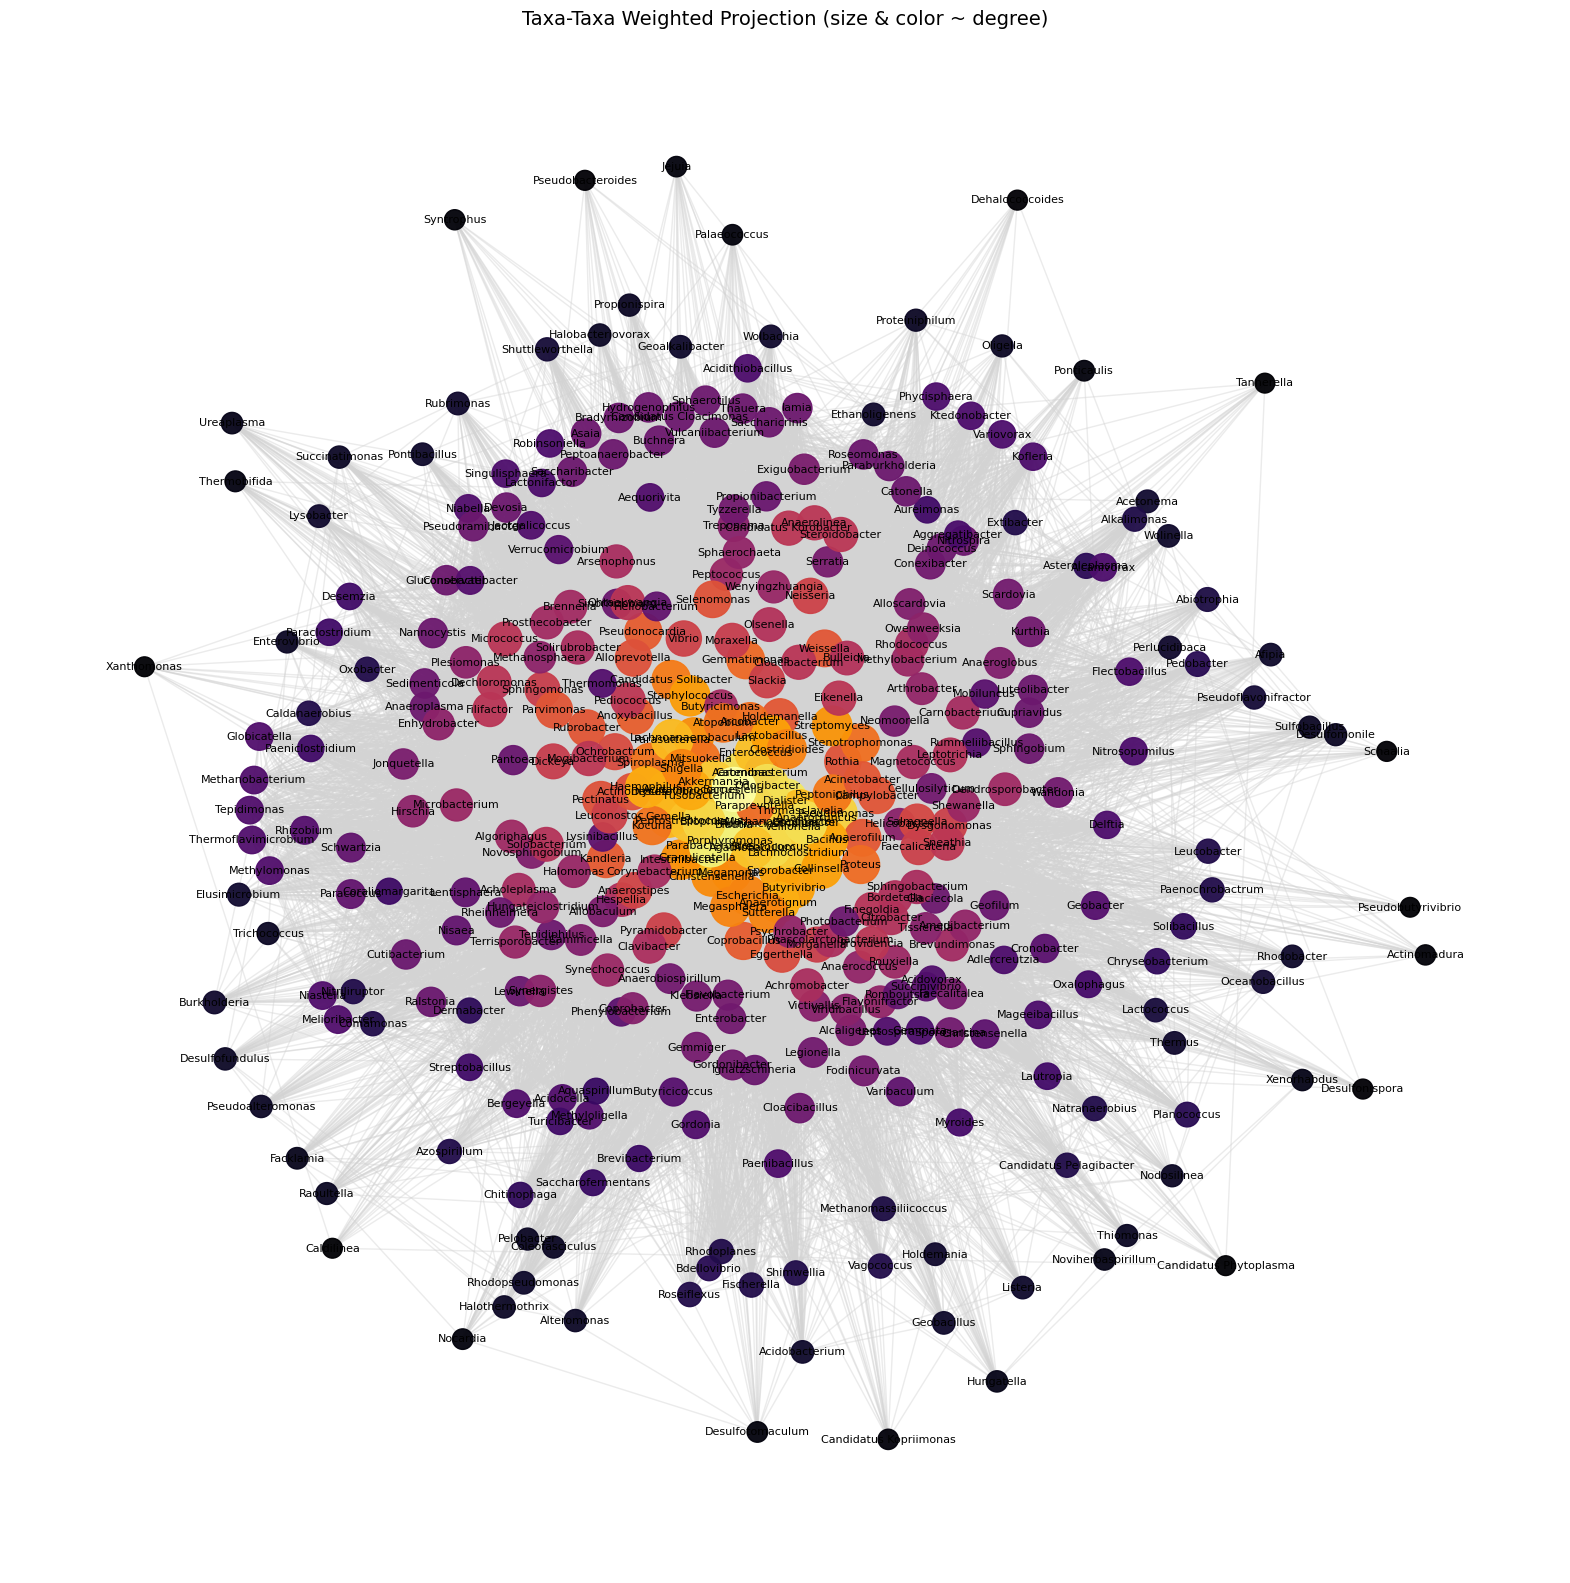

In [4]:
# BIPARTITE DISEASE DIEASE NETWORK
# --- Partitions from B_genus (assumes bipartite attr: 0=diseases, 1=taxa) ---
taxa = {n for n, d in B_genus.nodes(data=True) if d.get("bipartite") == 1}
if not taxa:
    raise ValueError("No taxa nodes found with bipartite==1 in B_genus.")

# --- Weighted unipartite projection: disease–disease (weight = shared taxa count) ---
G = bipartite.weighted_projected_graph(B_genus, taxa)

# === Summary stats ===
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
deg_vals = np.array([deg for _, deg in G.degree()], dtype=float)
weights = np.array([d.get("weight", 1.0) for _, _, d in G.edges(data=True)], dtype=float)

summary = {
    "Number of nodes": num_nodes,
    "Number of edges": num_edges,
    "Degree range": (deg_vals.min() if deg_vals.size else None,
                     deg_vals.max() if deg_vals.size else None),
    "Edge weight range": (weights.min() if weights.size else None,
                          weights.max() if weights.size else None)
}
print("=== Network Summary ===")
for k, v in summary.items():
    if isinstance(v, tuple):
        v = tuple(float(x) if x is not None else None for x in v)
    print(f"{k}: {v}")

# --- Layout ---
pos = nx.spring_layout(G, seed=42, k=1.2)

# --- Node sizes: normalize degree to [0,1] then map to pixel range ---
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)

min_size, max_size = 200, 1000
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Node colors: same normalization → Inferno colormap ---
cmap = cm.get_cmap("inferno")
node_colors = cmap(deg_norm)  # RGBA colors aligned with node order below

# --- Edge widths: normalize weights to [0,1] then map to pixel range ---
if weights.size:
    wmin, wmax = weights.min(), weights.max()
    w_norm = (weights - wmin) / (wmax - wmin) if wmax != wmin else np.ones_like(weights)
    edge_widths = 1.0 + 4.0 * w_norm
else:
    edge_widths = []

# --- Labels from disease_dict (fallback to code if missing) ---
labels = {n: taxon_dict.get(n, str(n)) for n in G.nodes()}

# --- Draw ---
plt.figure(figsize=(20, 20))

# Edges first
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.45, edge_color="lightgray")

# Nodes
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=list(G.nodes()),
    node_size=node_sizes,
    node_color=node_colors,
    alpha=0.95,
)

# Labels
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

plt.title("Taxa-Taxa Weighted Projection (size & color ~ degree)", fontsize=14)
plt.axis("off")
plt.show()


=== Network Summary (Unthresholded, Taxa–Taxa) ===
Number of nodes: 375
Number of edges: 23415
Degree range: (15.0, 319.0)
Edge weight range: (1.0, 18.0)



=== Percentile → θ (edge-weight) Map (Taxa–Taxa) ===
    0th percentile → θ = 1
   50th percentile → θ = 1
   60th percentile → θ = 1
   70th percentile → θ = 2
   80th percentile → θ = 2
   85th percentile → θ = 3
   90th percentile → θ = 4
   95th percentile → θ = 5

=== Threshold Evaluation Table (Taxa–Taxa; keep edges with weight ≥ θ) ===
 theta  non_isolate_frac  gc_frac  avg_degree  density  n_nodes  n_edges  n_components  modularity_Q  mod_gain_vs_baseline  spearman_topK_vs_prev  ARI_vs_prev    pl_xmin  pl_alpha    pl_ks  pl_n_tail  pl_tail_prop     pl_p  from_percentile
     1          1.000000 1.000000  124.880000 0.333904      375    23415             1      0.192607              0.000000                    NaN          NaN 100.000000  3.060500 0.103037        224      0.597333 0.580000                0
     2          0.621333 1.000000   63.493562 0.273679      233     7397             1      0.160229             -0.032378               0.792946     0.360079  43.000000  2.3

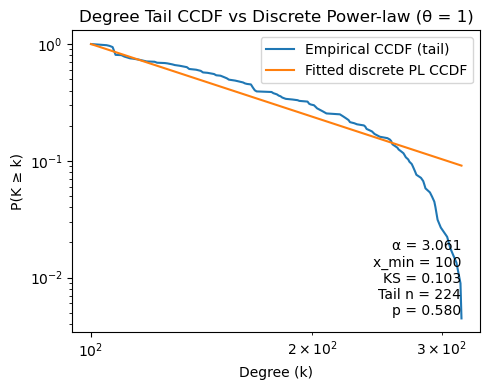

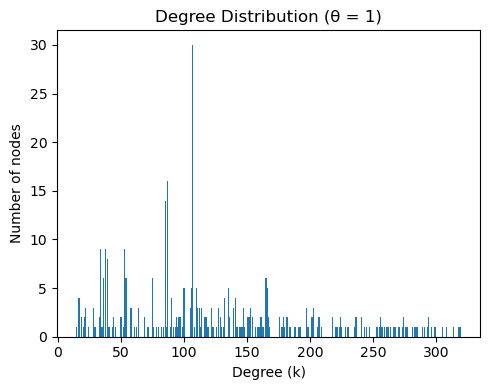

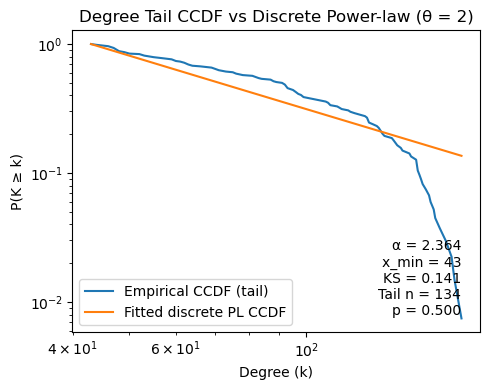

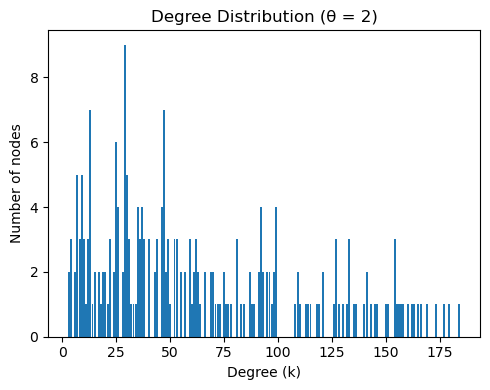

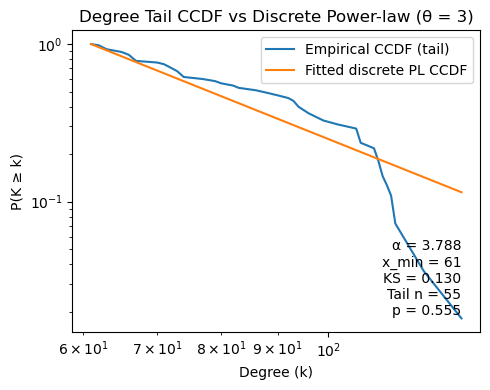

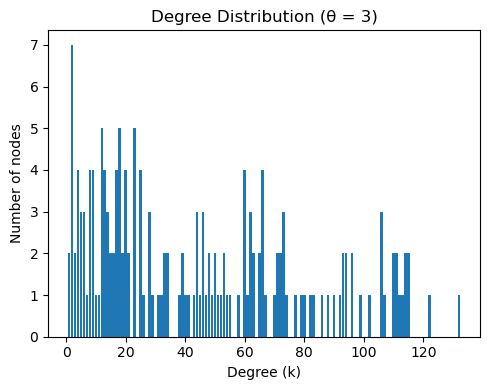

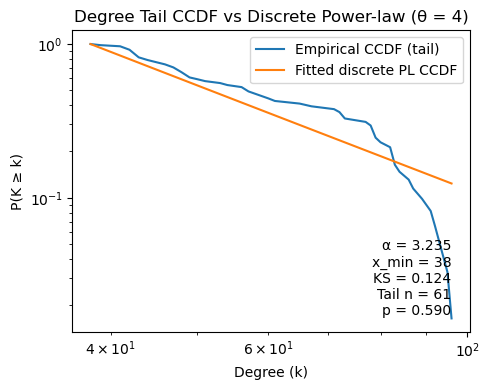

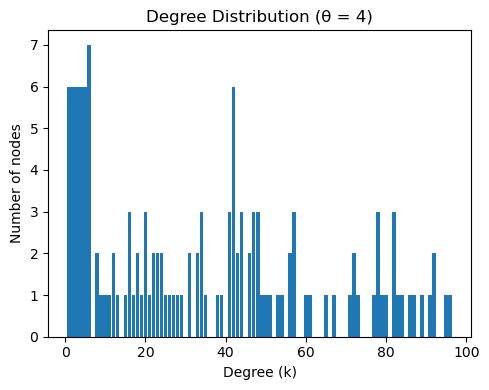

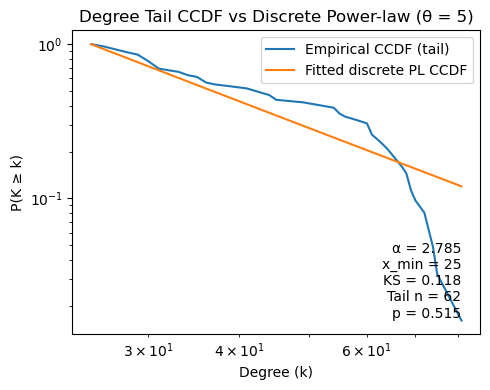

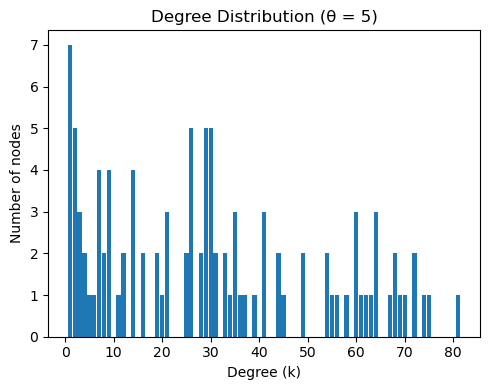

In [5]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import adjusted_rand_score as ARI
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import math
from functools import lru_cache

# Optional: exact Hurwitz zeta for discrete PL (preferred if available)
try:
    import mpmath as mp
    _HAS_MPMATH = True
    mp.mp.dps = 50  # precision
except Exception:
    _HAS_MPMATH = False
    print("[WARN] mpmath not found. Using fast discrete fallback (finite-sum + tail integral).")

# =========================
# CONFIG
# =========================
PERCENTILES = [0, 50, 60, 70, 80, 85, 90, 95]   # θ candidates from edge-weight percentiles
SHOW_PLOT = False                                # quick unthresholded visualization (optional)
TOP_K = 20                                       # for hub stability (degree ranks)
SEED = 42
EXPORT_CSV = None                                # e.g., "tt_genus_threshold_eval.csv"

# --- plotting controls for power-law diagnostics ---
PLOT_POWERLAW = True            # make CCDF plots for every theta
SAVE_PLOTS = False              # set True to save PNGs
PLOT_DIR = "powerlaw_plots_taxa"  # output folder if SAVE_PLOTS=True

# --- goodness-of-fit Monte Carlo ---
GOF_MC_REPS = 200               # increase for more stable p-values (e.g., 1000)
RANDOM_STATE = np.random.RandomState(SEED)

# -------------------------------------------------------------------
# Expectation: You already have B_genus defined in the environment:
#   - Bipartite graph with node attribute "bipartite" (0 = disease, 1 = taxa)
#   - Edges connect disease <-> taxon (genus)
#   - taxa_dict (optional) maps taxon IDs -> readable names
# -------------------------------------------------------------------

# =========================
# 1) Build weighted taxa–taxa projection from bipartite B_genus
# =========================
taxa = {n for n, d in B_genus.nodes(data=True) if d.get("bipartite") == 1}
if not taxa:
    raise ValueError("No taxa nodes found with bipartite==1 in B_genus.")

# Weighted projection: edge 'weight' == number of shared diseases
G = bipartite.weighted_projected_graph(B_genus, taxa)

# =========================
# 2) Descriptive summary (unthresholded)
# =========================
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
deg_vals = np.array([deg for _, deg in G.degree()], dtype=float)
weights = np.array([d.get("weight", 1.0) for _, _, d in G.edges(data=True)], dtype=float)

summary = {
    "Number of nodes": num_nodes,
    "Number of edges": num_edges,
    "Degree range": (float(deg_vals.min()) if deg_vals.size else None,
                     float(deg_vals.max()) if deg_vals.size else None),
    "Edge weight range": (float(weights.min()) if weights.size else None,
                          float(weights.max()) if weights.size else None),
}
print("=== Network Summary (Unthresholded, Taxa–Taxa) ===")
for k, v in summary.items():
    print(f"{k}: {v}")

if weights.size == 0:
    raise ValueError("Graph G has no edges.")

# =========================
# (Optional) quick plot (unthresholded)
# =========================
if SHOW_PLOT:
    pos = nx.spring_layout(G, seed=SEED, k=1.2)
    dmin, dmax = deg_vals.min(), deg_vals.max()
    deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
    node_sizes = 200 + deg_norm * (1000 - 200)
    node_colors = cm.get_cmap("inferno")(deg_norm)
    wmin, wmax = weights.min(), weights.max()
    w_norm = (weights - wmin) / (wmax - wmin) if wmax != wmin else np.ones_like(weights)
    edge_widths = 1.0 + 4.0 * w_norm

    try:
        labels = {n: taxa_dict.get(n, str(n)) for n in G.nodes()}
    except NameError:
        labels = {n: str(n) for n in G.nodes()}

    plt.figure(figsize=(18, 18))
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.45)
    nx.draw_networkx_nodes(G, pos, nodelist=list(G.nodes()),
                           node_size=node_sizes, node_color=node_colors, alpha=0.95)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
    plt.title("Taxa–Taxa Weighted Projection (size & color ~ degree)", fontsize=14)
    plt.axis("off")
    plt.show()

# =========================
# Helpers: community, stability, threshold summary
# (unchanged from your version)
# =========================
def louvain_modularity(Gw, seed=SEED):
    nodes = [n for n, d in Gw.degree() if d > 0]
    if not nodes:
        return 0.0, {}
    sub = Gw.subgraph(nodes).copy()
    comms = nx.algorithms.community.louvain_communities(sub, seed=seed, weight="weight")
    Q = nx.algorithms.community.modularity(sub, comms, weight="weight")
    labmap = {}
    for cid, cset in enumerate(comms):
        for u in cset:
            labmap[u] = cid
    return Q, labmap

def topk_degree_ranks(Gw, k=TOP_K):
    deg = dict(Gw.degree())
    if not deg:
        return pd.Series(dtype=float)
    s = pd.Series(deg).sort_values(ascending=False)
    ranks = s.rank(method="dense", ascending=False)
    out = pd.Series(0.0, index=pd.Index(Gw.nodes()))
    out.loc[ranks.index] = ranks
    top_idx = ranks[ranks <= k].index
    out.loc[~out.index.isin(top_idx)] = 0.0
    return out

def spearman_between(r1: pd.Series, r2: pd.Series):
    if r1 is None or r2 is None:
        return np.nan
    idx = r1.index.union(r2.index)
    a = r1.reindex(idx, fill_value=0)
    b = r2.reindex(idx, fill_value=0)
    return a.corr(b, method="spearman")

def ari_between(labels1: dict, labels2: dict):
    if labels1 is None or labels2 is None:
        return np.nan
    idx = set(labels1).intersection(labels2)
    if len(idx) < 2:
        return np.nan
    y1 = [labels1[i] for i in idx]
    y2 = [labels2[i] for i in idx]
    return ARI(y1, y2)

def summarize_after_threshold(G_in: nx.Graph, theta):
    Gw = G_in.copy()
    Gw.remove_edges_from([(u, v) for u, v, d in Gw.edges(data=True)
                          if d.get("weight", 0.0) < theta])
    isolates = [n for n, d in Gw.degree() if d == 0]
    Gw.remove_nodes_from(isolates)

    n_nodes = Gw.number_of_nodes()
    n_edges = Gw.number_of_edges()

    if n_nodes > 0:
        comps = list(nx.connected_components(Gw))
        gc_frac = len(max(comps, key=len)) / n_nodes if comps else 0.0
        avg_degree = float(np.mean([deg for _, deg in Gw.degree()])) if n_nodes else 0.0
        density = nx.density(Gw) if n_nodes > 1 else 0.0
        n_components = nx.number_connected_components(Gw) if n_nodes else 0
    else:
        gc_frac, avg_degree, density, n_components = 0.0, 0.0, 0.0, 0

    Q, labels = louvain_modularity(Gw, seed=SEED)
    ranks = topk_degree_ranks(Gw, k=TOP_K)

    return Gw, {
        "n_nodes": n_nodes,
        "n_edges": n_edges,
        "avg_degree": avg_degree,
        "density": density,
        "n_components": n_components,
        "gc_frac": gc_frac,
        "modularity_Q": Q,
        "ranks": ranks,
        "labels": labels,
    }

# =========================
# Discrete power-law helpers (tail only)
# (unchanged from your version)
# =========================
def _empirical_ccdf(data):
    x = np.sort(np.asarray(data, dtype=int))
    n = x.size
    if n == 0:
        return np.array([], dtype=int), np.array([], dtype=float)
    vals, counts = np.unique(x, return_counts=True)
    tail_counts = counts[::-1].cumsum()[::-1]
    ccdf = tail_counts / n
    return vals, ccdf

@lru_cache(maxsize=100000)
def _discrete_zeta_cached(alpha_x1000, xmin):
    alpha = alpha_x1000 / 1000.0
    xmin = int(xmin)
    if _HAS_MPMATH:
        return float(mp.zeta(alpha, xmin))
    K = 100000
    s = 0.0
    for k in range(xmin, xmin + K):
        s += k ** (-alpha)
    x0 = xmin + K - 0.5
    if alpha > 1:
        s += (x0 ** (1 - alpha)) / (alpha - 1)
    return s

def _discrete_zeta(alpha, xmin):
    return _discrete_zeta_cached(int(round(float(alpha) * 1000)), int(xmin))

def _negloglik_discrete(alpha, data, xmin):
    alpha = float(alpha)
    if alpha <= 1.0:
        return np.inf
    data = np.asarray(data, dtype=int)
    if data.size == 0:
        return np.inf
    z = _discrete_zeta(alpha, int(xmin))
    if not np.isfinite(z) or z <= 0:
        return np.inf
    s_logx = float(np.sum(np.log(data)))
    return len(data) * math.log(z) + alpha * s_logx

def _mle_alpha_discrete(data, xmin):
    data = np.asarray(data, dtype=int)
    data = data[data >= int(xmin)]
    if data.size == 0:
        return np.nan
    a_lo, a_hi = 1.01, 6.0
    def nll(a): return _negloglik_discrete(a, data, int(xmin))
    phi = (1 + 5 ** 0.5) / 2
    invphi = 1 / phi
    tol = 1e-7
    a, b = a_lo, a_hi
    c = b - invphi * (b - a)
    d = a + invphi * (b - a)
    fc = nll(c); fd = nll(d)
    it = 0
    while abs(b - a) > tol and it < 200:
        if fc < fd:
            b, d, fd = d, c, fc
            c = b - invphi * (b - a); fc = nll(c)
        else:
            a, c, fc = c, d, fd
            d = a + invphi * (b - a); fd = nll(d)
        it += 1
    return (a + b) / 2.0

def fit_powerlaw_degree_tail_discrete(degrees, xmin_candidates="unique", adapt_tail=True,
                                      min_tail_n=20, tail_frac_floor=0.05, tail_n_cap=50):
    deg = np.asarray(list(degrees), dtype=int)
    deg = deg[np.isfinite(deg)]
    deg = deg[deg > 0]
    if deg.size == 0:
        return {"pl_xmin": np.nan, "pl_alpha": np.nan, "pl_ks": np.nan,
                "pl_n_tail": 0, "pl_tail_prop": 0.0}
    n_total = deg.size
    if xmin_candidates == "unique":
        cands = np.unique(deg)
    else:
        cands = np.array(sorted({int(c) for c in xmin_candidates if c > 0}), dtype=int)
        if cands.size == 0:
            cands = np.unique(deg)
    if adapt_tail:
        min_tail_n = max(10, min(tail_n_cap, int(max(min_tail_n, tail_frac_floor * n_total))))
    best = {"pl_xmin": np.nan, "pl_alpha": np.nan, "pl_ks": np.inf,
            "pl_n_tail": 0, "pl_tail_prop": 0.0}
    for xmin in cands:
        tail = deg[deg >= xmin]
        n_tail = tail.size
        if n_tail < min_tail_n: continue
        alpha = _mle_alpha_discrete(tail, xmin)
        if not np.isfinite(alpha) or alpha <= 1.0: continue
        xs = np.sort(np.unique(tail))
        counts = np.array([(tail <= v).sum() for v in xs], dtype=float) / n_tail
        denom = _discrete_zeta(alpha, xmin)
        S_xp1 = np.array([_discrete_zeta(alpha, int(v) + 1) for v in xs])
        F_pl = 1.0 - (S_xp1 / denom)
        ks = float(np.max(np.abs(counts - F_pl)))
        if ks < best["pl_ks"]:
            best.update({
                "pl_xmin": float(xmin),
                "pl_alpha": float(alpha),
                "pl_ks": float(ks),
                "pl_n_tail": int(n_tail),
                "pl_tail_prop": float(n_tail / n_total),
            })
    if not np.isfinite(best["pl_ks"]) or best["pl_ks"] == np.inf:
        return {"pl_xmin": np.nan, "pl_alpha": np.nan, "pl_ks": np.nan,
                "pl_n_tail": 0, "pl_tail_prop": 0.0}
    return best

def discrete_ccdf_model(xs_int, xmin, alpha):
    xs_int = np.asarray(xs_int, dtype=int)
    denom = _discrete_zeta(alpha, int(xmin))
    num = np.array([_discrete_zeta(alpha, int(k)) for k in xs_int])
    return num / denom

def _cdf_discrete_pl(k, alpha, xmin):
    denom = _discrete_zeta(alpha, int(xmin))
    return 1.0 - (_discrete_zeta(alpha, int(k) + 1) / denom)

def _sample_discrete_powerlaw(alpha, xmin, size, rng):
    samples = np.empty(size, dtype=int)
    for i in range(size):
        u = rng.uniform()
        lo = int(xmin); hi = lo
        while _cdf_discrete_pl(hi, alpha, xmin) < u:
            hi *= 2
            if hi > 10**7: break
        while lo < hi:
            mid = (lo + hi) // 2
            if _cdf_discrete_pl(mid, alpha, xmin) >= u:
                hi = mid
            else:
                lo = mid + 1
        samples[i] = lo
    return samples

def ks_stat_empirical_vs_model_tail(tail, alpha, xmin):
    tail = np.asarray(tail, dtype=int)
    n = tail.size
    xs = np.sort(np.unique(tail))
    empF = np.array([(tail <= v).sum() for v in xs], dtype=float) / n
    modF = np.array([_cdf_discrete_pl(int(v), alpha, int(xmin)) for v in xs], dtype=float)
    return float(np.max(np.abs(empF - modF)))

def gof_pvalue_discrete_pl_refit(tail, reps=GOF_MC_REPS, rng=RANDOM_STATE):
    tail = np.asarray(tail, dtype=int)
    n = tail.size
    if n == 0:
        return np.nan
    fit_emp = fit_powerlaw_degree_tail_discrete(tail, xmin_candidates="unique", adapt_tail=True)
    xmin_hat, alpha_hat = fit_emp["pl_xmin"], fit_emp["pl_alpha"]
    if not (np.isfinite(xmin_hat) and np.isfinite(alpha_hat) and fit_emp["pl_n_tail"] > 0):
        return np.nan
    KS_emp = ks_stat_empirical_vs_model_tail(tail, alpha_hat, int(round(xmin_hat)))
    ks_sims = np.empty(int(reps), dtype=float)
    xmin_i = int(round(xmin_hat))
    for i in range(int(reps)):
        sim = _sample_discrete_powerlaw(alpha_hat, xmin_i, n, rng)
        fit_sim = fit_powerlaw_degree_tail_discrete(sim, xmin_candidates="unique", adapt_tail=True)
        xmins, alphas = fit_sim["pl_xmin"], fit_sim["pl_alpha"]
        if not (np.isfinite(xmins) and np.isfinite(alphas) and fit_sim["pl_n_tail"] > 0):
            ks_sims[i] = np.nan; continue
        ks_sims[i] = ks_stat_empirical_vs_model_tail(sim, alphas, int(round(xmins)))
    ks_sims = ks_sims[np.isfinite(ks_sims)]
    if ks_sims.size == 0:
        return np.nan
    return float((ks_sims >= KS_emp).mean())

def plot_powerlaw_fit_for_theta(theta, deg_list, pl_dict):
    xmin = pl_dict["pl_xmin"]
    alpha = pl_dict["pl_alpha"]
    ks = pl_dict["pl_ks"]
    n_tail = pl_dict["pl_n_tail"]
    pval = pl_dict.get("pl_p", np.nan)

    if not np.isfinite(xmin) or not np.isfinite(alpha) or n_tail == 0:
        print(f"[theta={theta}] No valid discrete power-law tail to plot.")
        return

    deg = np.asarray(deg_list, dtype=int)
    xmin_i = int(round(xmin))
    tail = deg[deg >= xmin_i]

    xs_emp, ccdf_emp = _empirical_ccdf(tail)
    ccdf_pl = discrete_ccdf_model(xs_emp, xmin_i, float(alpha))

    plt.figure(figsize=(5, 4))
    plt.rcParams["figure.figsize"] = (5, 4)
    plt.rcParams["figure.autolayout"] = False   # stop auto resizing
    plt.loglog(xs_emp, ccdf_emp, linestyle='-', label='Empirical CCDF (tail)')
    plt.loglog(xs_emp, ccdf_pl, linestyle='-', label='Fitted discrete PL CCDF')
    plt.xlabel("Degree (k)")
    plt.ylabel("P(K ≥ k)")
    plt.title(f"Degree Tail CCDF vs Discrete Power-law (θ = {theta})")

    txt = f"α = {alpha:.3f}\nx_min = {xmin_i}\nKS = {ks:.3f}\nTail n = {n_tail}"
    if np.isfinite(pval):
        txt += f"\np = {pval:.3f}"
    x_right = xs_emp.max()
    y_bottom = max(1e-6, float(min(ccdf_emp.min(), ccdf_pl.min())))
    plt.text(x_right, y_bottom, txt, ha='right', va='bottom')

    plt.legend()
    plt.tight_layout()

    if SAVE_PLOTS:
        os.makedirs(PLOT_DIR, exist_ok=True)
        out = os.path.join(PLOT_DIR, f"pl_ccdf_theta_{theta}.png")
        plt.savefig(out, dpi=200)
        print(f"Saved: {out}")

    plt.show()

# =========================
# 5) Percentile-based θ evaluation (with metrics + discrete power-law)
# =========================
integerish = np.allclose(weights, np.round(weights))
perc_vals_for_theta = np.percentile(weights, PERCENTILES)
thetas = [int(np.floor(v)) if integerish else float(v) for v in perc_vals_for_theta]
theta_unique = sorted(set(thetas))

theta_from_perc = {}
for p, v in zip(PERCENTILES, thetas):
    theta_from_perc.setdefault(v, p)

rows = []
prev_ranks = None
prev_labels = None
baseline_Q = None

theta_to_deg = {}
theta_to_pl = {}

for theta in theta_unique:
    Gw, stats = summarize_after_threshold(G, theta)

    if baseline_Q is None:
        baseline_Q = stats["modularity_Q"]

    deg_list = [d for _, d in Gw.degree()]
    pl = fit_powerlaw_degree_tail_discrete(
        deg_list,
        xmin_candidates="unique",
        adapt_tail=True,
        min_tail_n=20,
        tail_frac_floor=0.05,
        tail_n_cap=50
    )

    if np.isfinite(pl["pl_xmin"]) and np.isfinite(pl["pl_alpha"]) and pl["pl_n_tail"] > 0:
        deg_arr = np.asarray(deg_list, dtype=int)
        tail = deg_arr[deg_arr >= int(round(pl["pl_xmin"]))]
        pl["pl_p"] = gof_pvalue_discrete_pl_refit(tail, reps=GOF_MC_REPS, rng=RANDOM_STATE)
    else:
        pl["pl_p"] = np.nan

    theta_to_deg[theta] = np.array(deg_list, dtype=int)
    theta_to_pl[theta] = pl

    rho = spearman_between(prev_ranks, stats["ranks"]) if prev_ranks is not None else np.nan
    ari = ari_between(prev_labels, stats["labels"]) if prev_labels is not None else np.nan

    rows.append({
        "theta": theta,
        "non_isolate_frac": (stats["n_nodes"] / G.number_of_nodes()) if G.number_of_nodes() else 0.0,
        "gc_frac": stats["gc_frac"],
        "avg_degree": stats["avg_degree"],
        "density": stats["density"],
        "n_nodes": stats["n_nodes"],
        "n_edges": stats["n_edges"],
        "n_components": stats["n_components"],
        "modularity_Q": stats["modularity_Q"],
        "mod_gain_vs_baseline": stats["modularity_Q"] - baseline_Q,
        "spearman_topK_vs_prev": rho,
        "ARI_vs_prev": ari,
        # Power-law diagnostics (discrete)
        "pl_xmin": pl["pl_xmin"],
        "pl_alpha": pl["pl_alpha"],
        "pl_ks": pl["pl_ks"],
        "pl_n_tail": pl["pl_n_tail"],
        "pl_tail_prop": pl["pl_tail_prop"],
        "pl_p": pl["pl_p"],
        "from_percentile": theta_from_perc.get(theta, pd.NA),
    })

    prev_ranks = stats["ranks"]
    prev_labels = stats["labels"]

df_theta = pd.DataFrame(rows).sort_values("theta").reset_index(drop=True)

# Pretty table
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
pd.set_option("display.float_format", "{:,.6f}".format)

print("\n=== Percentile → θ (edge-weight) Map (Taxa–Taxa) ===")
for p, v in zip(PERCENTILES, perc_vals_for_theta):
    v_disp = int(np.floor(v)) if integerish else float(v)
    print(f"  {p:>3}th percentile → θ = {v_disp}")

print("\n=== Threshold Evaluation Table (Taxa–Taxa; keep edges with weight ≥ θ) ===")
print(df_theta.to_string(index=False))

if EXPORT_CSV:
    df_theta.to_csv(EXPORT_CSV, index=False)
    print(f"\nSaved: {EXPORT_CSV}")

# --- add near your plotting controls ---
PLOT_DEGREE_HIST = True  # make degree distribution bar plots for every theta

def plot_degree_hist_for_theta(theta, deg_list):
    deg = np.asarray(deg_list, dtype=int)
    deg = deg[np.isfinite(deg)]
    if deg.size == 0:
        print(f"[theta={theta}] No degrees to plot.")
        return
    vals, counts = np.unique(deg, return_counts=True)
    plt.figure(figsize=(5, 4))
    
    plt.rcParams["figure.figsize"] = (5, 4)
    plt.rcParams["figure.autolayout"] = False   # stop auto resizing
    plt.bar(vals, counts, width=0.9, align='center')
    plt.xlabel("Degree (k)")
    plt.ylabel("Number of nodes")
    plt.title(f"Degree Distribution (θ = {theta})")
    plt.tight_layout()
    if SAVE_PLOTS:
        os.makedirs(PLOT_DIR, exist_ok=True)
        out = os.path.join(PLOT_DIR, f"degree_hist_theta_{theta}.png")
        plt.savefig(out, dpi=200)
        print(f"Saved: {out}")
    plt.show()

# 6) Plot discrete power-law fits AND degree histograms for all thresholds
if PLOT_POWERLAW or PLOT_DEGREE_HIST:
    for theta in theta_unique:
        deg_list = theta_to_deg[theta]
        if PLOT_POWERLAW:
            pl = theta_to_pl[theta]
            plot_powerlaw_fit_for_theta(theta, deg_list, pl)
        if PLOT_DEGREE_HIST:
            plot_degree_hist_for_theta(theta, deg_list)


=== Network Summary (Unthresholded) ===
Number of nodes: 65
Number of edges: 1930
Degree range: (np.float64(30.0), np.float64(64.0))
Edge weight range: (np.float64(1.0), np.float64(36.0))
Max possible edges: 2080

=== Percentile → θ Map ===
    0th percentile → θ = 1
   50th percentile → θ = 5
   60th percentile → θ = 6
   70th percentile → θ = 7
   80th percentile → θ = 9
   85th percentile → θ = 10
   90th percentile → θ = 13
   95th percentile → θ = 17

=== Threshold Evaluation Table (log-normal fit) ===
 theta  non_isolate_frac  gc_frac  avg_degree  density  n_nodes  n_edges  n_components  modularity_Q  mod_gain_vs_baseline  spearman_topK_vs_prev  ARI_vs_prev    ln_mu  ln_sigma    ln_ks  ln_n_tail  ln_tail_prop  from_percentile
     1          1.000000 1.000000   59.384615 0.927885       65     1930             1      0.089924              0.000000                    NaN          NaN 4.077846  0.118391 0.246835         65      1.000000                0
     5          0.969231 1.00

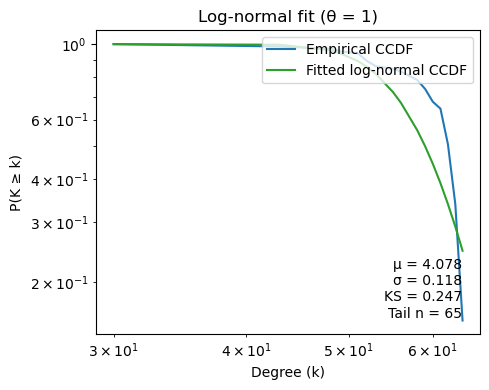

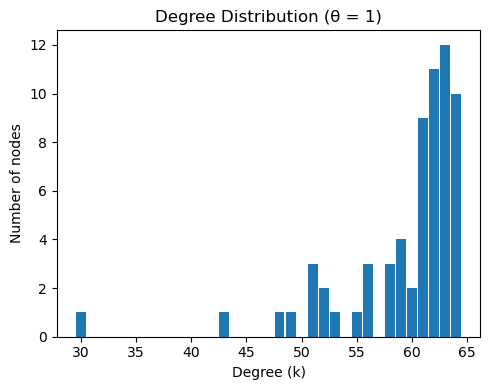

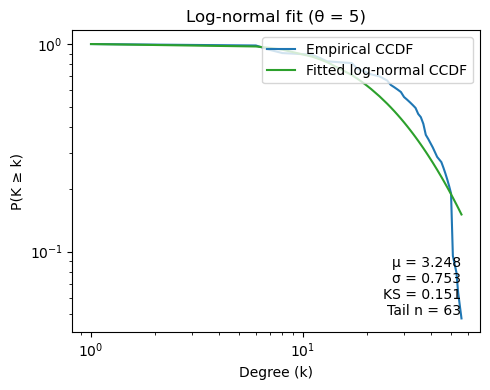

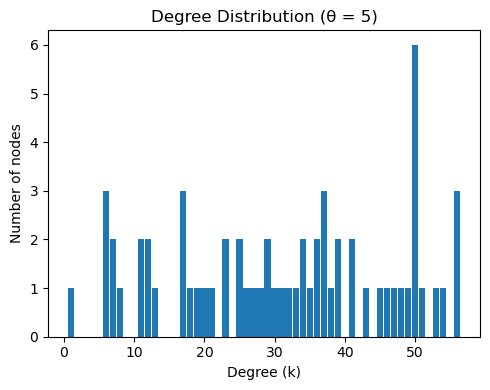

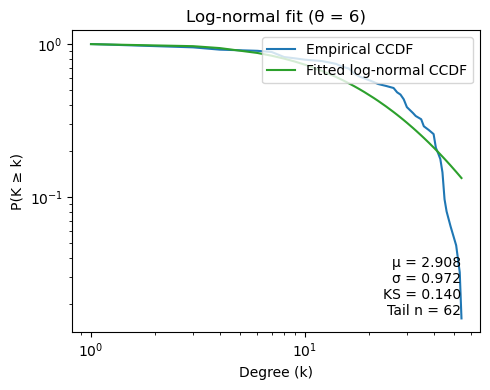

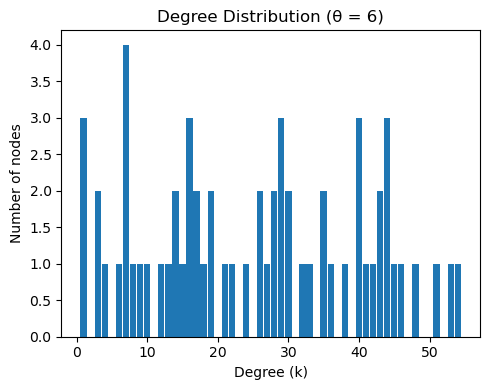

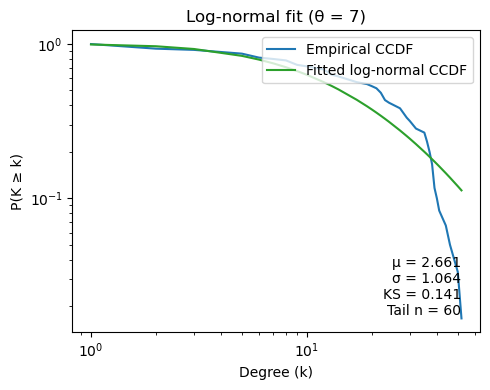

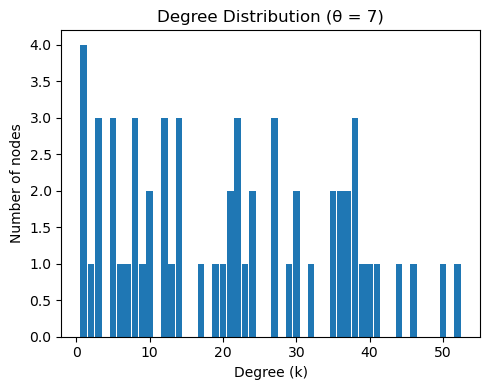

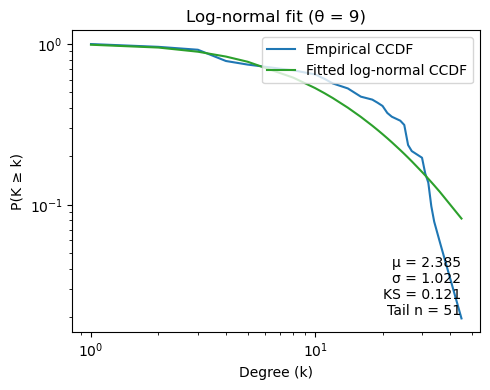

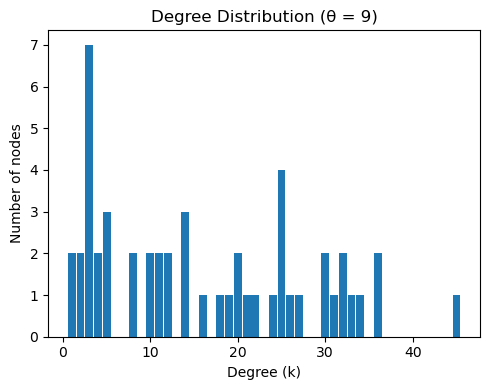

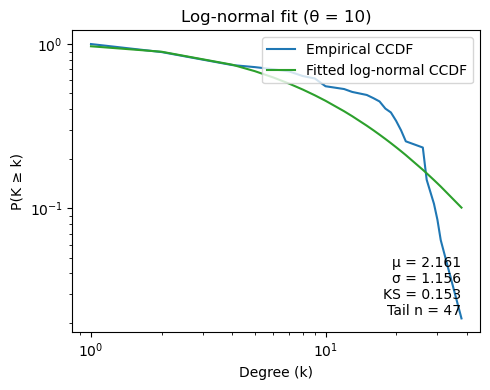

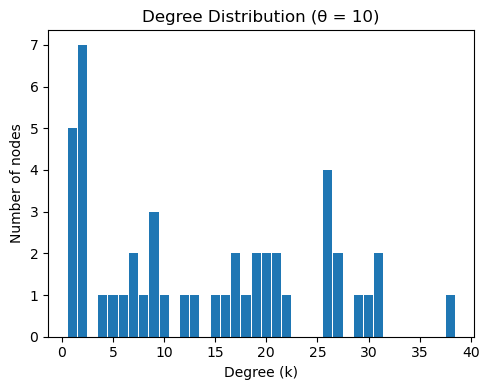

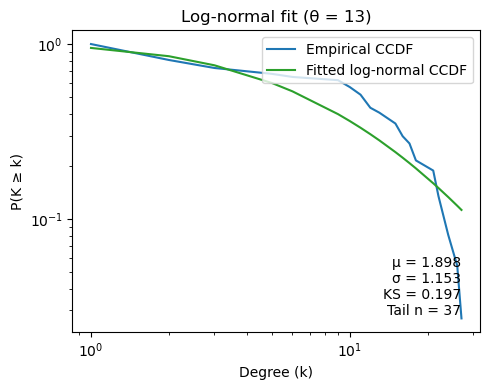

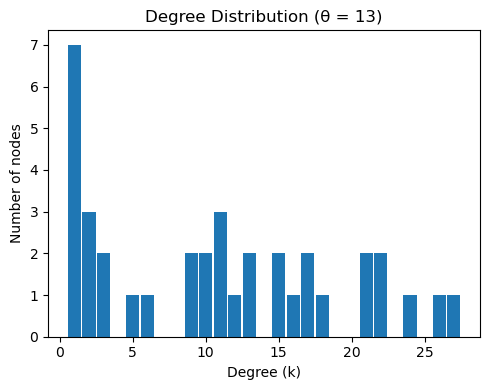

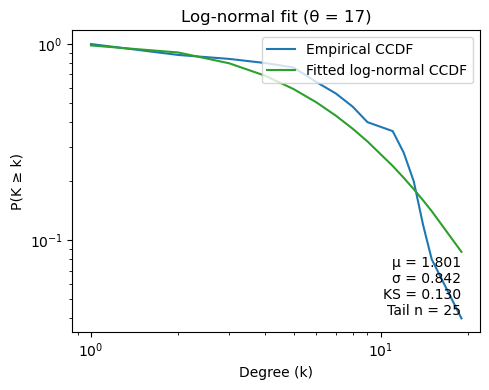

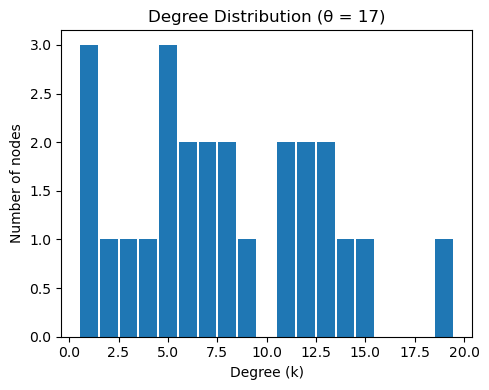

In [8]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import adjusted_rand_score as ARI
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import math
from functools import lru_cache
import scipy.stats as sps   # ✅ FIX: use sps instead of stats

# =========================
# CONFIG
# =========================
PERCENTILES = [0, 50, 60, 70, 80, 85, 90, 95]
SHOW_PLOT = False
TOP_K = 20
SEED = 42
EXPORT_CSV = None

PLOT_LOGNORMAL = True
PLOT_DEGREE_HIST = True
SAVE_PLOTS = False
PLOT_DIR = "distribution_plots"

# -------------------------------------------------------------------
# Expectation: You already have B_genus defined:
# bipartite graph with node attribute "bipartite" (0 = disease, 1 = taxa)
# -------------------------------------------------------------------

# =========================
# 1) Build weighted disease–disease projection
# =========================
diseases = {n for n, d in B_genus.nodes(data=True) if d.get("bipartite") == 0}
if not diseases:
    raise ValueError("No disease nodes found with bipartite==0 in B_species.")

G = bipartite.weighted_projected_graph(B_genus, diseases)

# =========================
# Summary (unthresholded)
# =========================
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
deg_vals = np.array([deg for _, deg in G.degree()], dtype=float)
weights = np.array([d.get("weight", 1.0) for _, _, d in G.edges(data=True)], dtype=float)

summary = {
    "Number of nodes": num_nodes,
    "Number of edges": num_edges,
    "Degree range": (deg_vals.min(), deg_vals.max()) if deg_vals.size else None,
    "Edge weight range": (weights.min(), weights.max()) if weights.size else None,
    "Max possible edges": int(num_nodes * (num_nodes - 1) // 2),
}
print("=== Network Summary (Unthresholded) ===")
for k, v in summary.items():
    print(f"{k}: {v}")

if weights.size == 0:
    raise ValueError("Graph G has no edges.")

# =========================
# Helpers (community, stability, etc.)
# =========================
def louvain_modularity(Gw, seed=SEED):
    nodes = [n for n, d in Gw.degree() if d > 0]
    if not nodes:
        return 0.0, {}
    sub = Gw.subgraph(nodes).copy()
    comms = nx.algorithms.community.louvain_communities(sub, seed=seed, weight="weight")
    Q = nx.algorithms.community.modularity(sub, comms, weight="weight")
    labmap = {}
    for cid, cset in enumerate(comms):
        for u in cset:
            labmap[u] = cid
    return Q, labmap

def topk_degree_ranks(Gw, k=TOP_K):
    deg = dict(Gw.degree())
    if not deg:
        return pd.Series(dtype=float)
    s = pd.Series(deg).sort_values(ascending=False)
    ranks = s.rank(method="dense", ascending=False)
    out = pd.Series(0.0, index=pd.Index(Gw.nodes()))
    out.loc[ranks.index] = ranks
    top_idx = ranks[ranks <= k].index
    out.loc[~out.index.isin(top_idx)] = 0.0
    return out

def spearman_between(r1: pd.Series, r2: pd.Series):
    if r1 is None or r2 is None:
        return np.nan
    idx = r1.index.union(r2.index)
    a = r1.reindex(idx, fill_value=0)
    b = r2.reindex(idx, fill_value=0)
    return a.corr(b, method="spearman")

def ari_between(labels1: dict, labels2: dict):
    if labels1 is None or labels2 is None:
        return np.nan
    idx = set(labels1).intersection(labels2)
    if len(idx) < 2:
        return np.nan
    y1 = [labels1[i] for i in idx]
    y2 = [labels2[i] for i in idx]
    return ARI(y1, y2)

def summarize_after_threshold(G_in: nx.Graph, theta):
    Gw = G_in.copy()
    Gw.remove_edges_from([(u, v) for u, v, d in Gw.edges(data=True)
                          if d.get("weight", 0.0) < theta])
    isolates = [n for n, d in Gw.degree() if d == 0]
    Gw.remove_nodes_from(isolates)

    n_nodes = Gw.number_of_nodes()
    n_edges = Gw.number_of_edges()

    if n_nodes > 0:
        comps = list(nx.connected_components(Gw))
        gc_frac = len(max(comps, key=len)) / n_nodes if comps else 0.0
        avg_degree = float(np.mean([deg for _, deg in Gw.degree()])) if n_nodes else 0.0
        density = nx.density(Gw) if n_nodes > 1 else 0.0
        n_components = nx.number_connected_components(Gw) if n_nodes else 0
    else:
        gc_frac, avg_degree, density, n_components = 0.0, 0.0, 0.0, 0

    Q, labels = louvain_modularity(Gw, seed=SEED)
    ranks = topk_degree_ranks(Gw, k=TOP_K)

    return Gw, {
        "n_nodes": n_nodes,
        "n_edges": n_edges,
        "avg_degree": avg_degree,
        "density": density,
        "n_components": n_components,
        "gc_frac": gc_frac,
        "modularity_Q": Q,
        "ranks": ranks,
        "labels": labels,
    }

# =========================
# Empirical CCDF
# =========================
def _empirical_ccdf(data):
    x = np.sort(np.asarray(data, dtype=int))
    n = x.size
    if n == 0:
        return np.array([], dtype=int), np.array([], dtype=float)
    vals, counts = np.unique(x, return_counts=True)
    tail_counts = counts[::-1].cumsum()[::-1]
    ccdf = tail_counts / n
    return vals, ccdf

# =========================
# Log-normal fitting
# =========================
def fit_lognormal(degrees, xmin=1, min_tail_n=20):
    # ✅ FIX: always convert to numpy array
    degrees = np.asarray(degrees, dtype=float)

    deg = degrees[np.isfinite(degrees)]
    deg = deg[deg >= xmin]
    n = deg.size
    if n < min_tail_n:
        return {"ln_mu": np.nan, "ln_sigma": np.nan, "ln_ks": np.nan,
                "ln_n_tail": 0, "ln_tail_prop": 0.0}
    
    sigma, loc, scale = sps.lognorm.fit(deg, floc=0)
    mu = np.log(scale)
    
    xs = np.sort(deg)
    emp_cdf = np.arange(1, n+1) / n
    mod_cdf = sps.lognorm.cdf(xs, s=sigma, loc=loc, scale=scale)
    ks = np.max(np.abs(emp_cdf - mod_cdf))
    
    return {
        "ln_mu": float(mu),
        "ln_sigma": float(sigma),
        "ln_ks": float(ks),
        "ln_n_tail": int(n),
        "ln_tail_prop": float(n / degrees.size if degrees.size else 0.0),
    }

def plot_lognormal_fit(theta, deg_list, ln_dict):
    mu = ln_dict["ln_mu"]
    sigma = ln_dict["ln_sigma"]
    ks = ln_dict["ln_ks"]
    n_tail = ln_dict["ln_n_tail"]

    if not np.isfinite(mu) or not np.isfinite(sigma) or n_tail == 0:
        print(f"[theta={theta}] No valid log-normal fit.")
        return
    
    deg = np.asarray(deg_list, dtype=float)
    deg = deg[deg > 0]

    xs_emp, ccdf_emp = _empirical_ccdf(deg)
    ccdf_ln = 1.0 - sps.lognorm.cdf(xs_emp, s=sigma, scale=np.exp(mu))

    plt.figure(figsize=(5, 4))
    plt.loglog(xs_emp, ccdf_emp, '-', color='tab:blue', label='Empirical CCDF')
    plt.loglog(xs_emp, ccdf_ln, '-', color='tab:green', label='Fitted log-normal CCDF')

    plt.xlabel("Degree (k)")
    plt.ylabel("P(K ≥ k)")
    plt.title(f"Log-normal fit (θ = {theta})")

    txt = f"μ = {mu:.3f}\nσ = {sigma:.3f}\nKS = {ks:.3f}\nTail n = {n_tail}"
    plt.text(xs_emp.max(), max(1e-6, ccdf_emp.min()), txt,
             ha='right', va='bottom')

    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# =========================
# Degree histogram
# =========================
def plot_degree_hist_for_theta(theta, deg_list):
    deg = np.asarray(deg_list, dtype=int)
    deg = deg[np.isfinite(deg)]
    if deg.size == 0:
        print(f"[theta={theta}] No degrees to plot.")
        return
    vals, counts = np.unique(deg, return_counts=True)
    plt.figure(figsize=(5, 4))
    plt.bar(vals, counts, width=0.9)
    plt.xlabel("Degree (k)")
    plt.ylabel("Number of nodes")
    plt.title(f"Degree Distribution (θ = {theta})")
    plt.tight_layout()
    plt.show()

# =========================
# 5) Evaluate thresholds (log-normal fit)
# =========================
integerish = np.allclose(weights, np.round(weights))
perc_vals_for_theta = np.percentile(weights, PERCENTILES)
thetas = [int(np.floor(v)) if integerish else float(v) for v in perc_vals_for_theta]
theta_unique = sorted(set(thetas))

theta_from_perc = {v: p for p, v in zip(PERCENTILES, thetas)}

rows = []
theta_to_deg = {}
theta_to_ln = {}

prev_ranks = None
prev_labels = None
baseline_Q = None

for theta in theta_unique:
    Gw, stats = summarize_after_threshold(G, theta)
    if baseline_Q is None:
        baseline_Q = stats["modularity_Q"]

    deg_list = [d for _, d in Gw.degree()]
    theta_to_deg[theta] = np.array(deg_list, dtype=int)

    ln = fit_lognormal(deg_list, xmin=1, min_tail_n=20)
    theta_to_ln[theta] = ln

    rho = spearman_between(prev_ranks, stats["ranks"]) if prev_ranks is not None else np.nan
    ari = ari_between(prev_labels, stats["labels"]) if prev_labels is not None else np.nan

    rows.append({
        "theta": theta,
        "non_isolate_frac": (stats["n_nodes"] / G.number_of_nodes()) if G.number_of_nodes() else 0.0,
        "gc_frac": stats["gc_frac"],
        "avg_degree": stats["avg_degree"],
        "density": stats["density"],
        "n_nodes": stats["n_nodes"],
        "n_edges": stats["n_edges"],
        "n_components": stats["n_components"],
        "modularity_Q": stats["modularity_Q"],
        "mod_gain_vs_baseline": stats["modularity_Q"] - baseline_Q,
        "spearman_topK_vs_prev": rho,
        "ARI_vs_prev": ari,
        # Log-normal diagnostics
        "ln_mu": ln["ln_mu"],
        "ln_sigma": ln["ln_sigma"],
        "ln_ks": ln["ln_ks"],
        "ln_n_tail": ln["ln_n_tail"],
        "ln_tail_prop": ln["ln_tail_prop"],
        "from_percentile": theta_from_perc.get(theta, pd.NA),
    })

    prev_ranks = stats["ranks"]
    prev_labels = stats["labels"]

df_theta = pd.DataFrame(rows).sort_values("theta").reset_index(drop=True)

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
pd.set_option("display.float_format", "{:,.6f}".format)

print("\n=== Percentile → θ Map ===")
for p, v in zip(PERCENTILES, perc_vals_for_theta):
    v_disp = int(np.floor(v)) if integerish else float(v)
    print(f"  {p:>3}th percentile → θ = {v_disp}")

print("\n=== Threshold Evaluation Table (log-normal fit) ===")
print(df_theta.to_string(index=False))

if EXPORT_CSV:
    df_theta.to_csv(EXPORT_CSV, index=False)
    print(f"\nSaved: {EXPORT_CSV}")

# =========================
# 6) Plots
# =========================
for theta in theta_unique:
    deg_list = theta_to_deg[theta]
    if PLOT_LOGNORMAL:
        plot_lognormal_fit(theta, deg_list, theta_to_ln[theta])
    if PLOT_DEGREE_HIST:
        plot_degree_hist_for_theta(theta, deg_list)


=== Network Summary (Unthresholded) ===
Number of nodes: 65
Number of edges: 1930
Degree range: (np.float64(30.0), np.float64(64.0))
Edge weight range: (np.float64(1.0), np.float64(36.0))
Max possible edges: 2080

=== Percentile → θ Map ===
    0th percentile → θ = 1
   50th percentile → θ = 5
   60th percentile → θ = 6
   70th percentile → θ = 7
   80th percentile → θ = 9
   85th percentile → θ = 10
   90th percentile → θ = 13
   95th percentile → θ = 17

=== Threshold Evaluation Table (log-normal fit) ===
 theta  non_isolate_frac  gc_frac  avg_degree  density  n_nodes  n_edges  n_components  modularity_Q  mod_gain_vs_baseline  spearman_topK_vs_prev  ARI_vs_prev    ln_mu  ln_sigma    ln_ks  ln_n_tail  ln_tail_prop  from_percentile
     1          1.000000 1.000000   59.384615 0.927885       65     1930             1      0.089924              0.000000                    NaN          NaN 4.077846  0.118391 0.246835         65      1.000000                0
     5          0.969231 1.00

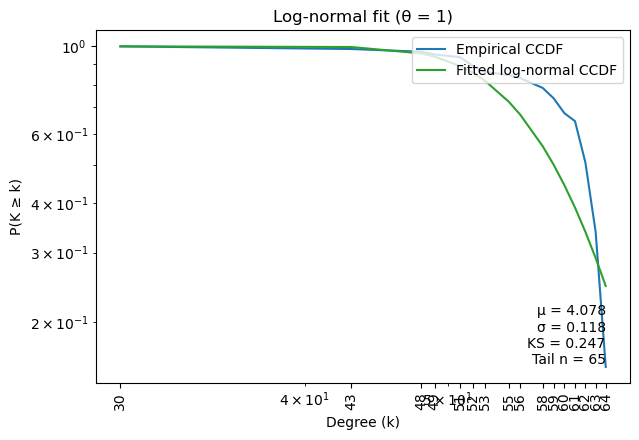

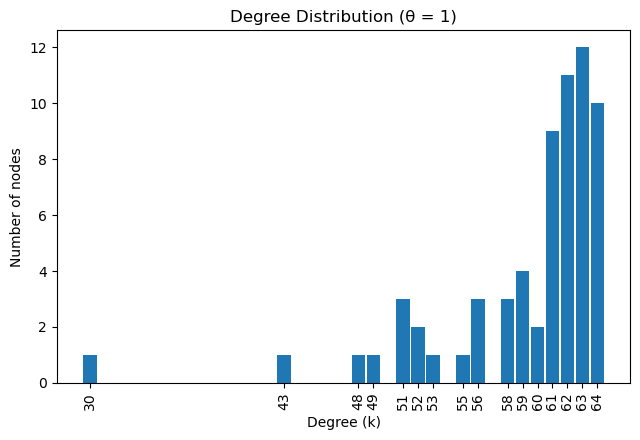

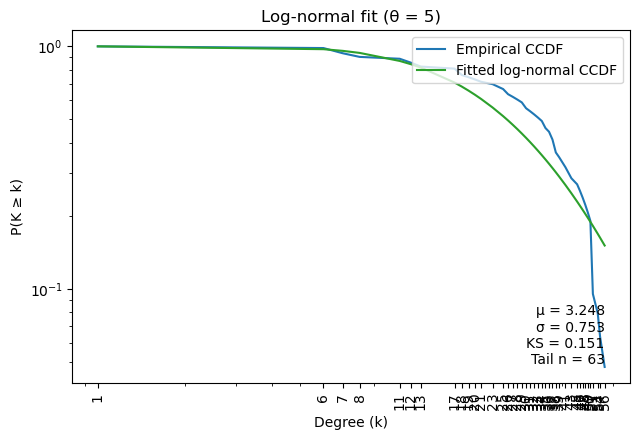

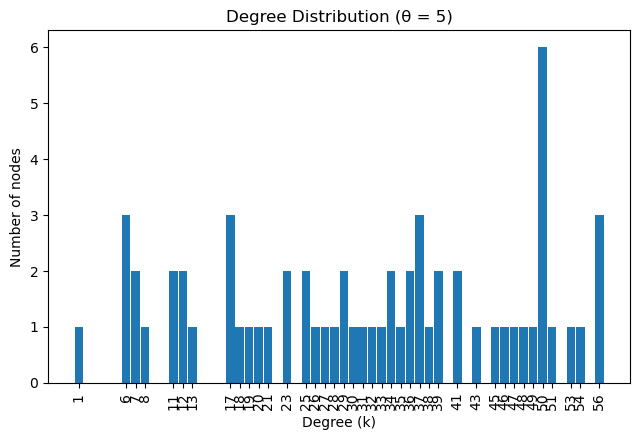

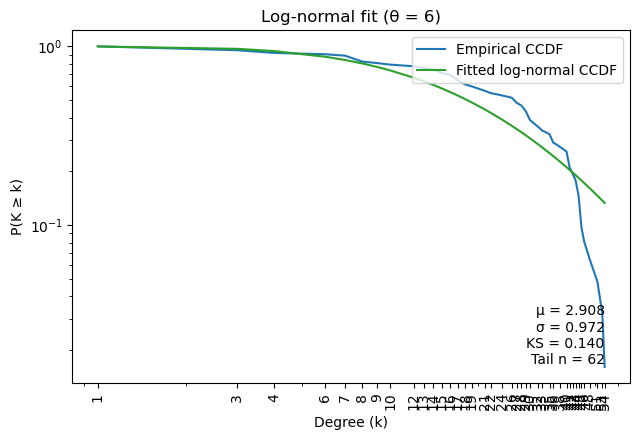

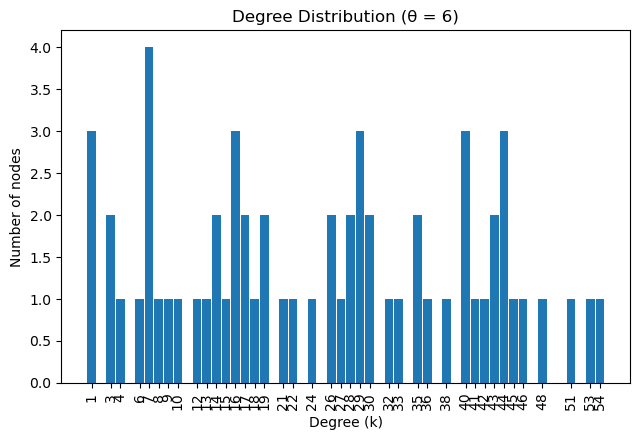

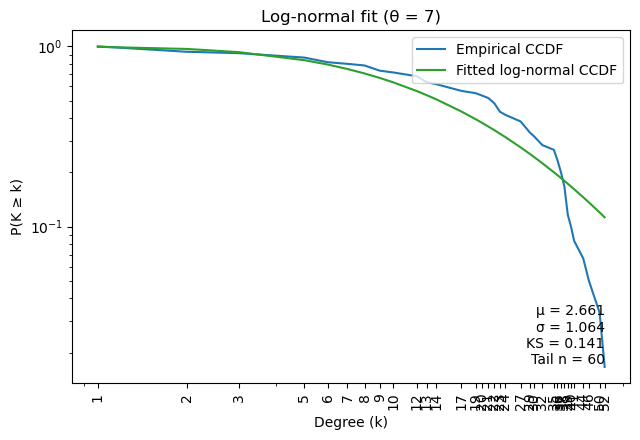

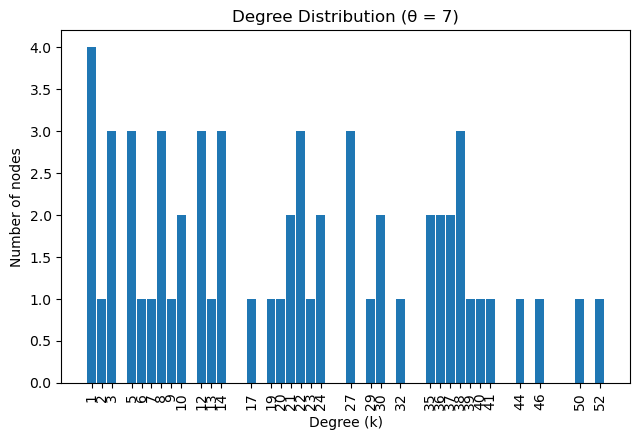

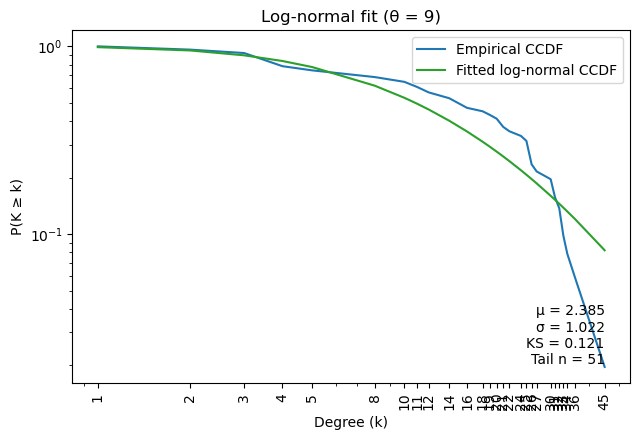

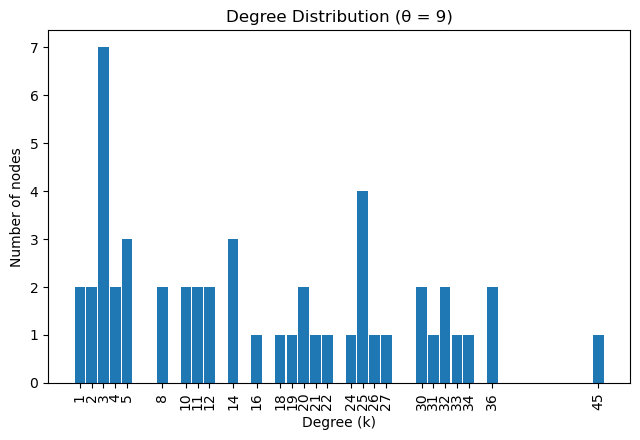

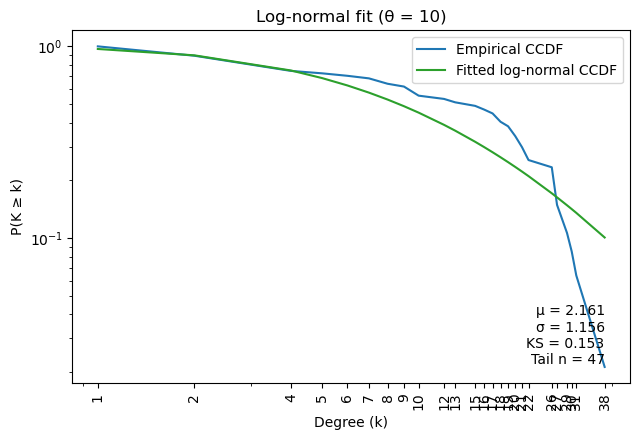

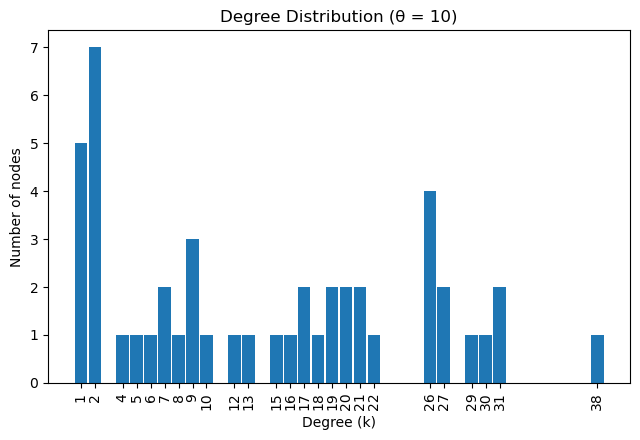

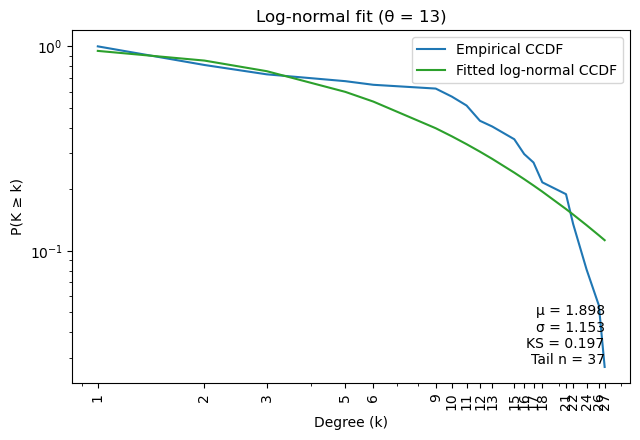

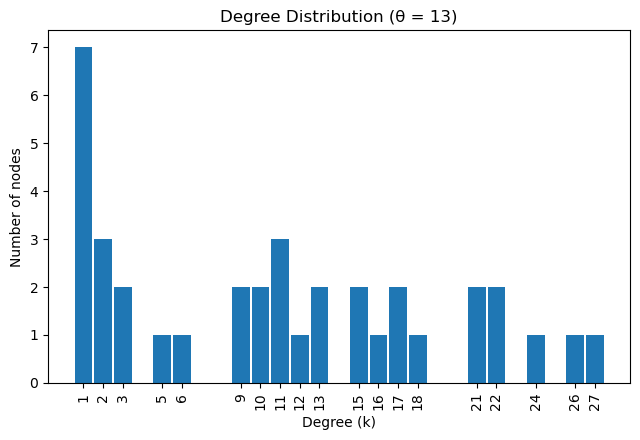

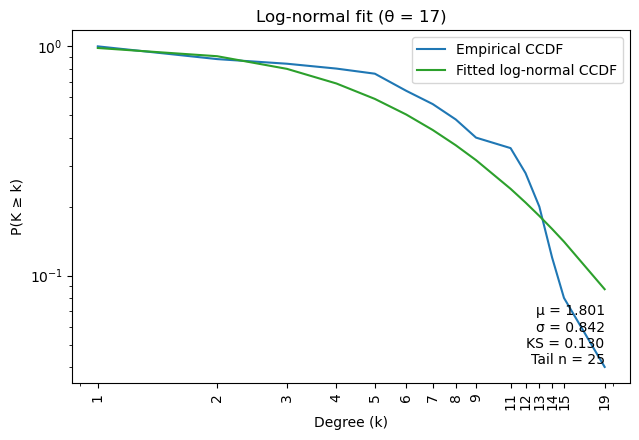

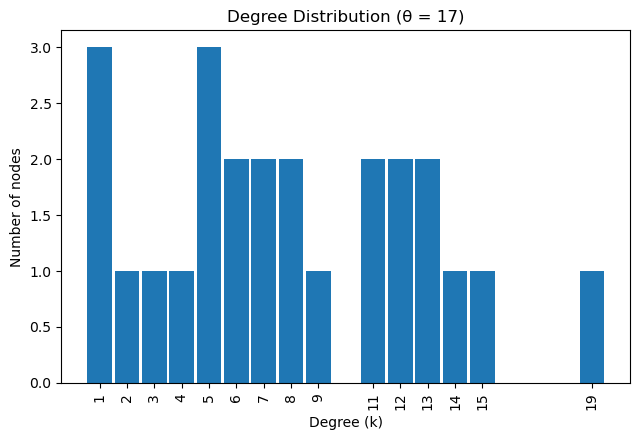

In [9]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import adjusted_rand_score as ARI
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import math
from functools import lru_cache
import scipy.stats as sps   # ✅ use sps instead of stats

# =========================
# CONFIG
# =========================
PERCENTILES = [0, 50, 60, 70, 80, 85, 90, 95]
SHOW_PLOT = False
TOP_K = 20
SEED = 42
EXPORT_CSV = None

PLOT_LOGNORMAL = True
PLOT_DEGREE_HIST = True
SAVE_PLOTS = False
PLOT_DIR = "distribution_plots"

# -------------------------------------------------------------------
# Expectation: You already have B_genus defined:
# bipartite graph with node attribute "bipartite" (0 = disease, 1 = taxa)
# -------------------------------------------------------------------

# =========================
# 1) Build weighted disease–disease projection
# =========================
diseases = {n for n, d in B_genus.nodes(data=True) if d.get("bipartite") == 0}
if not diseases:
    raise ValueError("No disease nodes found with bipartite==0 in B_genus.")

G = bipartite.weighted_projected_graph(B_genus, diseases)

# =========================
# Summary (unthresholded)
# =========================
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
deg_vals = np.array([deg for _, deg in G.degree()], dtype=float)
weights = np.array([d.get("weight", 1.0) for _, _, d in G.edges(data=True)], dtype=float)

summary = {
    "Number of nodes": num_nodes,
    "Number of edges": num_edges,
    "Degree range": (deg_vals.min(), deg_vals.max()) if deg_vals.size else None,
    "Edge weight range": (weights.min(), weights.max()) if weights.size else None,
    "Max possible edges": int(num_nodes * (num_nodes - 1) // 2),
}
print("=== Network Summary (Unthresholded) ===")
for k, v in summary.items():
    print(f"{k}: {v}")

if weights.size == 0:
    raise ValueError("Graph G has no edges.")

# =========================
# Helpers (community, stability, etc.)
# =========================
def louvain_modularity(Gw, seed=SEED):
    nodes = [n for n, d in Gw.degree() if d > 0]
    if not nodes:
        return 0.0, {}
    sub = Gw.subgraph(nodes).copy()
    comms = nx.algorithms.community.louvain_communities(sub, seed=seed, weight="weight")
    Q = nx.algorithms.community.modularity(sub, comms, weight="weight")
    labmap = {}
    for cid, cset in enumerate(comms):
        for u in cset:
            labmap[u] = cid
    return Q, labmap

def topk_degree_ranks(Gw, k=TOP_K):
    deg = dict(Gw.degree())
    if not deg:
        return pd.Series(dtype=float)
    s = pd.Series(deg).sort_values(ascending=False)
    ranks = s.rank(method="dense", ascending=False)
    out = pd.Series(0.0, index=pd.Index(Gw.nodes()))
    out.loc[ranks.index] = ranks
    top_idx = ranks[ranks <= k].index
    out.loc[~out.index.isin(top_idx)] = 0.0
    return out

def spearman_between(r1: pd.Series, r2: pd.Series):
    if r1 is None or r2 is None:
        return np.nan
    idx = r1.index.union(r2.index)
    a = r1.reindex(idx, fill_value=0)
    b = r2.reindex(idx, fill_value=0)
    return a.corr(b, method="spearman")

def ari_between(labels1: dict, labels2: dict):
    if labels1 is None or labels2 is None:
        return np.nan
    idx = set(labels1).intersection(labels2)
    if len(idx) < 2:
        return np.nan
    y1 = [labels1[i] for i in idx]
    y2 = [labels2[i] for i in idx]
    return ARI(y1, y2)

def summarize_after_threshold(G_in: nx.Graph, theta):
    Gw = G_in.copy()
    Gw.remove_edges_from([(u, v) for u, v, d in Gw.edges(data=True)
                          if d.get("weight", 0.0) < theta])
    isolates = [n for n, d in Gw.degree() if d == 0]
    Gw.remove_nodes_from(isolates)

    n_nodes = Gw.number_of_nodes()
    n_edges = Gw.number_of_edges()

    if n_nodes > 0:
        comps = list(nx.connected_components(Gw))
        gc_frac = len(max(comps, key=len)) / n_nodes if comps else 0.0
        avg_degree = float(np.mean([deg for _, deg in Gw.degree()])) if n_nodes else 0.0
        density = nx.density(Gw) if n_nodes > 1 else 0.0
        n_components = nx.number_connected_components(Gw) if n_nodes else 0
    else:
        gc_frac, avg_degree, density, n_components = 0.0, 0.0, 0.0, 0

    Q, labels = louvain_modularity(Gw, seed=SEED)
    ranks = topk_degree_ranks(Gw, k=TOP_K)

    return Gw, {
        "n_nodes": n_nodes,
        "n_edges": n_edges,
        "avg_degree": avg_degree,
        "density": density,
        "n_components": n_components,
        "gc_frac": gc_frac,
        "modularity_Q": Q,
        "ranks": ranks,
        "labels": labels,
    }

# =========================
# Empirical CCDF
# =========================
def _empirical_ccdf(data):
    x = np.sort(np.asarray(data, dtype=int))
    n = x.size
    if n == 0:
        return np.array([], dtype=int), np.array([], dtype=float)
    vals, counts = np.unique(x, return_counts=True)
    tail_counts = counts[::-1].cumsum()[::-1]
    ccdf = tail_counts / n
    return vals, ccdf

# =========================
# Log-normal fitting
# =========================
def fit_lognormal(degrees, xmin=1, min_tail_n=20):
    degrees = np.asarray(degrees, dtype=float)
    deg = degrees[np.isfinite(degrees)]
    deg = deg[deg >= xmin]
    n = deg.size
    if n < min_tail_n:
        return {"ln_mu": np.nan, "ln_sigma": np.nan, "ln_ks": np.nan,
                "ln_n_tail": 0, "ln_tail_prop": 0.0}
    
    sigma, loc, scale = sps.lognorm.fit(deg, floc=0)
    mu = np.log(scale)
    
    xs = np.sort(deg)
    emp_cdf = np.arange(1, n+1) / n
    mod_cdf = sps.lognorm.cdf(xs, s=sigma, loc=loc, scale=scale)
    ks = np.max(np.abs(emp_cdf - mod_cdf))
    
    return {
        "ln_mu": float(mu),
        "ln_sigma": float(sigma),
        "ln_ks": float(ks),
        "ln_n_tail": int(n),
        "ln_tail_prop": float(n / degrees.size if degrees.size else 0.0),
    }

# =========================
# PLOTS (with all x-ticks shown)
# =========================
def plot_lognormal_fit(theta, deg_list, ln_dict):
    mu = ln_dict["ln_mu"]
    sigma = ln_dict["ln_sigma"]
    ks = ln_dict["ln_ks"]
    n_tail = ln_dict["ln_n_tail"]

    if not np.isfinite(mu) or not np.isfinite(sigma) or n_tail == 0:
        print(f"[theta={theta}] No valid log-normal fit.")
        return
    
    deg = np.asarray(deg_list, dtype=float)
    deg = deg[deg > 0]

    xs_emp, ccdf_emp = _empirical_ccdf(deg)
    ccdf_ln = 1.0 - sps.lognorm.cdf(xs_emp, s=sigma, scale=np.exp(mu))

    plt.figure(figsize=(6.5, 4.5))
    plt.loglog(xs_emp, ccdf_emp, '-', color='tab:blue', label='Empirical CCDF')
    plt.loglog(xs_emp, ccdf_ln, '-', color='tab:green', label='Fitted log-normal CCDF')

    plt.xlabel("Degree (k)")
    plt.ylabel("P(K ≥ k)")
    plt.title(f"Log-normal fit (θ = {theta})")

    # 👉 Show ALL x-ticks (even on log scale)
    xticks = xs_emp
    plt.xticks(xticks, labels=[str(int(x)) for x in xticks], rotation=90)

    txt = f"μ = {mu:.3f}\nσ = {sigma:.3f}\nKS = {ks:.3f}\nTail n = {n_tail}"
    plt.text(xs_emp.max(), max(1e-6, ccdf_emp.min()), txt,
             ha='right', va='bottom')

    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

def plot_degree_hist_for_theta(theta, deg_list):
    deg = np.asarray(deg_list, dtype=int)
    deg = deg[np.isfinite(deg)]
    if deg.size == 0:
        print(f"[theta={theta}] No degrees to plot.")
        return
    vals, counts = np.unique(deg, return_counts=True)

    plt.figure(figsize=(6.5, 4.5))
    plt.bar(vals, counts, width=0.9)
    plt.xlabel("Degree (k)")
    plt.ylabel("Number of nodes")
    plt.title(f"Degree Distribution (θ = {theta})")

    # 👉 Show ALL integer x-ticks
    plt.xticks(vals, rotation=90)

    plt.tight_layout()
    plt.show()

# =========================
# 5) Evaluate thresholds (log-normal fit)
# =========================
integerish = np.allclose(weights, np.round(weights))
perc_vals_for_theta = np.percentile(weights, PERCENTILES)
thetas = [int(np.floor(v)) if integerish else float(v) for v in perc_vals_for_theta]
theta_unique = sorted(set(thetas))
theta_from_perc = {v: p for p, v in zip(PERCENTILES, thetas)}

rows = []
theta_to_deg = {}
theta_to_ln = {}

prev_ranks = None
prev_labels = None
baseline_Q = None

for theta in theta_unique:
    Gw, stats = summarize_after_threshold(G, theta)
    if baseline_Q is None:
        baseline_Q = stats["modularity_Q"]

    deg_list = [d for _, d in Gw.degree()]
    theta_to_deg[theta] = np.array(deg_list, dtype=int)

    ln = fit_lognormal(deg_list, xmin=1, min_tail_n=20)
    theta_to_ln[theta] = ln

    rho = spearman_between(prev_ranks, stats["ranks"]) if prev_ranks is not None else np.nan
    ari = ari_between(prev_labels, stats["labels"]) if prev_labels is not None else np.nan

    rows.append({
        "theta": theta,
        "non_isolate_frac": (stats["n_nodes"] / G.number_of_nodes()) if G.number_of_nodes() else 0.0,
        "gc_frac": stats["gc_frac"],
        "avg_degree": stats["avg_degree"],
        "density": stats["density"],
        "n_nodes": stats["n_nodes"],
        "n_edges": stats["n_edges"],
        "n_components": stats["n_components"],
        "modularity_Q": stats["modularity_Q"],
        "mod_gain_vs_baseline": stats["modularity_Q"] - baseline_Q,
        "spearman_topK_vs_prev": rho,
        "ARI_vs_prev": ari,
        # Log-normal diagnostics
        "ln_mu": ln["ln_mu"],
        "ln_sigma": ln["ln_sigma"],
        "ln_ks": ln["ln_ks"],
        "ln_n_tail": ln["ln_n_tail"],
        "ln_tail_prop": ln["ln_tail_prop"],
        "from_percentile": theta_from_perc.get(theta, pd.NA),
    })

    prev_ranks = stats["ranks"]
    prev_labels = stats["labels"]

df_theta = pd.DataFrame(rows).sort_values("theta").reset_index(drop=True)

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
pd.set_option("display.float_format", "{:,.6f}".format)

print("\n=== Percentile → θ Map ===")
for p, v in zip(PERCENTILES, perc_vals_for_theta):
    v_disp = int(np.floor(v)) if integerish else float(v)
    print(f"  {p:>3}th percentile → θ = {v_disp}")

print("\n=== Threshold Evaluation Table (log-normal fit) ===")
print(df_theta.to_string(index=False))

if EXPORT_CSV:
    df_theta.to_csv(EXPORT_CSV, index=False)
    print(f"\nSaved: {EXPORT_CSV}")

# =========================
# 6) Plots
# =========================
for theta in theta_unique:
    deg_list = theta_to_deg[theta]
    if PLOT_LOGNORMAL:
        plot_lognormal_fit(theta, deg_list, theta_to_ln[theta])
    if PLOT_DEGREE_HIST:
        plot_degree_hist_for_theta(theta, deg_list)


=== Network Summary (Unthresholded, Taxa–Taxa) ===
Number of nodes: 375
Number of edges: 23415
Degree range: (15.0, 319.0)
Edge weight range: (1.0, 18.0)

=== Percentile → θ (edge-weight) Map (Taxa–Taxa) ===
    0th percentile → θ = 1
   50th percentile → θ = 1
   60th percentile → θ = 1
   70th percentile → θ = 2
   80th percentile → θ = 2
   85th percentile → θ = 3
   90th percentile → θ = 4
   95th percentile → θ = 5

=== Threshold Evaluation Table (Taxa–Taxa; keep edges with weight ≥ θ) ===
 theta  non_isolate_frac  gc_frac  avg_degree  density  n_nodes  n_edges  n_components  modularity_Q  mod_gain_vs_baseline  spearman_topK_vs_prev  ARI_vs_prev    pl_xmin  pl_alpha    pl_ks  pl_n_tail  pl_tail_prop     pl_p  from_percentile
     1          1.000000 1.000000  124.880000 0.333904      375    23415             1      0.193871              0.000000                    NaN          NaN 100.000000  3.060500 0.103037        224      0.597333 0.580000                0
     2          0.62

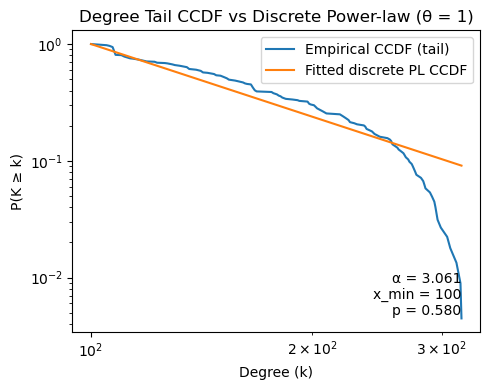

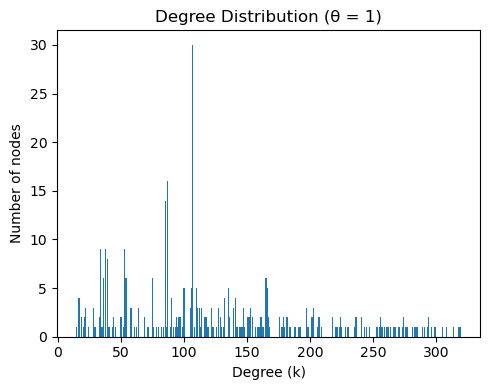

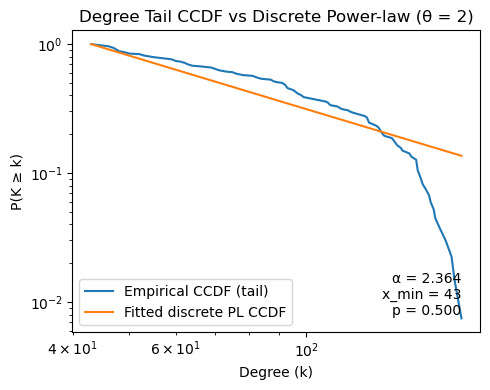

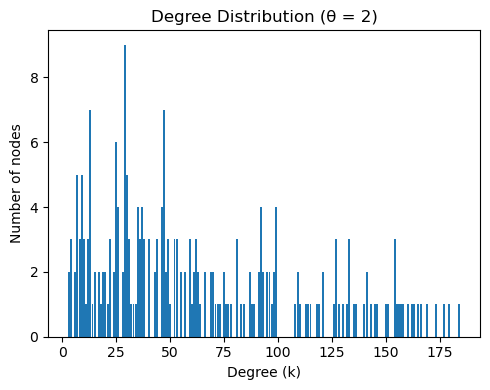

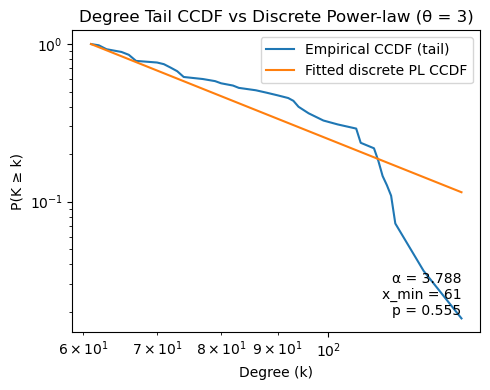

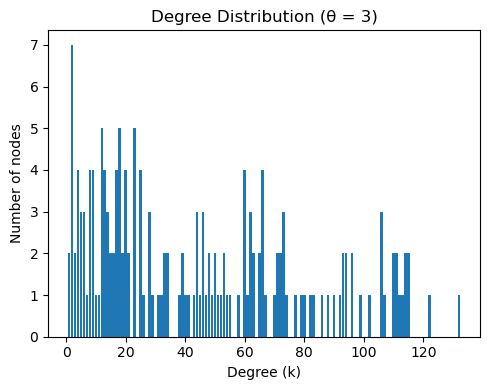

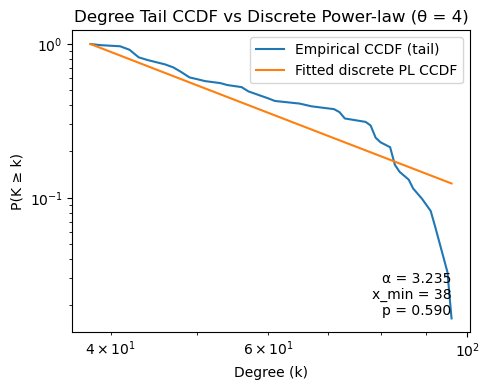

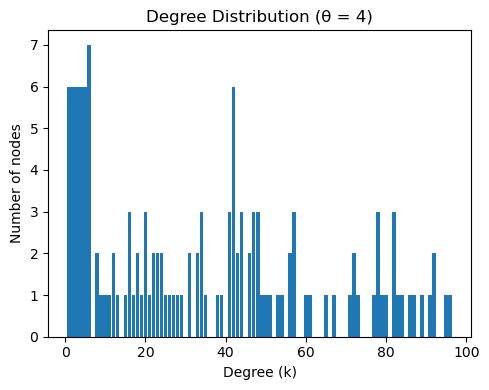

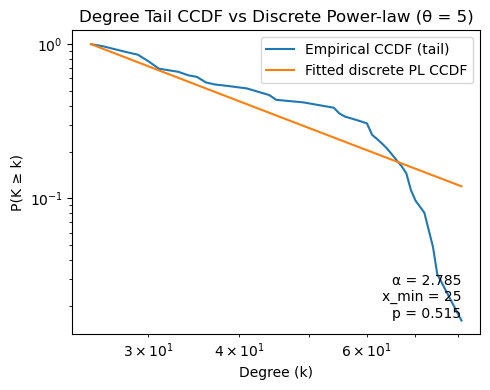

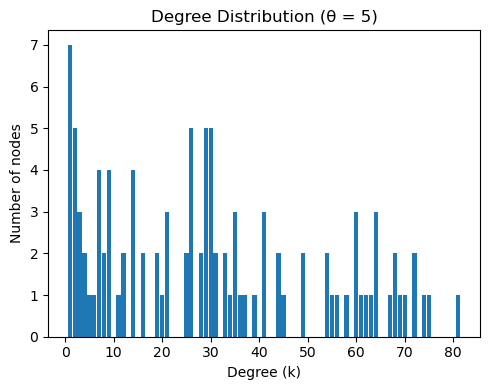

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import adjusted_rand_score as ARI
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import math
from functools import lru_cache

# Optional: exact Hurwitz zeta for discrete PL (preferred if available)
try:
    import mpmath as mp
    _HAS_MPMATH = True
    mp.mp.dps = 50  # precision
except Exception:
    _HAS_MPMATH = False
    print("[WARN] mpmath not found. Using fast discrete fallback (finite-sum + tail integral).")

# =========================
# CONFIG
# =========================
PERCENTILES = [0, 50, 60, 70, 80, 85, 90, 95]   # θ candidates from edge-weight percentiles
SHOW_PLOT = False                                # quick unthresholded visualization (optional)
TOP_K = 20                                       # for hub stability (degree ranks)
SEED = 42
EXPORT_CSV = None                                # e.g., "tt_genus_threshold_eval.csv"

# --- plotting controls for power-law diagnostics ---
PLOT_POWERLAW = True            # make CCDF plots for every theta
SAVE_PLOTS = False              # set True to save PNGs
PLOT_DIR = "powerlaw_plots_taxa"     # output folder if SAVE_PLOTS=True

# --- goodness-of-fit Monte Carlo ---
GOF_MC_REPS = 200               # increase for more stable p-values (e.g., 1000)
RANDOM_STATE = np.random.RandomState(SEED)

# -------------------------------------------------------------------
# Expectation: You already have B_genus defined in the environment:
#   - Bipartite graph with node attribute "bipartite" (0 = disease, 1 = taxa)
#   - Edges connect disease <-> taxon (genus)
#   - taxa_dict (optional) maps taxon IDs -> readable names
# -------------------------------------------------------------------

# =========================
# 1) Build weighted taxa–taxa projection from bipartite B_genus
# =========================
taxa = {n for n, d in B_genus.nodes(data=True) if d.get("bipartite") == 1}
if not taxa:
    raise ValueError("No taxa nodes found with bipartite==1 in B_genus.")

# Weighted projection: edge 'weight' == number of shared diseases
G = bipartite.weighted_projected_graph(B_genus, taxa)

# =========================
# 2) Descriptive summary (unthresholded)
# =========================
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
deg_vals = np.array([deg for _, deg in G.degree()], dtype=float)
weights = np.array([d.get("weight", 1.0) for _, _, d in G.edges(data=True)], dtype=float)

summary = {
    "Number of nodes": num_nodes,
    "Number of edges": num_edges,
    "Degree range": (float(deg_vals.min()) if deg_vals.size else None,
                     float(deg_vals.max()) if deg_vals.size else None),
    "Edge weight range": (float(weights.min()) if weights.size else None,
                          float(weights.max()) if weights.size else None),
}
print("=== Network Summary (Unthresholded, Taxa–Taxa) ===")
for k, v in summary.items():
    print(f"{k}: {v}")

if weights.size == 0:
    raise ValueError("Graph G has no edges.")

# =========================
# (Optional) quick plot (unthresholded)
# =========================
if SHOW_PLOT:
    pos = nx.spring_layout(G, seed=SEED, k=1.2)
    dmin, dmax = deg_vals.min(), deg_vals.max()
    deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
    node_sizes = 200 + deg_norm * (1000 - 200)
    node_colors = cm.get_cmap("inferno")(deg_norm)
    wmin, wmax = weights.min(), weights.max()
    w_norm = (weights - wmin) / (wmax - wmin) if wmax != wmin else np.ones_like(weights)
    edge_widths = 1.0 + 4.0 * w_norm

    try:
        labels = {n: taxa_dict.get(n, str(n)) for n in G.nodes()}
    except NameError:
        labels = {n: str(n) for n in G.nodes()}

    plt.figure(figsize=(18, 18))
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.45)
    nx.draw_networkx_nodes(G, pos, nodelist=list(G.nodes()),
                           node_size=node_sizes, node_color=node_colors, alpha=0.95)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
    plt.title("Taxa–Taxa Weighted Projection (size & color ~ degree)", fontsize=14)
    plt.axis("off")
    plt.show()

# =========================
# Helpers: community, stability, threshold summary
# =========================
def louvain_modularity(Gw, seed=SEED):
    # operate on non-isolates for meaningful communities
    nodes = [n for n, d in Gw.degree() if d > 0]
    if not nodes:
        return 0.0, {}
    sub = Gw.subgraph(nodes).copy()
    comms = nx.algorithms.community.louvain_communities(sub, seed=seed, weight="weight")
    Q = nx.algorithms.community.modularity(sub, comms, weight="weight")
    labmap = {}
    for cid, cset in enumerate(comms):
        for u in cset:
            labmap[u] = cid
    return Q, labmap

def topk_degree_ranks(Gw, k=TOP_K):
    deg = dict(Gw.degree())
    if not deg:
        return pd.Series(dtype=float)
    s = pd.Series(deg).sort_values(ascending=False)
    ranks = s.rank(method="dense", ascending=False)
    out = pd.Series(0.0, index=pd.Index(Gw.nodes()))
    out.loc[ranks.index] = ranks
    top_idx = ranks[ranks <= k].index
    out.loc[~out.index.isin(top_idx)] = 0.0
    return out

def spearman_between(r1: pd.Series, r2: pd.Series):
    if r1 is None or r2 is None:
        return np.nan
    idx = r1.index.union(r2.index)
    a = r1.reindex(idx, fill_value=0)
    b = r2.reindex(idx, fill_value=0)
    return a.corr(b, method="spearman")

def ari_between(labels1: dict, labels2: dict):
    if labels1 is None or labels2 is None:
        return np.nan
    idx = set(labels1).intersection(labels2)
    if len(idx) < 2:
        return np.nan
    y1 = [labels1[i] for i in idx]
    y2 = [labels2[i] for i in idx]
    return ARI(y1, y2)

def summarize_after_threshold(G_in: nx.Graph, theta):
    Gw = G_in.copy()
    Gw.remove_edges_from([(u, v) for u, v, d in Gw.edges(data=True)
                          if d.get("weight", 0.0) < theta])
    # remove isolates
    isolates = [n for n, d in Gw.degree() if d == 0]
    Gw.remove_nodes_from(isolates)

    n_nodes = Gw.number_of_nodes()
    n_edges = Gw.number_of_edges()

    if n_nodes > 0:
        comps = list(nx.connected_components(Gw))
        gc_frac = len(max(comps, key=len)) / n_nodes if comps else 0.0
        avg_degree = float(np.mean([deg for _, deg in Gw.degree()])) if n_nodes else 0.0
        density = nx.density(Gw) if n_nodes > 1 else 0.0
        n_components = nx.number_connected_components(Gw) if n_nodes else 0
    else:
        gc_frac, avg_degree, density, n_components = 0.0, 0.0, 0.0, 0

    Q, labels = louvain_modularity(Gw, seed=SEED)
    ranks = topk_degree_ranks(Gw, k=TOP_K)

    return Gw, {
        "n_nodes": n_nodes,
        "n_edges": n_edges,
        "avg_degree": avg_degree,
        "density": density,
        "n_components": n_components,
        "gc_frac": gc_frac,
        "modularity_Q": Q,
        "ranks": ranks,
        "labels": labels,
    }

# =========================
# Discrete power-law helpers (tail only)
# =========================
def _empirical_ccdf(data):
    """
    Return sorted unique integer x and empirical CCDF(x) for data array.
    CCDF at value v is P(X >= v).
    """
    x = np.sort(np.asarray(data, dtype=int))
    n = x.size
    if n == 0:
        return np.array([], dtype=int), np.array([], dtype=float)
    vals, counts = np.unique(x, return_counts=True)
    tail_counts = counts[::-1].cumsum()[::-1]
    ccdf = tail_counts / n
    return vals, ccdf

@lru_cache(maxsize=100000)
def _discrete_zeta_cached(alpha_x1000, xmin):
    """
    Cached helper for ζ(alpha, xmin) to speed up repeated calls.
    alpha_x1000 is int(alpha*1000) to make it hashable-stable for caching.
    """
    alpha = alpha_x1000 / 1000.0
    xmin = int(xmin)
    if _HAS_MPMATH:
        return float(mp.zeta(alpha, xmin))
    # Fallback: partial sum + integral tail
    K = 100000
    s = 0.0
    for k in range(xmin, xmin + K):
        s += k ** (-alpha)
    x0 = xmin + K - 0.5
    if alpha > 1:
        s += (x0 ** (1 - alpha)) / (alpha - 1)
    return s

def _discrete_zeta(alpha, xmin):
    # wrapper to use cache (quantize alpha to 3 decimals for speed)
    return _discrete_zeta_cached(int(round(float(alpha) * 1000)), int(xmin))

def _negloglik_discrete(alpha, data, xmin):
    """
    -log L for discrete PL: L ∝ ∏ [x_i^{-alpha} / ζ(alpha, xmin)]
    data must be >= xmin (integers).
    """
    alpha = float(alpha)
    if alpha <= 1.0:
        return np.inf

    data = np.asarray(data, dtype=int)
    if data.size == 0:
        return np.inf

    z = _discrete_zeta(alpha, int(xmin))
    if not np.isfinite(z) or z <= 0:
        return np.inf

    s_logx = float(np.sum(np.log(data)))
    return len(data) * math.log(z) + alpha * s_logx

def _mle_alpha_discrete(data, xmin):
    """
    Pure discrete MLE using Hurwitz zeta (or its fallback) via -logL minimization.
    Golden-section search on alpha ∈ [1.01, 6.0].
    """
    data = np.asarray(data, dtype=int)
    data = data[data >= int(xmin)]
    if data.size == 0:
        return np.nan

    # Golden-section search
    a_lo, a_hi = 1.01, 6.0

    def nll(a):
        return _negloglik_discrete(a, data, int(xmin))

    phi = (1 + 5 ** 0.5) / 2
    invphi = 1 / phi
    tol = 1e-7
    a, b = a_lo, a_hi
    c = b - invphi * (b - a)
    d = a + invphi * (b - a)
    fc = nll(c)
    fd = nll(d)

    it = 0
    while abs(b - a) > tol and it < 200:
        if fc < fd:
            b, d, fd = d, c, fc
            c = b - invphi * (b - a)
            fc = nll(c)
        else:
            a, c, fc = c, d, fd
            d = a + invphi * (b - a)
            fd = nll(d)
        it += 1
    return (a + b) / 2.0

def fit_powerlaw_degree_tail_discrete(degrees, xmin_candidates="unique", adapt_tail=True,
                                      min_tail_n=20, tail_frac_floor=0.05, tail_n_cap=50):
    """
    Discrete power-law fit to the degree tail:
      - candidate xmin chosen from unique integer degree values
      - for each xmin, fit alpha by maximizing discrete likelihood with Hurwitz zeta
      - choose xmin minimizing KS distance between empirical CDF and model CDF
      - adaptive tail-size requirement keeps fitting stable at high θ

    Returns dict with pl_xmin, pl_alpha, pl_ks, pl_n_tail, pl_tail_prop
    """
    deg = np.asarray(list(degrees), dtype=int)
    deg = deg[np.isfinite(deg)]
    deg = deg[deg > 0]  # ignore zeros for tail
    if deg.size == 0:
        return {"pl_xmin": np.nan, "pl_alpha": np.nan, "pl_ks": np.nan,
                "pl_n_tail": 0, "pl_tail_prop": 0.0}

    n_total = deg.size

    # candidate xmins
    if xmin_candidates == "unique":
        cands = np.unique(deg)
    else:
        cands = np.array(sorted({int(c) for c in xmin_candidates if c > 0}), dtype=int)
        if cands.size == 0:
            cands = np.unique(deg)

    # adaptive minimum tail size
    if adapt_tail:
        min_tail_n = max(10, min(tail_n_cap, int(max(min_tail_n, tail_frac_floor * n_total))))

    best = {"pl_xmin": np.nan, "pl_alpha": np.nan, "pl_ks": np.inf,
            "pl_n_tail": 0, "pl_tail_prop": 0.0}

    for xmin in cands:
        tail = deg[deg >= xmin]
        n_tail = tail.size
        if n_tail < min_tail_n:
            continue

        alpha = _mle_alpha_discrete(tail, xmin)
        if not np.isfinite(alpha) or alpha <= 1.0:
            continue

        # Empirical CDF on tail support (integers)
        xs = np.sort(np.unique(tail))
        counts = np.array([(tail <= v).sum() for v in xs], dtype=float) / n_tail  # empirical CDF

        # Model CDF at integer x: F(x) = 1 - S(x+1)/S(xmin), where S(q) = ζ(alpha, q)
        denom = _discrete_zeta(alpha, xmin)
        S_xp1 = np.array([_discrete_zeta(alpha, int(v) + 1) for v in xs])
        F_pl = 1.0 - (S_xp1 / denom)

        ks = float(np.max(np.abs(counts - F_pl)))
        if ks < best["pl_ks"]:
            best.update({
                "pl_xmin": float(xmin),
                "pl_alpha": float(alpha),
                "pl_ks": float(ks),
                "pl_n_tail": int(n_tail),
                "pl_tail_prop": float(n_tail / n_total),
            })

    if not np.isfinite(best["pl_ks"]) or best["pl_ks"] == np.inf:
        return {"pl_xmin": np.nan, "pl_alpha": np.nan, "pl_ks": np.nan,
                "pl_n_tail": 0, "pl_tail_prop": 0.0}

    return best

def discrete_ccdf_model(xs_int, xmin, alpha):
    """
    Model CCDF for discrete power-law at integer support xs_int (k >= xmin):
      CCDF(k) = P(X >= k) = ζ(alpha, k) / ζ(alpha, xmin)
    """
    xs_int = np.asarray(xs_int, dtype=int)
    denom = _discrete_zeta(alpha, int(xmin))
    num = np.array([_discrete_zeta(alpha, int(k)) for k in xs_int])
    return num / denom

def _cdf_discrete_pl(k, alpha, xmin):
    """F(k) for discrete PL at integer k (k >= xmin)."""
    denom = _discrete_zeta(alpha, int(xmin))
    return 1.0 - (_discrete_zeta(alpha, int(k) + 1) / denom)

def _sample_discrete_powerlaw(alpha, xmin, size, rng):
    """
    Inverse-CDF sampling by binary search on integer support [xmin, ∞):
    F(k) = 1 - ζ(alpha, k+1)/ζ(alpha, xmin). Works with Hurwitz zeta.
    """
    samples = np.empty(size, dtype=int)
    # upper bracket: start at observed xmin and expand until F(hi) ~ 1.0 for given u
    for i in range(size):
        u = rng.uniform()
        lo = int(xmin)
        hi = lo
        while _cdf_discrete_pl(hi, alpha, xmin) < u:
            hi *= 2
            if hi > 10**7:  # emergency cap
                break
        while lo < hi:
            mid = (lo + hi) // 2
            if _cdf_discrete_pl(mid, alpha, xmin) >= u:
                hi = mid
            else:
                lo = mid + 1
        samples[i] = lo
    return samples

def ks_stat_empirical_vs_model_tail(tail, alpha, xmin):
    """KS distance between empirical CDF of tail and fitted discrete PL CDF at integer support."""
    tail = np.asarray(tail, dtype=int)
    n = tail.size
    xs = np.sort(np.unique(tail))
    empF = np.array([(tail <= v).sum() for v in xs], dtype=float) / n
    modF = np.array([_cdf_discrete_pl(int(v), alpha, int(xmin)) for v in xs], dtype=float)
    return float(np.max(np.abs(empF - modF)))

def gof_pvalue_discrete_pl_refit(tail, reps=GOF_MC_REPS, rng=RANDOM_STATE):
    """
    CSN-style GOF p-value for discrete PL:
      1) Fit (xmin_hat, alpha_hat) on the empirical tail.
      2) Compute KS_emp between empirical tail CDF and model CDF at (xmin_hat, alpha_hat).
      3) For each replicate:
         a) Simulate n samples from PL(alpha_hat, xmin_hat).
         b) Re-fit (xmin*, alpha*) to the synthetic data using the same procedure.
         c) Compute KS_sim between synthetic data and its own fitted model.
      4) p = mean(KS_sim >= KS_emp).
    """
    tail = np.asarray(tail, dtype=int)
    n = tail.size
    if n == 0:
        return np.nan

    # --- Fit on empirical tail ---
    fit_emp = fit_powerlaw_degree_tail_discrete(tail, xmin_candidates="unique", adapt_tail=True)
    xmin_hat, alpha_hat = fit_emp["pl_xmin"], fit_emp["pl_alpha"]
    if not (np.isfinite(xmin_hat) and np.isfinite(alpha_hat) and fit_emp["pl_n_tail"] > 0):
        return np.nan

    KS_emp = ks_stat_empirical_vs_model_tail(tail, alpha_hat, int(round(xmin_hat)))

    # --- Simulate + refit ---
    ks_sims = np.empty(int(reps), dtype=float)
    xmin_i = int(round(xmin_hat))
    for i in range(int(reps)):
        sim = _sample_discrete_powerlaw(alpha_hat, xmin_i, n, rng)
        fit_sim = fit_powerlaw_degree_tail_discrete(sim, xmin_candidates="unique", adapt_tail=True)
        xmins, alphas = fit_sim["pl_xmin"], fit_sim["pl_alpha"]
        if not (np.isfinite(xmins) and np.isfinite(alphas) and fit_sim["pl_n_tail"] > 0):
            ks_sims[i] = np.nan
            continue
        ks_sims[i] = ks_stat_empirical_vs_model_tail(sim, alphas, int(round(xmins)))

    ks_sims = ks_sims[np.isfinite(ks_sims)]
    if ks_sims.size == 0:
        return np.nan
    return float((ks_sims >= KS_emp).mean())

def plot_powerlaw_fit_for_theta(theta, deg_list, pl_dict):
    """
    Log-log plot of empirical degree CCDF (tail) and the fitted DISCRETE power-law CCDF.
    One figure per theta. Annotates ONLY alpha/xmin/p.
    """
    xmin = pl_dict["pl_xmin"]
    alpha = pl_dict["pl_alpha"]
    n_tail = pl_dict["pl_n_tail"]
    pval = pl_dict.get("pl_p", np.nan)

    if not np.isfinite(xmin) or not np.isfinite(alpha) or n_tail == 0:
        print(f"[theta={theta}] No valid discrete power-law tail to plot.")
        return

    deg = np.asarray(deg_list, dtype=int)
    xmin_i = int(round(xmin))
    tail = deg[deg >= xmin_i]

    xs_emp, ccdf_emp = _empirical_ccdf(tail)
    ccdf_pl = discrete_ccdf_model(xs_emp, xmin_i, float(alpha))

    plt.figure(figsize=(5, 4))
    plt.loglog(xs_emp, ccdf_emp, linestyle='-', label='Empirical CCDF (tail)')
    plt.loglog(xs_emp, ccdf_pl, linestyle='-', label='Fitted discrete PL CCDF')

    plt.xlabel("Degree (k)")
    plt.ylabel("P(K ≥ k)")
    plt.title(f"Degree Tail CCDF vs Discrete Power-law (θ = {theta})")

    if np.isfinite(pval):
        txt = f"α = {alpha:.3f}\nx_min = {xmin_i}\np = {pval:.3f}"
    else:
        txt = f"α = {alpha:.3f}\nx_min = {xmin_i}\np = NA"

    x_right = xs_emp.max()
    y_bottom = max(1e-6, float(min(ccdf_emp.min(), ccdf_pl.min())))
    plt.text(x_right, y_bottom, txt, ha='right', va='bottom')

    plt.legend()
    plt.tight_layout()

    if SAVE_PLOTS:
        os.makedirs(PLOT_DIR, exist_ok=True)
        out = os.path.join(PLOT_DIR, f"pl_ccdf_theta_{theta}.png")
        plt.savefig(out, dpi=200)
        print(f"Saved: {out}")

    plt.show()

# --- add near your plotting controls ---
PLOT_DEGREE_HIST = True        # make degree distribution bar plots for every theta

# =========================
# NEW: degree-distribution bar plot (per θ)
# =========================
def plot_degree_hist_for_theta(theta, deg_list):
    """
    Bar plot of degree (k) vs number of nodes with that degree, for a given θ.
    Works on the post-threshold graph's degree list (isolates already removed).
    """
    deg = np.asarray(deg_list, dtype=int)
    deg = deg[np.isfinite(deg)]
    if deg.size == 0:
        print(f"[theta={theta}] No degrees to plot.")
        return

    vals, counts = np.unique(deg, return_counts=True)

    plt.figure(figsize=(5, 4))
    plt.bar(vals, counts, width=0.9, align='center')
    plt.xlabel("Degree (k)")
    plt.ylabel("Number of nodes")
    plt.title(f"Degree Distribution (θ = {theta})")
    plt.tight_layout()

    if SAVE_PLOTS:
        os.makedirs(PLOT_DIR, exist_ok=True)
        out = os.path.join(PLOT_DIR, f"degree_hist_theta_{theta}.png")
        plt.savefig(out, dpi=200)
        print(f"Saved: {out}")

    plt.show()

# =========================
# 5) Percentile-based θ evaluation (with metrics + discrete power-law)
# =========================
integerish = np.allclose(weights, np.round(weights))
perc_vals_for_theta = np.percentile(weights, PERCENTILES)
thetas = [int(np.floor(v)) if integerish else float(v) for v in perc_vals_for_theta]
theta_unique = sorted(set(thetas))

theta_from_perc = {}
for p, v in zip(PERCENTILES, thetas):
    theta_from_perc.setdefault(v, p)

rows = []
prev_ranks = None
prev_labels = None
baseline_Q = None

theta_to_deg = {}
theta_to_pl = {}

for theta in theta_unique:
    Gw, stats = summarize_after_threshold(G, theta)

    if baseline_Q is None:
        baseline_Q = stats["modularity_Q"]

    deg_list = [d for _, d in Gw.degree()]
    pl = fit_powerlaw_degree_tail_discrete(
        deg_list,
        xmin_candidates="unique",
        adapt_tail=True,
        min_tail_n=20,
        tail_frac_floor=0.05,
        tail_n_cap=50
    )

    if np.isfinite(pl["pl_xmin"]) and np.isfinite(pl["pl_alpha"]) and pl["pl_n_tail"] > 0:
        deg_arr = np.asarray(deg_list, dtype=int)
        tail = deg_arr[deg_arr >= int(round(pl["pl_xmin"]))]
        pl["pl_p"] = gof_pvalue_discrete_pl_refit(tail, reps=GOF_MC_REPS, rng=RANDOM_STATE)
    else:
        pl["pl_p"] = np.nan

    theta_to_deg[theta] = np.array(deg_list, dtype=int)
    theta_to_pl[theta] = pl

    rho = spearman_between(prev_ranks, stats["ranks"]) if prev_ranks is not None else np.nan
    ari = ari_between(prev_labels, stats["labels"]) if prev_labels is not None else np.nan

    rows.append({
        "theta": theta,
        "non_isolate_frac": (stats["n_nodes"] / G.number_of_nodes()) if G.number_of_nodes() else 0.0,
        "gc_frac": stats["gc_frac"],
        "avg_degree": stats["avg_degree"],
        "density": stats["density"],
        "n_nodes": stats["n_nodes"],
        "n_edges": stats["n_edges"],
        "n_components": stats["n_components"],
        "modularity_Q": stats["modularity_Q"],
        "mod_gain_vs_baseline": stats["modularity_Q"] - baseline_Q,
        "spearman_topK_vs_prev": rho,
        "ARI_vs_prev": ari,
        # Power-law diagnostics (discrete)
        "pl_xmin": pl["pl_xmin"],
        "pl_alpha": pl["pl_alpha"],
        "pl_ks": pl["pl_ks"],
        "pl_n_tail": pl["pl_n_tail"],
        "pl_tail_prop": pl["pl_tail_prop"],
        "pl_p": pl["pl_p"],
        "from_percentile": theta_from_perc.get(theta, pd.NA),
    })

    prev_ranks = stats["ranks"]
    prev_labels = stats["labels"]

df_theta = pd.DataFrame(rows).sort_values("theta").reset_index(drop=True)

# Pretty table
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
pd.set_option("display.float_format", "{:,.6f}".format)

print("\n=== Percentile → θ (edge-weight) Map (Taxa–Taxa) ===")
for p, v in zip(PERCENTILES, perc_vals_for_theta):
    v_disp = int(np.floor(v)) if integerish else float(v)
    print(f"  {p:>3}th percentile → θ = {v_disp}")

print("\n=== Threshold Evaluation Table (Taxa–Taxa; keep edges with weight ≥ θ) ===")
print(df_theta.to_string(index=False))

if EXPORT_CSV:
    df_theta.to_csv(EXPORT_CSV, index=False)
    print(f"\nSaved: {EXPORT_CSV}")

# =========================
# 6) Plot discrete power-law fits AND degree histograms for all thresholds
# =========================
if PLOT_POWERLAW or PLOT_DEGREE_HIST:
    for theta in theta_unique:
        deg_list = theta_to_deg[theta]
        if PLOT_POWERLAW:
            pl = theta_to_pl[theta]
            plot_powerlaw_fit_for_theta(theta, deg_list, pl)
        if PLOT_DEGREE_HIST:
            plot_degree_hist_for_theta(theta, deg_list)


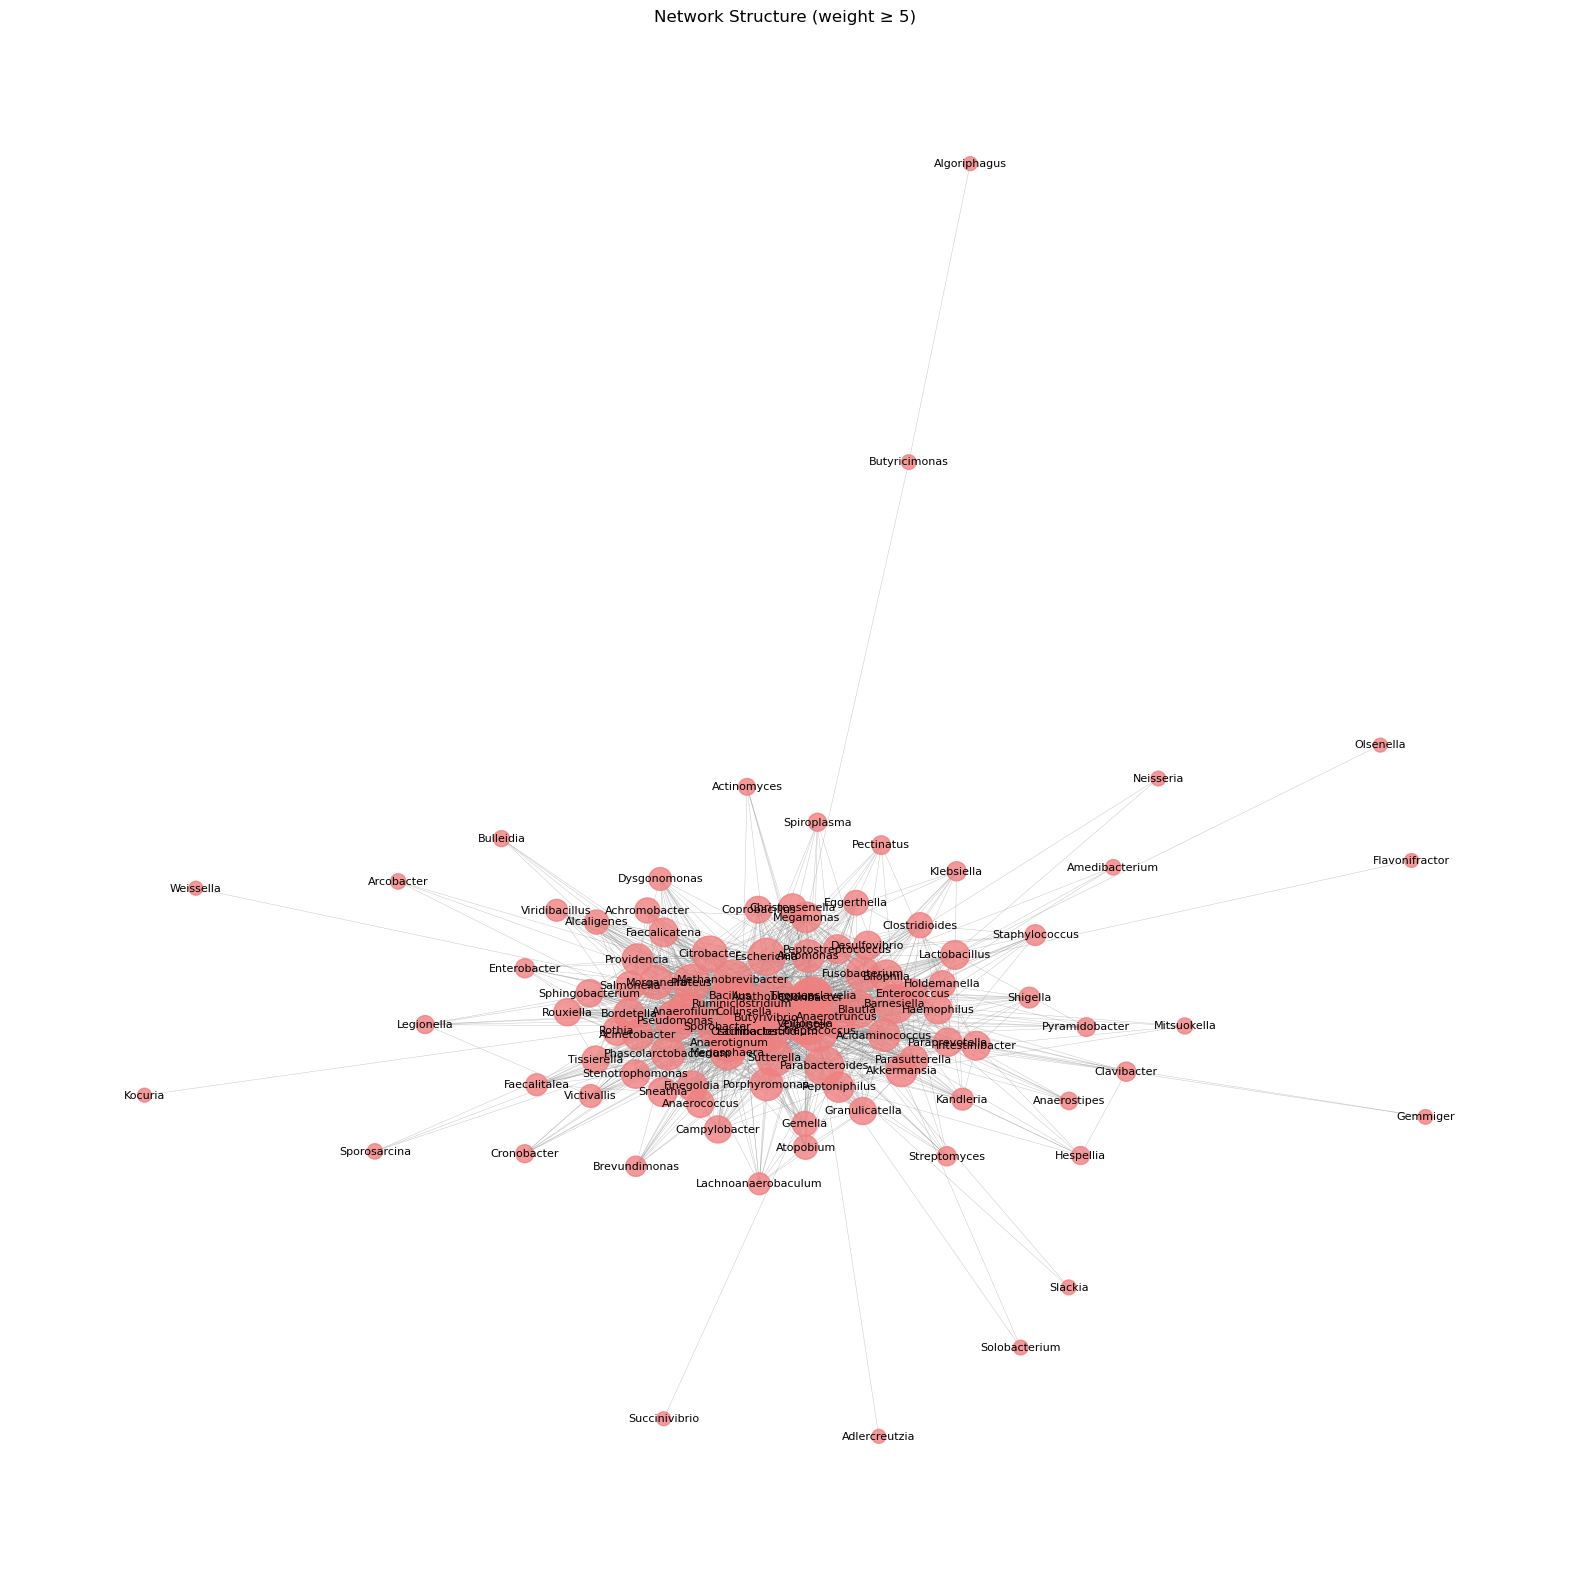

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# === User-defined threshold ===
edge_weight_threshold = 5 # change this to your cutoff

# === Step 1: Apply edge weight filtering ===
if edge_weight_threshold > 0:
    G_filtered = nx.Graph()
    for u, v, data in G.edges(data=True):
        weight = data.get("weight", 1)  # default weight = 1 if not present
        if weight >= edge_weight_threshold:
            G_filtered.add_edge(u, v, **data)
else:
    G_filtered = G.copy()

# If you don't already have pos from a previous cell, compute it here:
pos = nx.spring_layout(G_filtered, seed=42)

# Map node IDs to readable labels from taxon_dict
labels = {n: taxon_dict.get(n, str(n)) for n in G_filtered.nodes()}

# --- Node sizes: normalize degree to [0,1] then map to pixel range ---
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)

min_size, max_size = 100, 1000
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Plot ---
plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(G_filtered, pos, node_size=node_sizes, node_color='lightcoral', alpha=0.8)
nx.draw_networkx_edges(G_filtered, pos, width=0.3, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_filtered, pos, labels=labels, font_size=8)

plt.title(f"Network Structure (weight ≥ {edge_weight_threshold})")
plt.axis('off')
plt.show()


/tmp/slurm.4613945/ipykernel_29315/2262940826.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", max(len(used_categories), 1))
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


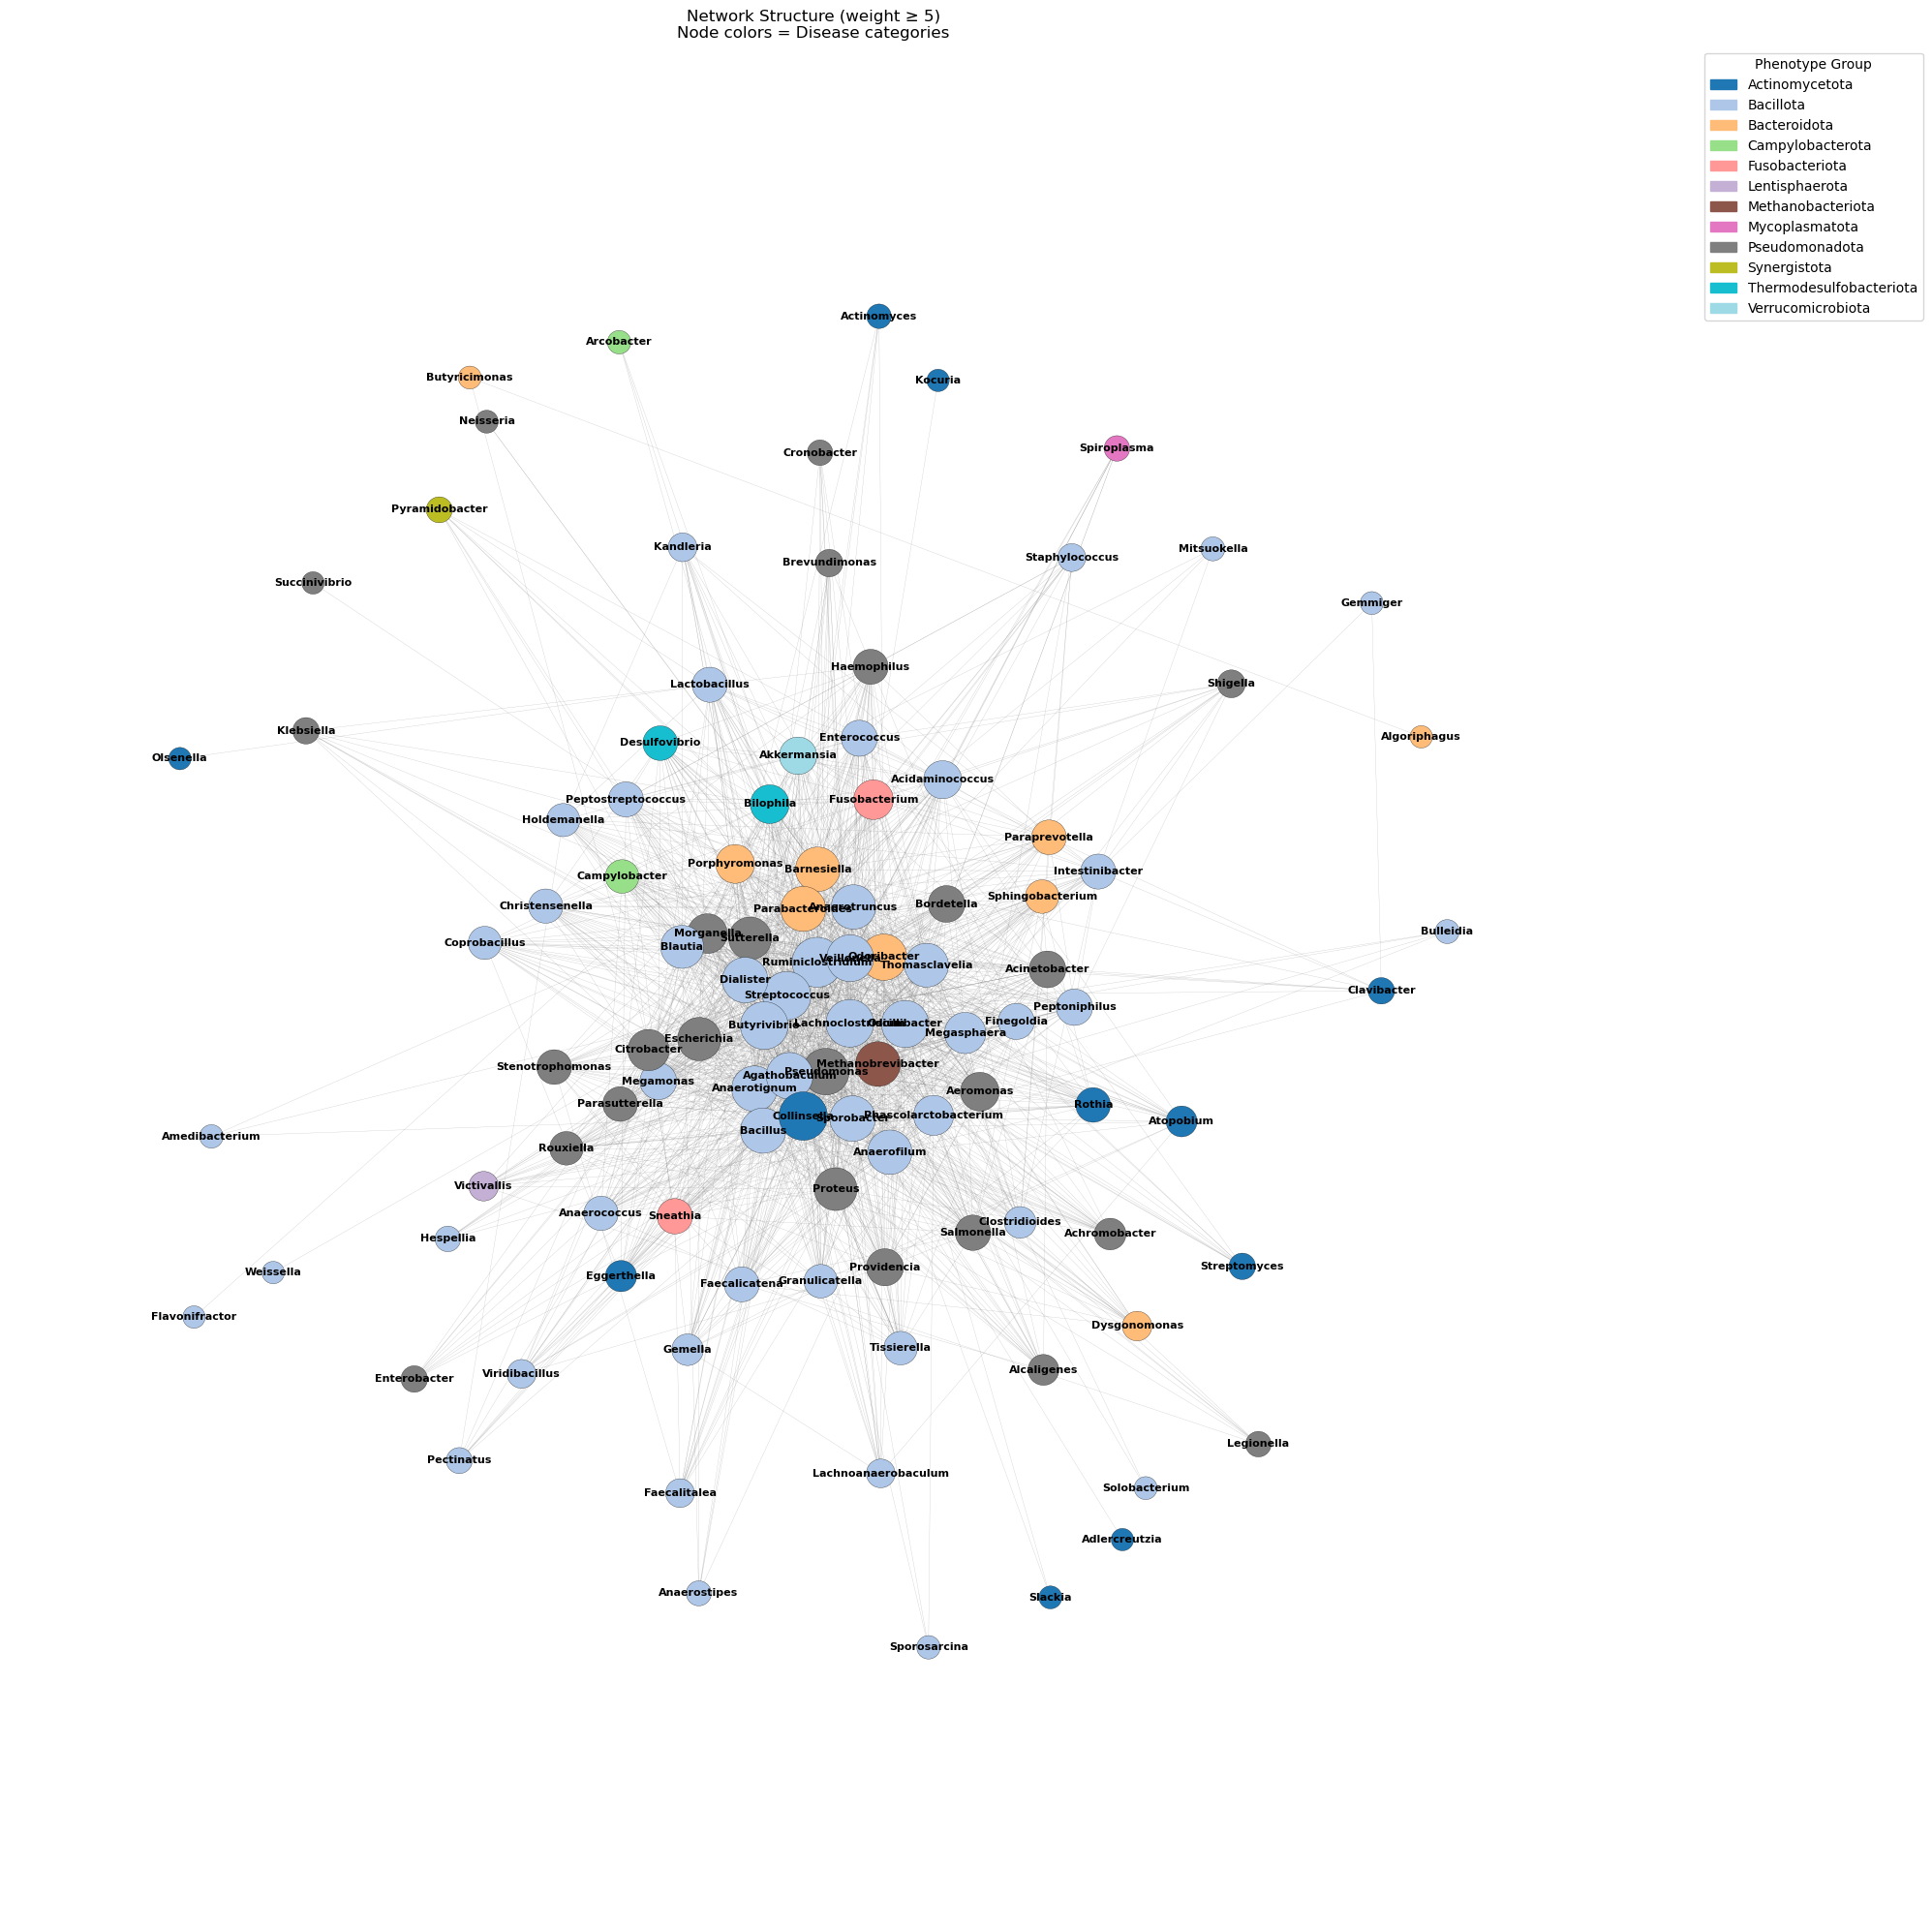

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np

# Ensure all node IDs are strings to match dictionary keys
G_filtered = nx.relabel_nodes(G_filtered, {n: str(n) for n in G_filtered.nodes()})
taxon_category_by_id = {str(k): ([str(c) for c in v] if isinstance(v, list) else [str(v)])
                        for k, v in taxon_category_by_id.items()}

# --- Layout & labels ---
pos = nx.spring_layout(G_filtered, seed=42, k=2)

# Scale the layout outward without recalculating
scale_factor = 4.0
pos = {n: (x * scale_factor, y * scale_factor) for n, (x, y) in pos.items()}

labels = {n: taxon_dict.get(n, str(n)) for n in G_filtered.nodes()}

# --- Node size from degree ---
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
min_size, max_size = 200, 1000
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Normalize categories per node ---
node_cats = {}
for n in G_filtered.nodes():
    cats = taxon_category_by_id.get(n, [])
    if not cats or not isinstance(cats, list):
        cats = ["(Unclassified)"]
    cats = [str(c).strip() if c else "(Unclassified)" for c in cats]
    node_cats[n] = cats

# --- Used categories ---
used_categories = sorted({c for cats in node_cats.values() for c in cats})

# --- Color map for categories ---
cmap = plt.cm.get_cmap("tab20", max(len(used_categories), 1))
category_colors = {cat: cmap(i) for i, cat in enumerate(used_categories)}

# --- Figure & axis ---
fig, ax = plt.subplots(figsize=(20, 20))

# Draw edges
nx.draw_networkx_edges(G_filtered, pos, width=0.2, alpha=0.5, ax=ax, edge_color="gray")

# Axis limits from positions
xs = np.array([p[0] for p in pos.values()])
ys = np.array([p[1] for p in pos.values()])
pad_x = (xs.max() - xs.min()) * 0.10
pad_y = (ys.max() - ys.min()) * 0.10
ax.set_xlim(xs.min() - pad_x, xs.max() + pad_x)
ax.set_ylim(ys.min() - pad_y, ys.max() + pad_y)
ax.set_aspect('equal', adjustable='datalim')

# Convert node size to radius in data coords
def points2data_radius(ax, size_pts2):
    r_pts = np.sqrt(size_pts2 / np.pi)          # points
    r_px = r_pts * (fig.dpi / 72.0)             # pixels
    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    dx_per_px = (x1 - x0) / ax.bbox.width
    dy_per_px = (y1 - y0) / ax.bbox.height
    return r_px * 0.5 * (dx_per_px + dy_per_px)

# Draw nodes as pie slices
for size, n in zip(node_sizes, G_filtered.nodes()):
    cats = node_cats[n]
    r = points2data_radius(ax, size)
    x, y = pos[n]
    k = len(cats)
    for j, cat in enumerate(cats):
        theta1 = 360.0 * j / k
        theta2 = 360.0 * (j + 1) / k
        wedge = mpatches.Wedge(
            (x, y), r, theta1, theta2,
            facecolor=category_colors.get(cat, "lightgray"),
            edgecolor="black", lw=0.2, zorder=2
        )
        ax.add_patch(wedge)

# Labels
nx.draw_networkx_labels(G_filtered, pos, labels=labels, font_size=8, ax=ax, font_weight='bold')

# Title
ax.set_title(f"Network Structure (weight ≥ {edge_weight_threshold})\nNode colors = Disease categories")
ax.axis('off')

# Legend
legend_handles = [mpatches.Patch(color=category_colors[c], label=c) for c in used_categories]
ax.legend(handles=legend_handles, title="Phenotype Group", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
import networkx as nx
import pandas as pd
import community as community_louvain  # Louvain community detection

# --- Helper: Get name from disease_dict if available ---
def get_name(node):
    return taxon_dict.get(node, str(node))

# --- Centrality Measures ---
metrics = {}

# Degree (raw connections)
metrics['Degree'] = dict(G_filtered.degree())

# Degree Centrality (normalized by max possible degree)
metrics['Degree Centrality'] = nx.degree_centrality(G_filtered)

# Closeness Centrality (inverse of avg shortest path to all others)
metrics['Closeness Centrality'] = nx.closeness_centrality(G_filtered)

# Betweenness Centrality (how often a node is on shortest paths)
metrics['Betweenness Centrality'] = nx.betweenness_centrality(G_filtered)

# Eigenvector Centrality (importance via connected important nodes)
try:
    metrics['Eigenvector Centrality'] = nx.eigenvector_centrality(G_filtered, max_iter=1000)
except nx.NetworkXError:
    metrics['Eigenvector Centrality'] = {}

# PageRank (random walk importance)
metrics['PageRank'] = nx.pagerank(G_filtered)

# Harmonic Centrality (closeness variant that handles disconnected graphs)
metrics['Harmonic Centrality'] = nx.harmonic_centrality(G_filtered)

# --- Convert to DataFrame for easy viewing ---
df_metrics = pd.DataFrame(metrics).rename(index=get_name)

# --- Sort and print top 10 for each metric ---
for metric in metrics.keys():
    print(f"\n=== {metric} ===")
    if metric == "Degree":
        print("What it means: Number of direct connections a node has.")
    elif metric == "Degree Centrality":
        print("What it means: Fraction of all possible nodes a node is connected to.")
    elif metric == "Closeness Centrality":
        print("What it means: How close a node is to all others (higher = shorter distances).")
    elif metric == "Betweenness Centrality":
        print("What it means: How often a node acts as a bridge along the shortest path between two other nodes.")
    elif metric == "Eigenvector Centrality":
        print("What it means: Importance of a node based on being connected to other important nodes.")
    elif metric == "PageRank":
        print("What it means: Probability of landing on a node during a random walk (like Google's ranking).")
    elif metric == "Harmonic Centrality":
        print("What it means: Closeness-like measure that handles disconnected graphs better.")

    top10 = df_metrics[metric].sort_values(ascending=False).head(10)
    for name, value in top10.items():
        print(f"{name:40} {value:.4f}")

# --- Global Network Properties ---
print("\n=== Global Network Properties ===")
print(f"Number of nodes: {G_filtered.number_of_nodes()}")
print(f"Number of edges: {G_filtered.number_of_edges()}")
print(f"Density: {nx.density(G_filtered):.4f} - Fraction of possible edges present.")
print(f"Average clustering coefficient: {nx.average_clustering(G_filtered):.4f} - Tendency to form triangles.")
print(f"Transitivity: {nx.transitivity(G_filtered):.4f} - Ratio of triangles to connected triples.")

# Diameter & avg path length only if graph is connected
if nx.is_connected(G_filtered):
    print(f"Diameter: {nx.diameter(G_filtered)} - Longest shortest path.")
    print(f"Average path length: {nx.average_shortest_path_length(G_filtered):.4f} - Mean distance between nodes.")
else:
    print("Graph is disconnected: Diameter and average path length are undefined.")

# --- Community Detection (Louvain) ---
partition = community_louvain.best_partition(G_filtered)
modularity = community_louvain.modularity(partition, G_filtered)
print(f"Modularity (Louvain): {modularity:.4f} - Strength of community structure (higher = more distinct communities).")

# Print top 5 largest communities
from collections import Counter
community_counts = Counter(partition.values())
print("Top 5 community sizes:", community_counts.most_common(5))



=== Degree ===
What it means: Number of direct connections a node has.
Ruminiclostridium                        81.0000
Collinsella                              75.0000
Streptococcus                            74.0000
Lachnoclostridium                        72.0000
Butyrivibrio                             72.0000
Oscillibacter                            70.0000
Veillonella                              69.0000
Pseudomonas                              68.0000
Agathobaculum                            68.0000
Odoribacter                              67.0000

=== Degree Centrality ===
What it means: Fraction of all possible nodes a node is connected to.
Ruminiclostridium                        0.7714
Collinsella                              0.7143
Streptococcus                            0.7048
Lachnoclostridium                        0.6857
Butyrivibrio                             0.6857
Oscillibacter                            0.6667
Veillonella                              0.6571
Pseud

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
from collections import Counter

# Dummy placeholders for G_filtered and taxon_dict for syntax validation.
# These should be defined in the actual environment where the graph is constructed.
# G_filtered = nx.Graph()  # Replace with your filtered graph
# taxon_dict = {}          # Replace with your actual mapping

# --- Helper: Get name from taxon_dict if available ---
def get_name(node):
    return taxon_dict.get(node, str(node))

# --- Centrality Measures ---
metrics = {
    'Degree': dict(G_filtered.degree()),
    'Degree Centrality': nx.degree_centrality(G_filtered),
    'Closeness Centrality': nx.closeness_centrality(G_filtered),
    'Betweenness Centrality': nx.betweenness_centrality(G_filtered),
    'PageRank': nx.pagerank(G_filtered),
    'Harmonic Centrality': nx.harmonic_centrality(G_filtered)
}

# Try Eigenvector Centrality
try:
    metrics['Eigenvector Centrality'] = nx.eigenvector_centrality(G_filtered, max_iter=1000)
except nx.NetworkXError:
    metrics['Eigenvector Centrality'] = {}

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics).rename(index=get_name)

# --- Descriptive Statistics ---
desc_stats = df_metrics.describe(percentiles=[.25, .5, .75, .9, .95, .99]).T
desc_stats['range'] = df_metrics.max() - df_metrics.min()
desc_stats['max_node'] = df_metrics.idxmax()
desc_stats['max_value'] = df_metrics.max()

# Sort by median values
desc_stats_sorted = desc_stats.sort_values(by='50%', ascending=False)

# Also prepare a table of top nodes in descending order for each metric
top_nodes_per_metric = {}
for metric in df_metrics.columns:
    sorted_nodes = df_metrics[metric].sort_values(ascending=False)
    top_nodes_per_metric[metric] = sorted_nodes

# --- Global Network Properties ---
global_props = {
    'Number of nodes': G_filtered.number_of_nodes(),
    'Number of edges': G_filtered.number_of_edges(),
    'Density': nx.density(G_filtered),
    'Average clustering coefficient': nx.average_clustering(G_filtered),
    'Transitivity': nx.transitivity(G_filtered),
    'Is connected': nx.is_connected(G_filtered)
}

if global_props['Is connected']:
    global_props['Diameter'] = nx.diameter(G_filtered)
    global_props['Average path length'] = nx.average_shortest_path_length(G_filtered)

desc_stats_sorted, top_nodes_per_metric, global_props


(                            count      mean       std       min       25%       50%       75%       90%       95%       99%       max     range           max_node  max_value
 Harmonic Centrality    106.000000 65.424214 13.489605 29.983333 54.625000 65.833333 74.458333 84.166667 87.083333 89.808333 92.833333 62.850000  Ruminiclostridium  92.833333
 Degree                 106.000000 30.037736 22.777150  1.000000  9.000000 28.500000 44.750000 64.000000 69.750000 74.950000 81.000000 80.000000  Ruminiclostridium  81.000000
 Closeness Centrality   106.000000  0.563370  0.104526  0.274151  0.486111  0.555571  0.627807  0.709459  0.739437  0.771777  0.807692  0.533541  Ruminiclostridium   0.807692
 Degree Centrality      106.000000  0.286074  0.216925  0.009524  0.085714  0.271429  0.426190  0.609524  0.664286  0.713810  0.771429  0.761905  Ruminiclostridium   0.771429
 Eigenvector Centrality 106.000000  0.080654  0.054376  0.000052  0.027663  0.082350  0.122035  0.158449  0.165600  0.173727 

In [ ]:
import json
import networkx as nx
import pandas as pd

# --- Load dictionaries ---
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/taxon_dict.json", "r") as f:
    taxon_dict = json.load(f)

with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/taxon_phyla_dict.json", "r") as f:
    taxon_category_by_id = json.load(f)

# --- Compute centrality metrics on your genus-level graph ---
metrics = {
    "Degree": dict(G_filtered.degree()),
    "Degree Centrality": nx.degree_centrality(G_filtered),
    "Closeness Centrality": nx.closeness_centrality(G_filtered),
    "Betweenness Centrality": nx.betweenness_centrality(G_filtered, normalized=True),
    "Eigenvector Centrality": nx.eigenvector_centrality(G_filtered, max_iter=1000),
    "PageRank": nx.pagerank(G_filtered),
    "Harmonic Centrality": nx.harmonic_centrality(G_filtered)
}

# --- Build DataFrame ---
df = pd.DataFrame(metrics)

# Map genus + phylum from dicts
df["Genus"] = df.index.map(lambda x: taxon_dict.get(str(x), str(x)))
df["Phylum"] = df.index.map(lambda x: taxon_category_by_id.get(str(x), "Unknown"))

# Reorder columns
df = df[["Genus", "Phylum"] + list(metrics.keys())]

# Add ranks for each metric
for col in metrics.keys():
    df[col + " Rank"] = df[col].rank(method="min", ascending=False)

# Sort by degree for readability (optional, you can skip)
df_sorted = df.sort_values("Degree", ascending=False)

# --- Display the whole DataFrame in notebook ---
pd.set_option("display.max_rows", None)   # show all 106 nodes
pd.set_option("display.max_columns", None)  # show all measures + ranks
pd.set_option("display.width", None)  
pd.set_option("display.max_colwidth", None)

df_sorted


Genus                   Phylum  Degree  \
1508657      Ruminiclostridium                Bacillota      81   
102106             Collinsella           Actinomycetota      75   
1301             Streptococcus                Bacillota      74   
1506553      Lachnoclostridium                Bacillota      72   
830               Butyrivibrio                Bacillota      72   
459786           Oscillibacter                Bacillota      70   
29465              Veillonella                Bacillota      69   
286                Pseudomonas           Pseudomonadota      68   
2048137          Agathobaculum                Bacillota      68   
283168             Odoribacter             Bacteroidota      67   
44748              Sporobacter                Bacillota      64   
39948                Dialister                Bacillota      64   
2039240           Anaerotignum                Bacillota      64   
1386                  Bacillus                Bacillota      63   
375288         Parabacteroides             Bacteroidota      62   
2172        Methanobrevibacter        Methanobacteriota      61   
52784              Anaerofilum                Bacillota      60   
397864             Barnesiella             Bacteroidota      60   
244127           Anaerotruncus                Bacillota      60   
1505663         Thomasclavelia                Bacillota      58   
561                Escherichia           Pseudomonadota      56   
572511                 Blautia                Bacillota      55   
40544               Sutterella           Pseudomonadota      54   
583                    Proteus           Pseudomonadota      54   
544                Citrobacter           Pseudomonadota      49   
906                Megasphaera                Bacillota      49   
33024    Phascolarctobacterium                Bacillota      45   
848              Fusobacterium           Fusobacteriota      44   
581                 Morganella           Pseudomonadota      44   
836              Porphyromonas             Bacteroidota      41   
642                  Aeromonas           Pseudomonadota      41   
35832                Bilophila  Thermodesulfobacteriota      41   
904            Acidaminococcus                Bacillota      39   
239934             Akkermansia        Verrucomicrobiota      37   
586                Providencia           Pseudomonadota      36   
158846               Megamonas                Bacillota      35   
517                 Bordetella           Pseudomonadota      35   
469              Acinetobacter           Pseudomonadota      35   
162289           Peptoniphilus                Bacillota      34   
1350              Enterococcus                Bacillota      33   
150022              Finegoldia                Bacillota      33   
590                 Salmonella           Pseudomonadota      31   
168808                Sneathia           Fusobacteriota      31   
724                Haemophilus           Pseudomonadota      30   
1257        Peptostreptococcus                Bacillota      30   
1578             Lactobacillus                Bacillota      30   
1505657        Intestinibacter                Bacillota      30   
2005359          Faecalicatena                Bacillota      30   
577310          Parasutterella           Pseudomonadota      29   
32207                   Rothia           Actinomycetota      29   
577309          Paraprevotella             Bacteroidota      29   
872              Desulfovibrio  Thermodesulfobacteriota      29   
40323         Stenotrophomonas           Pseudomonadota      29   
165779            Anaerococcus                Bacillota      28   
990721         Christensenella                Bacillota      28   
28453         Sphingobacterium             Bacteroidota      26   
41273              Tissierella                Bacillota      26   
194              Campylobacter         Campylobacterota      26   
117563          Granulicatella                Bacillota      26   
15655

In [ ]:
# --- Summary statistics for all centrality measures ---
summary = df.drop(columns=["Genus", "Phylum"]).describe(
    percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
).T

# Add range and median explicitly
summary["range"] = summary["max"] - summary["min"]
summary["median"] = df.drop(columns=["Genus", "Phylum"]).median()

# --- Display results ---
print("\n===== Node-level metrics (all genera) =====\n")
display(df_sorted)  # full DataFrame with genus + phylum + all centralities + ranks

print("\n===== Summary statistics for each metric =====\n")
display(summary)



===== Node-level metrics (all genera) =====



Genus                   Phylum  Degree  \
1508657      Ruminiclostridium                Bacillota      81   
102106             Collinsella           Actinomycetota      75   
1301             Streptococcus                Bacillota      74   
1506553      Lachnoclostridium                Bacillota      72   
830               Butyrivibrio                Bacillota      72   
459786           Oscillibacter                Bacillota      70   
29465              Veillonella                Bacillota      69   
286                Pseudomonas           Pseudomonadota      68   
2048137          Agathobaculum                Bacillota      68   
283168             Odoribacter             Bacteroidota      67   
44748              Sporobacter                Bacillota      64   
39948                Dialister                Bacillota      64   
2039240           Anaerotignum                Bacillota      64   
1386                  Bacillus                Bacillota      63   
375288         Parabacteroides             Bacteroidota      62   
2172        Methanobrevibacter        Methanobacteriota      61   
52784              Anaerofilum                Bacillota      60   
397864             Barnesiella             Bacteroidota      60   
244127           Anaerotruncus                Bacillota      60   
1505663         Thomasclavelia                Bacillota      58   
561                Escherichia           Pseudomonadota      56   
572511                 Blautia                Bacillota      55   
40544               Sutterella           Pseudomonadota      54   
583                    Proteus           Pseudomonadota      54   
544                Citrobacter           Pseudomonadota      49   
906                Megasphaera                Bacillota      49   
33024    Phascolarctobacterium                Bacillota      45   
848              Fusobacterium           Fusobacteriota      44   
581                 Morganella           Pseudomonadota      44   
836              Porphyromonas             Bacteroidota      41   
642                  Aeromonas           Pseudomonadota      41   
35832                Bilophila  Thermodesulfobacteriota      41   
904            Acidaminococcus                Bacillota      39   
239934             Akkermansia        Verrucomicrobiota      37   
586                Providencia           Pseudomonadota      36   
158846               Megamonas                Bacillota      35   
517                 Bordetella           Pseudomonadota      35   
469              Acinetobacter           Pseudomonadota      35   
162289           Peptoniphilus                Bacillota      34   
1350              Enterococcus                Bacillota      33   
150022              Finegoldia                Bacillota      33   
590                 Salmonella           Pseudomonadota      31   
168808                Sneathia           Fusobacteriota      31   
724                Haemophilus           Pseudomonadota      30   
1257        Peptostreptococcus                Bacillota      30   
1578             Lactobacillus                Bacillota      30   
1505657        Intestinibacter                Bacillota      30   
2005359          Faecalicatena                Bacillota      30   
577310          Parasutterella           Pseudomonadota      29   
32207                   Rothia           Actinomycetota      29   
577309          Paraprevotella             Bacteroidota      29   
872              Desulfovibrio  Thermodesulfobacteriota      29   
40323         Stenotrophomonas           Pseudomonadota      29   
165779            Anaerococcus                Bacillota      28   
990721         Christensenella                Bacillota      28   
28453         Sphingobacterium             Bacteroidota      26   
41273              Tissierella                Bacillota      26   
194              Campylobacter         Campylobacterota      26   
117563          Granulicatella                Bacillota      26   
15655


===== Summary statistics for each metric =====



count      mean       std       min  \
Degree                      106.000000 30.037736 22.777150  1.000000   
Degree Centrality           106.000000  0.286074  0.216925  0.009524   
Closeness Centrality        106.000000  0.563370  0.104526  0.274151   
Betweenness Centrality      106.000000  0.008083  0.014269  0.000000   
Eigenvector Centrality      106.000000  0.080654  0.054376  0.000052   
PageRank                    106.000000  0.009434  0.007404  0.001588   
Harmonic Centrality         106.000000 65.424214 13.489605 29.983333   
Degree Rank                 106.000000 52.452830 30.237199  1.000000   
Degree Centrality Rank      106.000000 52.452830 30.237199  1.000000   
Closeness Centrality Rank   106.000000 53.103774 30.773807  1.000000   
Betweenness Centrality Rank 106.000000 50.669811 26.973257  1.000000   
Eigenvector Centrality Rank 106.000000 53.500000 30.743563  1.000000   
PageRank Rank               106.000000 53.500000 30.743563  1.000000   
Harmonic Centrality Rank    106.000000 53.386792 30.790094  1.000000   

                                  25%       50%       75%       90%  \
Degree                       9.000000 28.500000 44.750000 64.000000   
Degree Centrality            0.085714  0.271429  0.426190  0.609524   
Closeness Centrality         0.486111  0.555571  0.627807  0.709459   
Betweenness Centrality       0.000005  0.000526  0.012900  0.024076   
Eigenvector Centrality       0.027663  0.082350  0.122035  0.158449   
PageRank                     0.003309  0.007291  0.013016  0.021201   
Harmonic Centrality         54.625000 65.833333 74.458333 84.166667   
Degree Rank                 27.250000 51.500000 78.000000 95.000000   
Degree Centrality Rank      27.250000 51.500000 78.000000 95.000000   
Closeness Centrality Rank   27.250000 52.500000 79.000000 95.500000   
Betweenness Centrality Rank 27.250000 53.500000 79.750000 82.000000   
Eigenvector Centrality Rank 27.250000 53.500000 79.750000 95.500000   
PageRank Rank               27.250000 53.500000 79.750000 95.500000   
Harmonic Centrality Rank    27.250000 53.000000 79.750000 95.500000   

                                   95%        99%        max      range  \
Degree                       69.750000  74.950000  81.000000  80.000000   
Degree Centrality             0.664286   0.713810   0.771429   0.761905   
Closeness Centrality          0.739437   0.771777   0.807692   0.533541   
Betweenness Centrality        0.038326   0.061726   0.070550   0.070550   
Eigenvector Centrality        0.165600   0.173727   0.178763   0.178710   
PageRank                      0.024156   0.026900   0.030376   0.028787   
Harmonic Centrality          87.083333  89.808333  92.833333  62.850000   
Degree Rank                 100.000000 100.000000 100.000000  99.000000   
Degree Centrality Rank      100.000000 100.000000 100.000000  99.000000   
Closeness Centrality Rank   100.750000 104.000000 106.000000 105.000000   
Betweenness Centrality Rank  82.000000  82.000000  82.000000  81.000000   
Eigenvector Centrality Rank 100.750000 104.950000 106.000000 105.000000   
PageRank Rank               100.750000 104.950000 106.000000 105.000000   
Harmonic Centrality Rank    100.750000 104.950000 106.000000 105.000000   

                               median  
Degree                      28.500000  
Degree Centrality            0.271429  
Closeness Centrality         0.555571  
Betweenness Centrality       0.000526  
Eigenvector Centrality       0.082350  
PageRank                     0.007291  
Harmonic Centrality         65.833333  
Degree Rank                 51.500000  
Degree Centrality Rank      51.500000  
Closeness Centrality Rank   52.500000  
Betweenness Centrality Rank 53.500000  
Eigenvector Centrality Rank 53.500000  
PageRank Rank               53.500000  
Harmonic Centrality Rank    53.000000

In [ ]:
nx.is_connected(G_filtered)


True

/tmp/slurm.4613945/ipykernel_29315/559317107.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(used_categories) if len(used_categories) > 0 else 1)
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


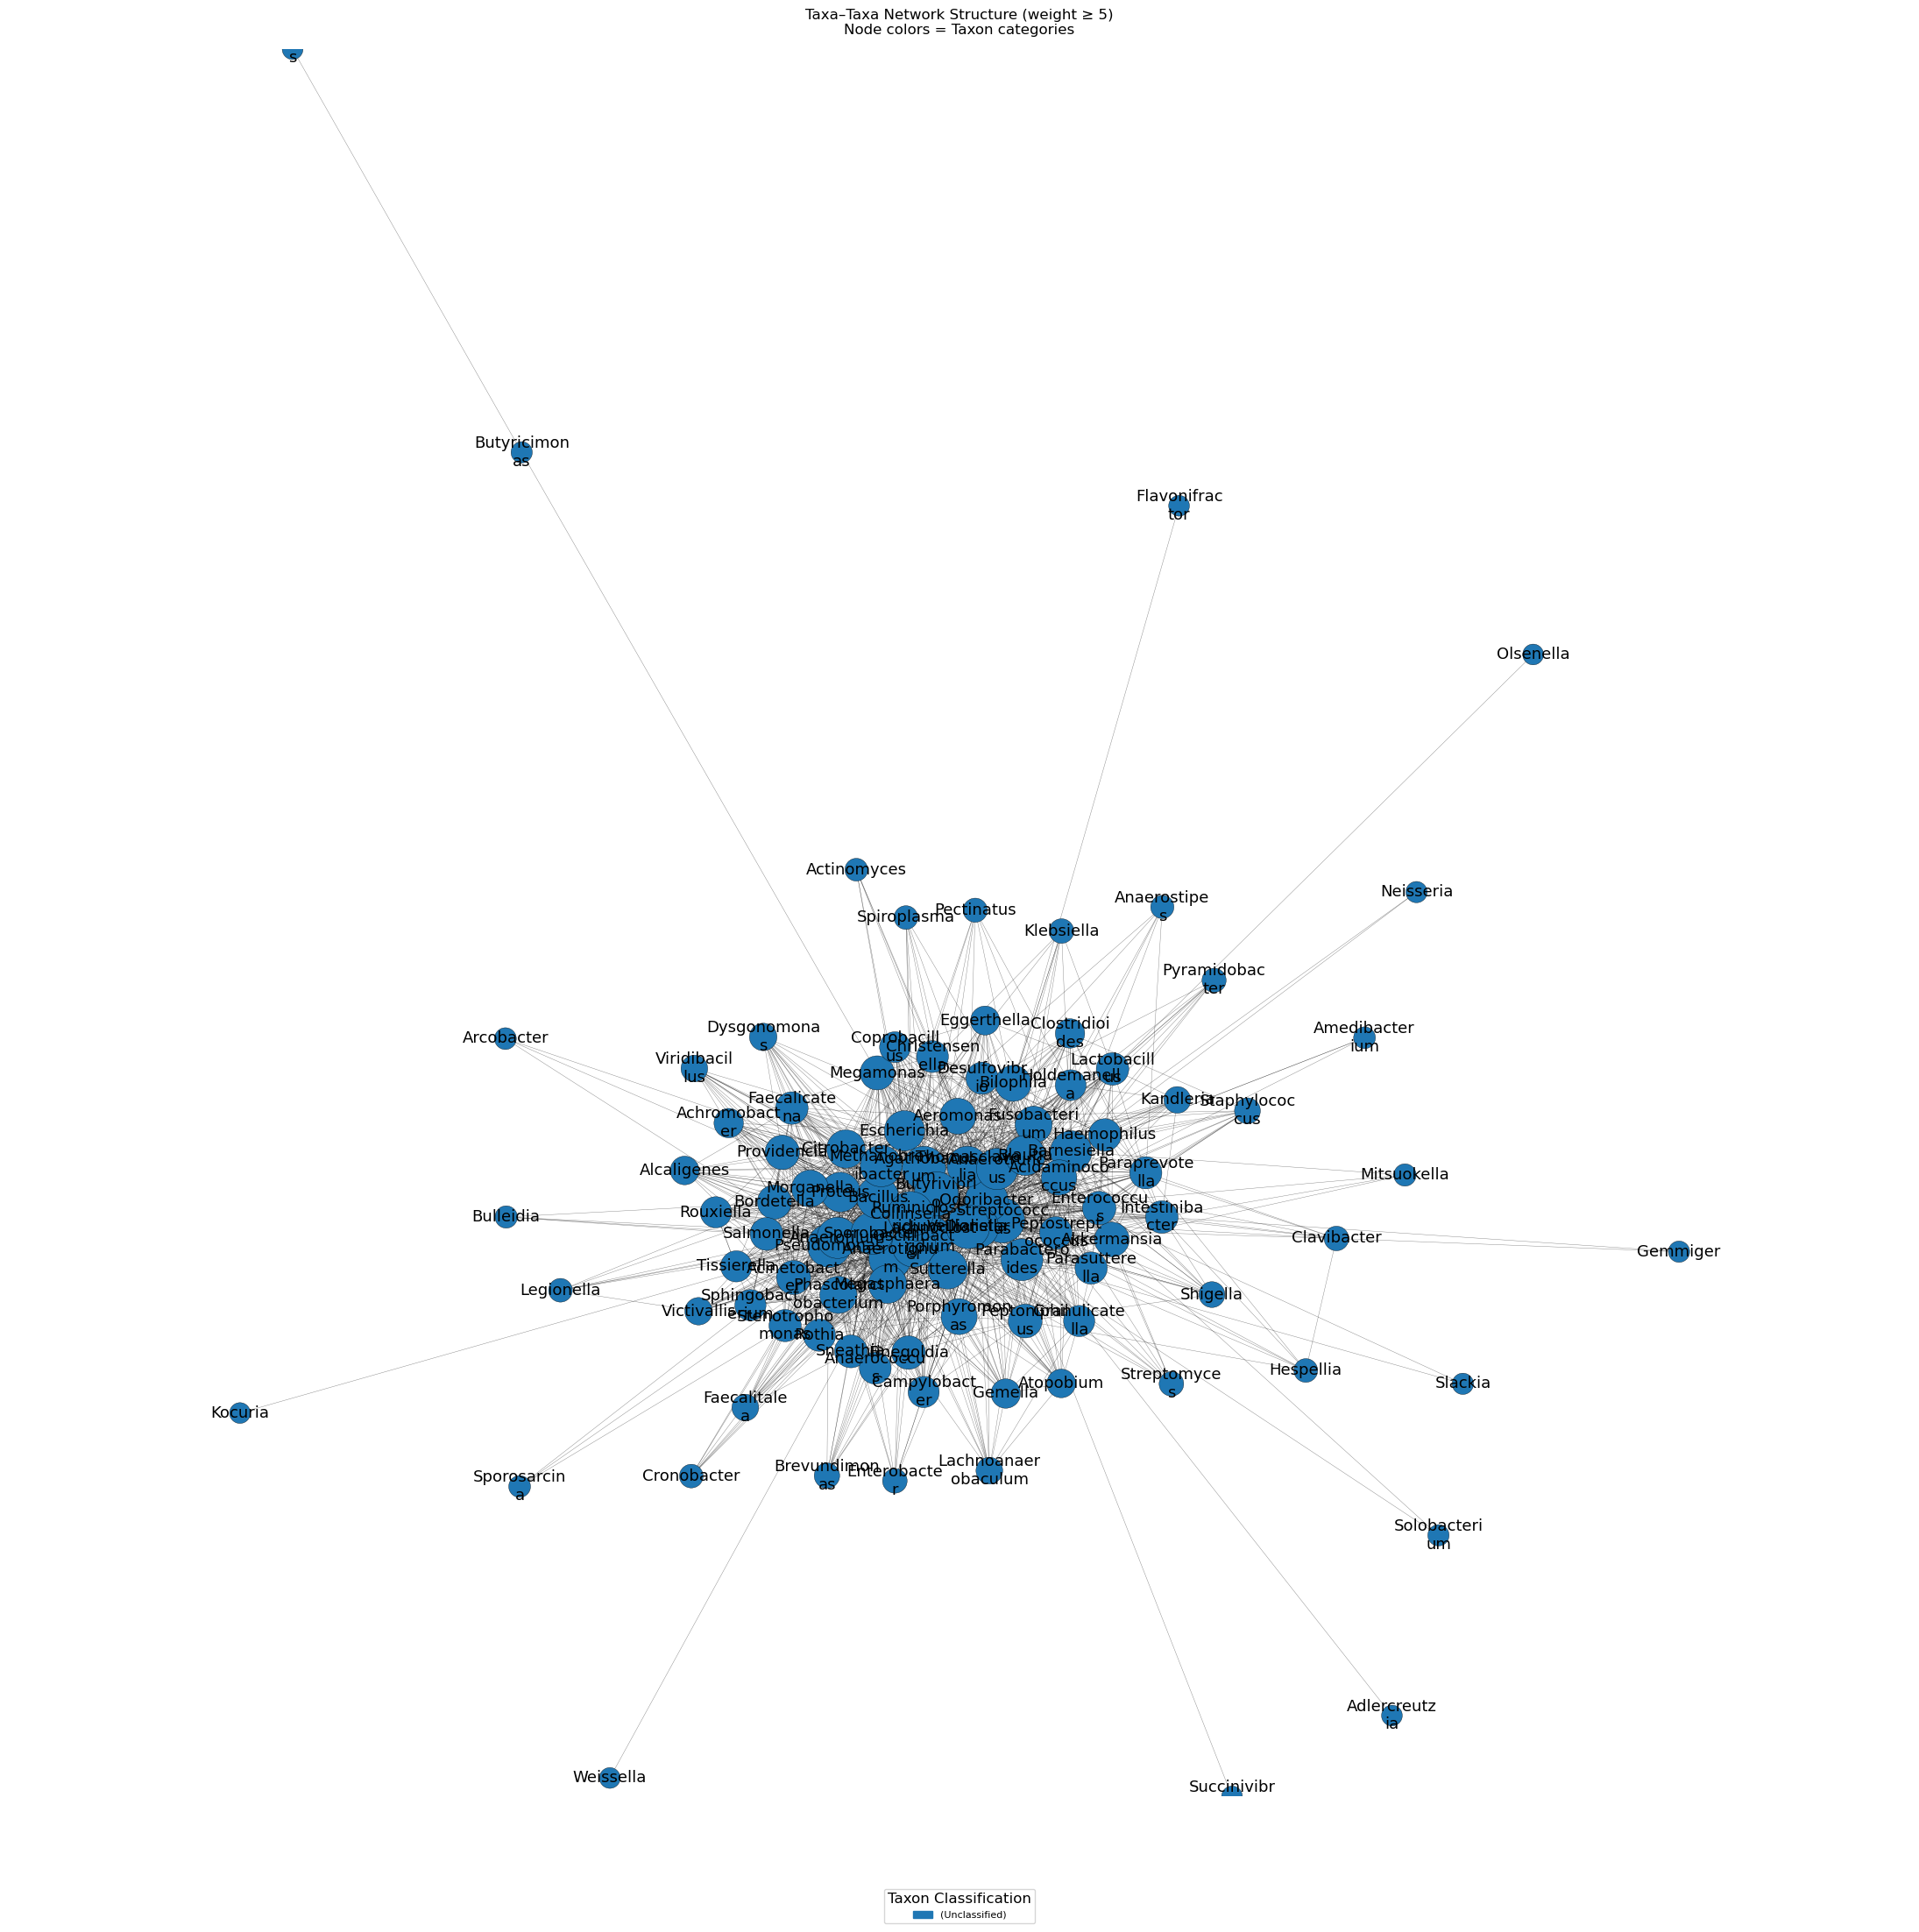

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np
import textwrap

# --- Tunables (spacing without changing layout) ---
scale_factor = 2.0       # >1 spreads nodes apart (no layout recompute)
padding_factor = 0       # extra whitespace around the network

# --- Layout & labels (unchanged physics) ---
pos = nx.spring_layout(G_filtered, seed=42, iterations=1000)  # keep your existing layout
labels = {n: taxon_dict.get(n, str(n)) for n in G_filtered.nodes()}  # <-- taxa labels

# --- Inflate positions WITHOUT changing layout parameters ---
pos = {n: (x * scale_factor, y * scale_factor) for n, (x, y) in pos.items()}

# --- Node size from degree (AFTER threshold) ---
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
min_size, max_size = 200, 1000  # points^2
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Normalize categories per node & collect actually used categories ---
node_cats = {}
for n in G_filtered.nodes():
    cats = taxon_category_by_id.get(n, [])   # <-- taxa categories
    if not isinstance(cats, list) or len(cats) == 0:
        cats = ["(Unclassified)"]
    node_cats[n] = cats
used_categories = sorted({c for cats in node_cats.values() for c in cats})

# --- Color map ONLY for used categories ---
cmap = plt.cm.get_cmap("tab20", len(used_categories) if len(used_categories) > 0 else 1)
category_colors = {cat: cmap(i) for i, cat in enumerate(used_categories)}

# --- Figure & axis ---
fig, ax = plt.subplots(figsize=(22, 22))

# Edges first
nx.draw_networkx_edges(G_filtered, pos, width=0.3, alpha=0.5, ax=ax)

# Set axis limits with EXTRA padding (do NOT tightly fit)
xs = np.array([p[0] for p in pos.values()])
ys = np.array([p[1] for p in pos.values()])
span_x = xs.max() - xs.min()
span_y = ys.max() - ys.min()
pad_x = span_x * padding_factor if span_x > 0 else 0.1
pad_y = span_y * padding_factor if span_y > 0 else 0.1
ax.set_xlim(xs.min() - pad_x, xs.max() + pad_x)
ax.set_ylim(ys.min() - pad_y, ys.max() + pad_y)

# Keep circles round
ax.set_aspect('equal', adjustable='datalim')

# Helper: convert node size (points^2) -> radius in data units
def points2data_radius(ax, size_pts2):
    r_pts = np.sqrt(size_pts2 / np.pi)          # points
    r_px = r_pts * (fig.dpi / 72.0)             # pixels
    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    dx_per_px = (x1 - x0) / ax.bbox.width
    dy_per_px = (y1 - y0) / ax.bbox.height
    return r_px * 0.5 * (dx_per_px + dy_per_px)

# Draw nodes as pie slices
for size, n in zip(node_sizes, G_filtered.nodes()):
    cats = node_cats[n]
    r = points2data_radius(ax, size)
    x, y = pos[n]
    k = len(cats)
    for j, cat in enumerate(cats):
        theta1 = 360.0 * j / k
        theta2 = 360.0 * (j + 1) / k
        wedge = mpatches.Wedge(
            (x, y), r, theta1, theta2,
            facecolor=category_colors.get(cat, "lightgray"),
            edgecolor="black", lw=0.25, zorder=2
        )
        ax.add_patch(wedge)

# Wrap node labels for the plot
wrap_width = 11  # characters before wrapping
labels_wrapped = {
    n: "\n".join(textwrap.wrap(lbl, wrap_width))
    for n, lbl in labels.items()
}

# Labels on top (wrapped)
nx.draw_networkx_labels(
    G_filtered, pos,
    labels=labels_wrapped,
    font_size=13,
    font_color='black',
    ax=ax
)

ax.set_title(f"Taxa–Taxa Network Structure (weight ≥ {edge_weight_threshold})\nNode colors = Taxon categories", pad=12)
ax.axis('off')

# Legend ONLY for used categories - horizontal at bottom
legend_handles = [mpatches.Patch(color=category_colors[c], label=c) for c in used_categories]
ax.legend(
    handles=legend_handles,
    title="Taxon Classification",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),   # move below plot
    fancybox=True,
    shadow=False,
    ncol=min(len(used_categories), 5),
    fontsize=8,
    title_fontsize=12
)

plt.tight_layout()
plt.show()


/tmp/slurm.4613945/ipykernel_29315/651370723.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(used_categories) if len(used_categories) > 0 else 1)
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


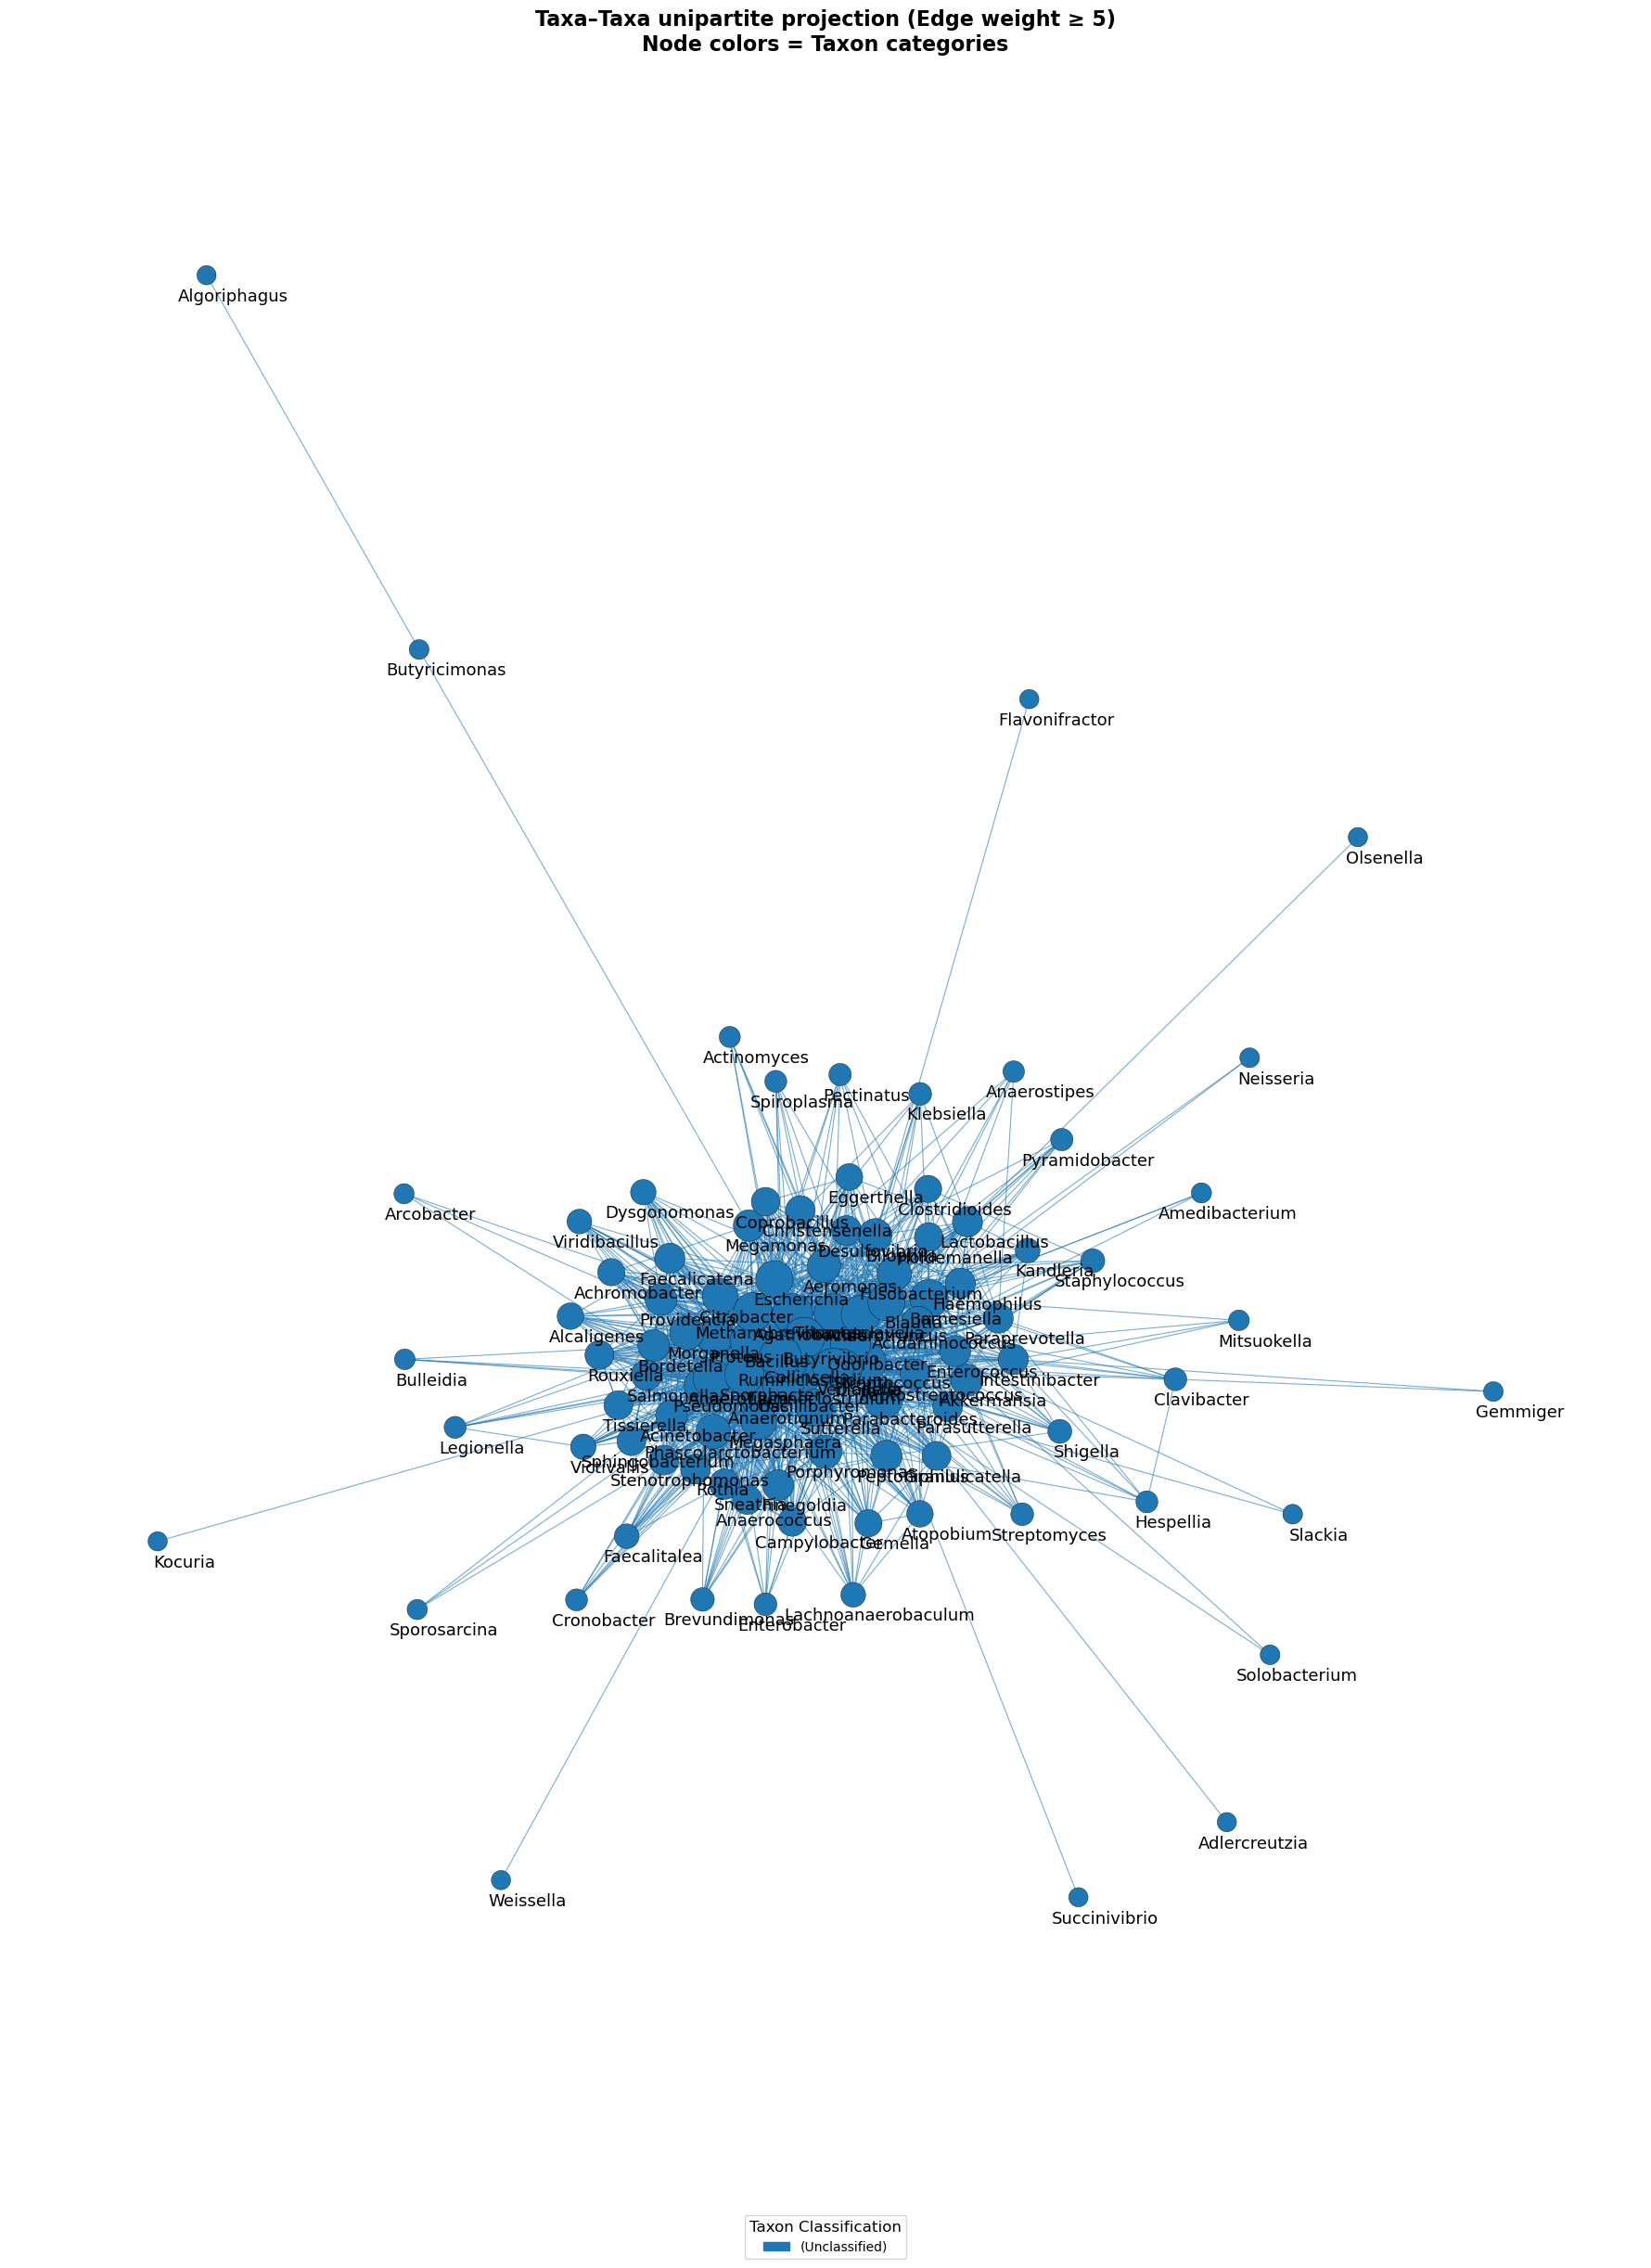

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np
import textwrap

# --- Tunables ---
scale_factor = 2.0
padding_factor = 0
wrap_width = 11
font_size = 13

min_size, max_size = 200, 1000
edge_width = 0.8
edge_alpha = 0.6

# --- Layout ---
pos = nx.spring_layout(G_filtered, seed=42, iterations=1000)
labels = {n: taxon_dict.get(n, str(n)) for n in G_filtered.nodes()}  # <-- taxa labels
pos = {n: (x * scale_factor, y * scale_factor) for n, (x, y) in pos.items()}

# --- Node size ---
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Categories (TAXA) ---
node_cats = {}
for n in G_filtered.nodes():
    cats = taxon_category_by_id.get(n, [])  # <-- taxa categories
    if not isinstance(cats, list) or len(cats) == 0:
        cats = ["(Unclassified)"]
    node_cats[n] = cats

used_categories = sorted({c for cats in node_cats.values() for c in cats})
cmap = plt.cm.get_cmap("tab20", len(used_categories) if len(used_categories) > 0 else 1)
category_colors = {cat: cmap(i) for i, cat in enumerate(used_categories)}

# --- Edge colors based on shared category ---
edge_colors = []
for u, v in G_filtered.edges():
    cats_u = node_cats.get(u, [])
    cats_v = node_cats.get(v, [])
    shared = set(cats_u) & set(cats_v)
    if shared:
        cat = list(shared)[0]
        edge_colors.append(category_colors.get(cat, "grey"))
    else:
        edge_colors.append("lightgrey")

# --- Plot ---
fig, ax = plt.subplots(figsize=(22, 22))

nx.draw_networkx_edges(
    G_filtered,
    pos,
    width=edge_width,
    alpha=edge_alpha,
    edge_color=edge_colors,
    ax=ax
)

# Helper: points² → radius in data units
def points2data_radius(ax, size_pts2):
    r_pts = np.sqrt(size_pts2 / np.pi)
    r_px = r_pts * (fig.dpi / 72.0)
    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    dx_per_px = (x1 - x0) / ax.bbox.width
    dy_per_px = (y1 - y0) / ax.bbox.height
    return r_px * 0.5 * (dx_per_px + dy_per_px)

# Axis limits
xs = np.array([p[0] for p in pos.values()])
ys = np.array([p[1] for p in pos.values()])
span_x = xs.max() - xs.min()
span_y = ys.max() - ys.min()
pad_x = span_x * padding_factor if span_x > 0 else 0.1
pad_y = span_y * padding_factor if span_y > 0 else 0.1
ax.set_xlim(xs.min() - pad_x, xs.max() + pad_x)
ax.set_ylim(ys.min() - pad_y, ys.max() + pad_y)
ax.set_aspect('equal', adjustable='datalim')

# Nodes as pies
for size, n in zip(node_sizes, G_filtered.nodes()):
    cats = node_cats[n]
    r = points2data_radius(ax, size)
    x, y = pos[n]
    k = len(cats)
    for j, cat in enumerate(cats):
        theta1 = 360.0 * j / k
        theta2 = 360.0 * (j + 1) / k
        wedge = mpatches.Wedge(
            (x, y), r, theta1, theta2,
            facecolor=category_colors.get(cat, "lightgray"),
            edgecolor="black", lw=0.25, zorder=2
        )
        ax.add_patch(wedge)

# Labels (wrapped), offset down & right
labels_wrapped = {
    n: "\n".join(
        textwrap.wrap(labels[n], wrap_width, break_long_words=False, break_on_hyphens=False)
    )
    for n in G_filtered.nodes()
}
label_pos = {n: (x + 0.05, y - 0.04) for n, (x, y) in pos.items()}
nx.draw_networkx_labels(G_filtered, label_pos, labels=labels_wrapped, font_size=font_size, font_color='black', ax=ax)

# Legend
legend_handles = [mpatches.Patch(color=category_colors[c], label=c) for c in used_categories]
ax.legend(
    handles=legend_handles,
    title="Taxon Classification",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=min(len(used_categories), 5),
    fontsize=10,
    title_fontsize=12
)

ax.set_title(
    f"Taxa–Taxa unipartite projection (Edge weight ≥ {edge_weight_threshold})\n"
    f"Node colors = Taxon categories",
    fontweight='bold', fontsize=16, pad=12
)
ax.axis('off')
plt.tight_layout()
# Optional: adjust axes position just before show (same as your original line)
pos_bounds = [0.1, 0.5, 0.8, 1]  # [left, bottom, width, height]
ax.set_position(pos_bounds)
plt.show()


/tmp/slurm.4613945/ipykernel_29315/1614831897.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(used_categories) if len(used_categories) > 0 else 1)
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


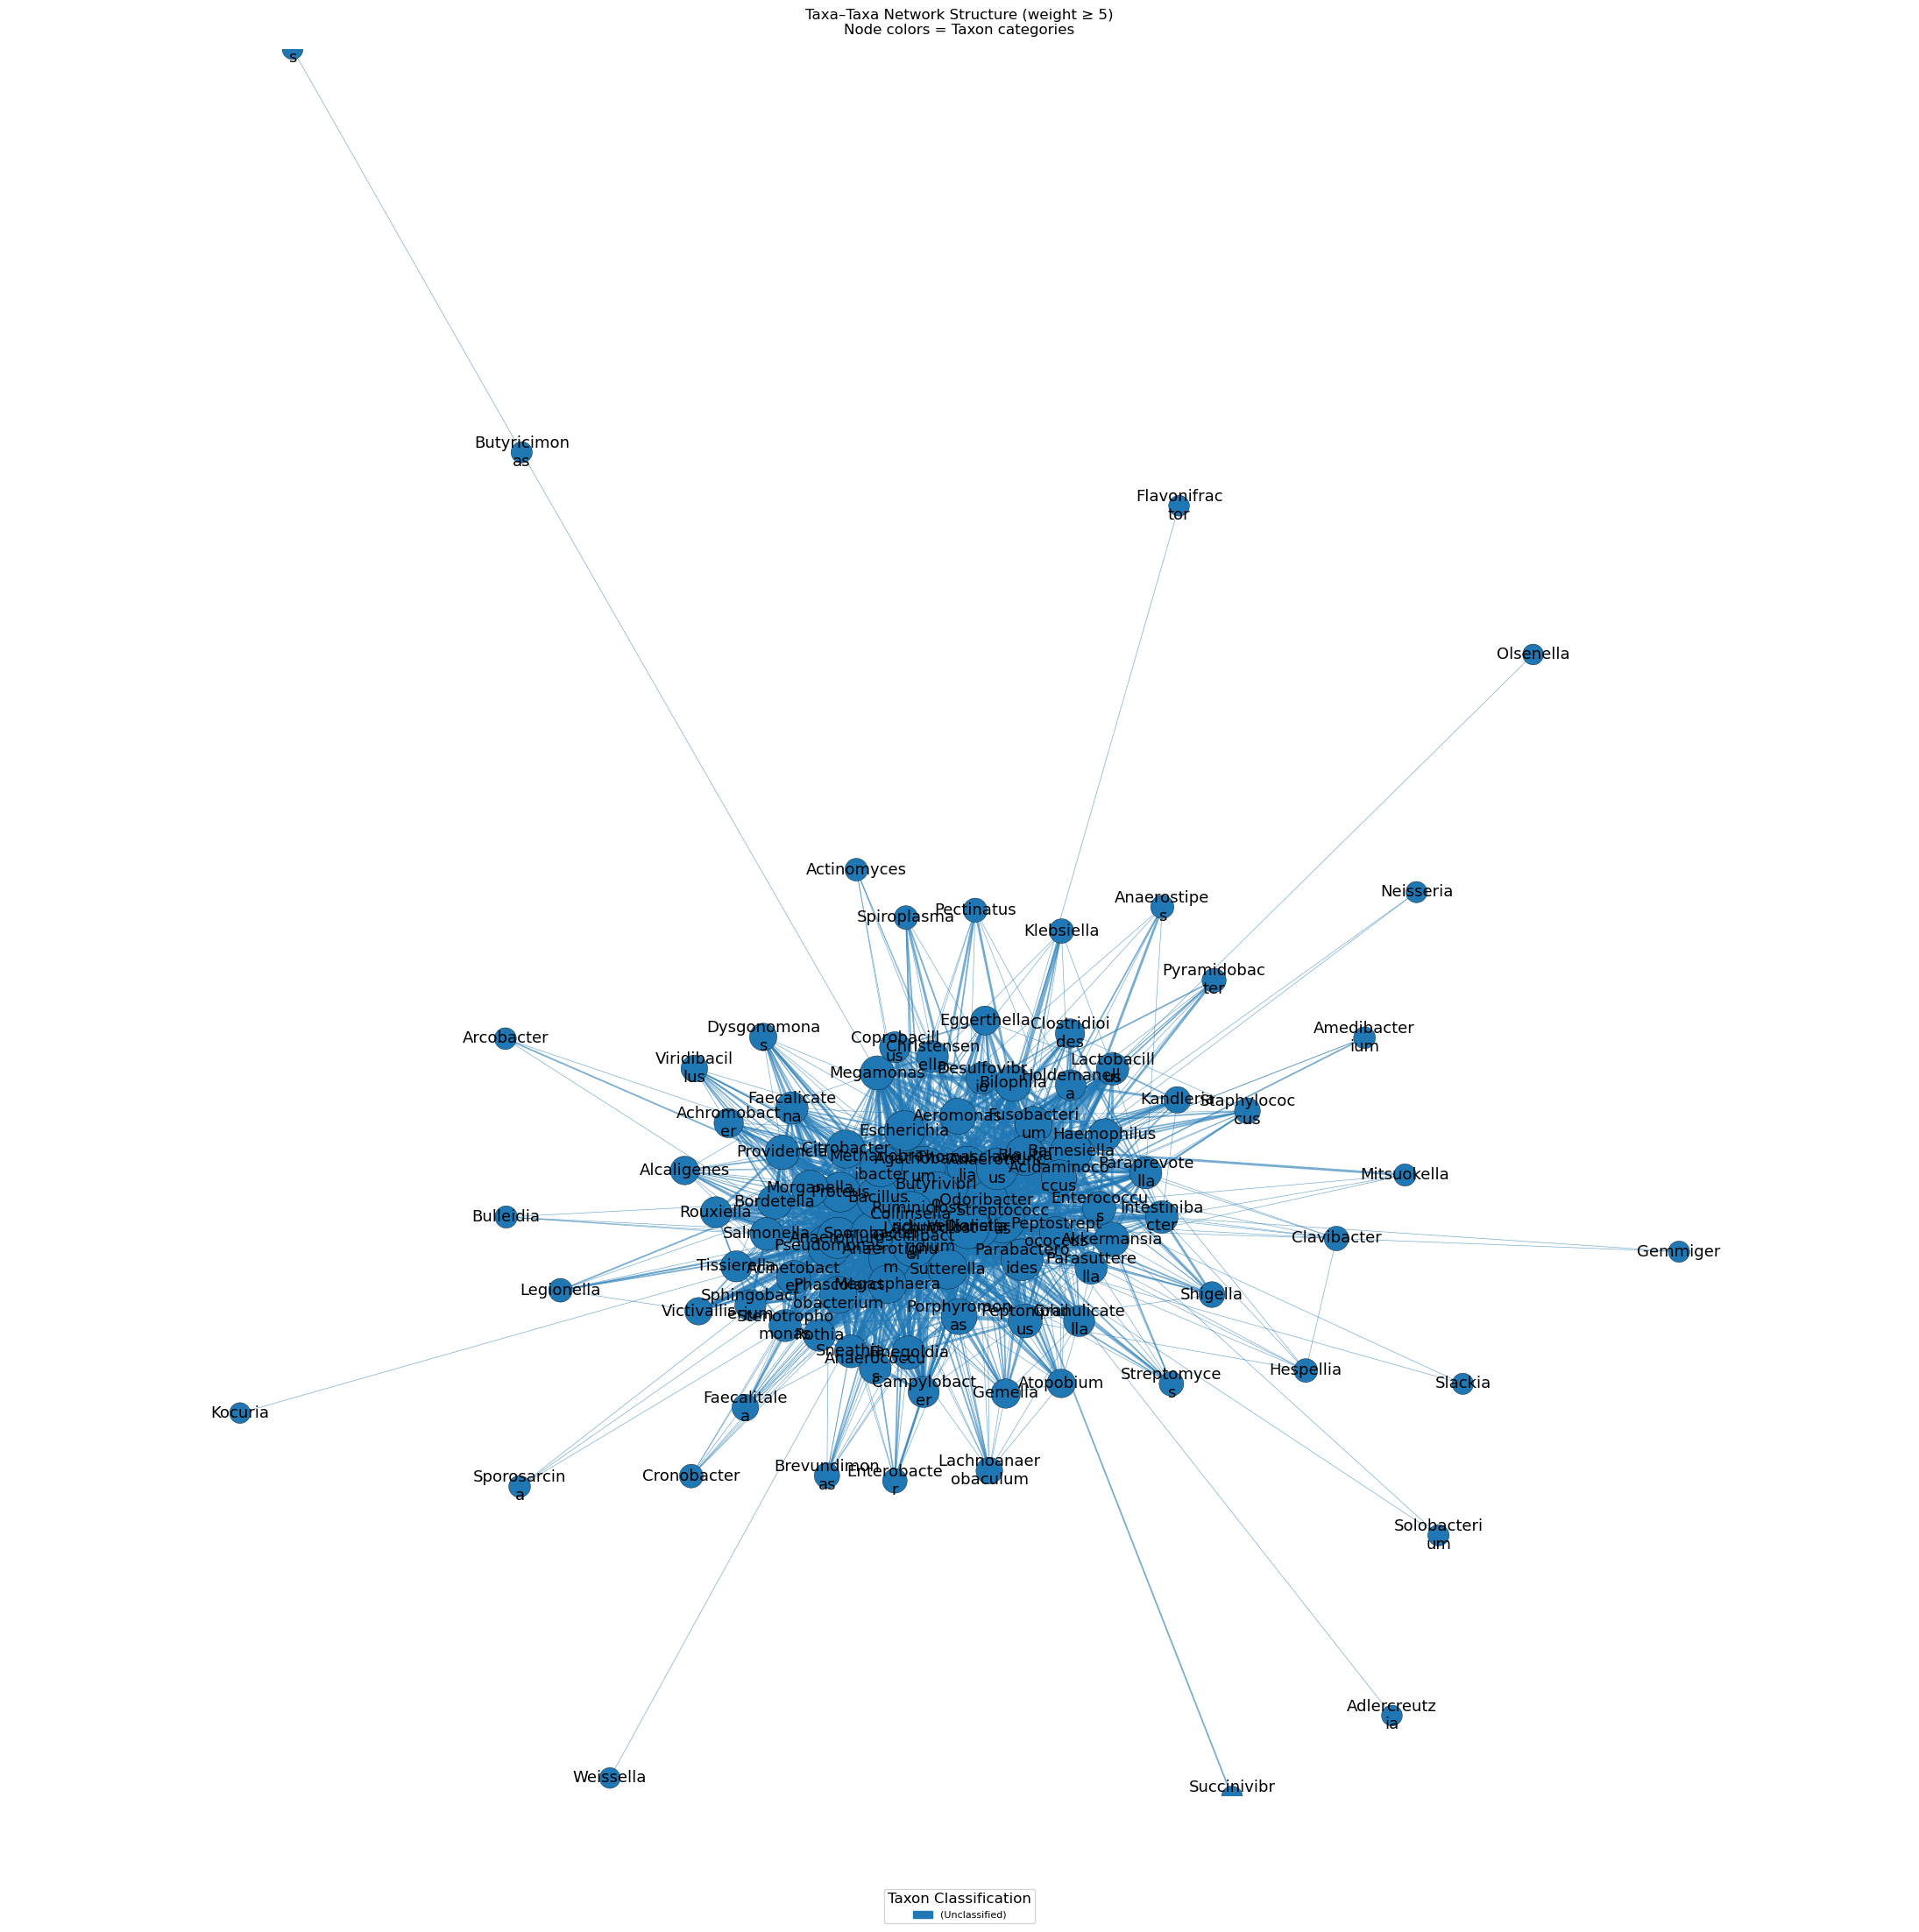

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np
import textwrap
import math

# --- Tunables ---
scale_factor = 2.0
padding_factor = 0
wrap_width = 11
font_size = 13

min_size, max_size = 200, 1000
edge_alpha = 0.6
min_w, max_w = 0.5, 8.0  # exaggerated range for edge thickness

# --- Layout ---
pos = nx.spring_layout(G_filtered, seed=42, iterations=1000)
labels = {n: taxon_dict.get(n, str(n)) for n in G_filtered.nodes()}  # <-- taxa labels
pos = {n: (x * scale_factor, y * scale_factor) for n, (x, y) in pos.items()}

# --- Node size ---
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Categories (TAXA) ---
node_cats = {}
for n in G_filtered.nodes():
    cats = taxon_category_by_id.get(n, [])  # <-- taxa categories
    if not isinstance(cats, list) or len(cats) == 0:
        cats = ["(Unclassified)"]
    node_cats[n] = cats

used_categories = sorted({c for cats in node_cats.values() for c in cats})
cmap = plt.cm.get_cmap("tab20", len(used_categories) if len(used_categories) > 0 else 1)
category_colors = {cat: cmap(i) for i, cat in enumerate(used_categories)}

# --- Edge colors & widths (log²-scaled, exaggerated range) ---
weights = [G_filtered[u][v].get("weight", 1.0) for u, v in G_filtered.edges()]
if weights:
    w_min, w_max = min(weights), max(weights)
    log_min = math.log(w_min + 1)
    log_max = math.log(w_max + 1)
    edge_widths = [
        min_w + ((math.log(w + 1)**2 - log_min**2) / (log_max**2 - log_min**2) if log_max > log_min else 0) * (max_w - min_w)
        for w in weights
    ]
else:
    edge_widths = [min_w] * len(G_filtered.edges())

edge_colors = []
for (u, v), w in zip(G_filtered.edges(), edge_widths):
    cats_u = node_cats.get(u, [])
    cats_v = node_cats.get(v, [])
    shared = set(cats_u) & set(cats_v)
    if shared:
        cat = list(shared)[0]
        edge_colors.append(category_colors.get(cat, "grey"))
    else:
        edge_colors.append("lightgrey")

# --- Plot ---
fig, ax = plt.subplots(figsize=(22, 22))

nx.draw_networkx_edges(
    G_filtered,
    pos,
    width=edge_widths,
    alpha=edge_alpha,
    edge_color=edge_colors,
    ax=ax
)

# Helper: points² → radius in data units
def points2data_radius(ax, size_pts2):
    r_pts = np.sqrt(size_pts2 / np.pi)
    r_px = r_pts * (fig.dpi / 72.0)
    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    dx_per_px = (x1 - x0) / ax.bbox.width
    dy_per_px = (y1 - y0) / ax.bbox.height
    return r_px * 0.5 * (dx_per_px + dy_per_px)

# Axis limits
xs = np.array([p[0] for p in pos.values()])
ys = np.array([p[1] for p in pos.values()])
span_x = xs.max() - xs.min()
span_y = ys.max() - ys.min()
pad_x = span_x * padding_factor if span_x > 0 else 0.1
pad_y = span_y * padding_factor if span_y > 0 else 0.1
ax.set_xlim(xs.min() - pad_x, xs.max() + pad_x)
ax.set_ylim(ys.min() - pad_y, ys.max() + pad_y)
ax.set_aspect('equal', adjustable='datalim')

# Nodes as pies
for size, n in zip(node_sizes, G_filtered.nodes()):
    cats = node_cats[n]
    r = points2data_radius(ax, size)
    x, y = pos[n]
    k = len(cats)
    for j, cat in enumerate(cats):
        theta1 = 360.0 * j / k
        theta2 = 360.0 * (j + 1) / k
        wedge = mpatches.Wedge(
            (x, y), r, theta1, theta2,
            facecolor=category_colors.get(cat, "lightgray"),
            edgecolor="black", lw=0.25, zorder=2
        )
        ax.add_patch(wedge)

# Labels
labels_wrapped = {n: "\n".join(textwrap.wrap(lbl, wrap_width)) for n, lbl in labels.items()}
nx.draw_networkx_labels(
    G_filtered, pos,
    labels=labels_wrapped,
    font_size=font_size,
    font_color='black',
    ax=ax
)

# Legend
legend_handles = [mpatches.Patch(color=category_colors[c], label=c) for c in used_categories]
ax.legend(
    handles=legend_handles,
    title="Taxon Classification",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=min(len(used_categories), 5),
    fontsize=8,
    title_fontsize=12
)

ax.set_title(
    f"Taxa–Taxa Network Structure (weight ≥ {edge_weight_threshold})\n"
    f"Node colors = Taxon categories",
    pad=12
)
ax.axis('off')
plt.tight_layout()
plt.show()


/tmp/slurm.4613945/ipykernel_29315/2181131933.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(used_categories) if len(used_categories) > 0 else 1)


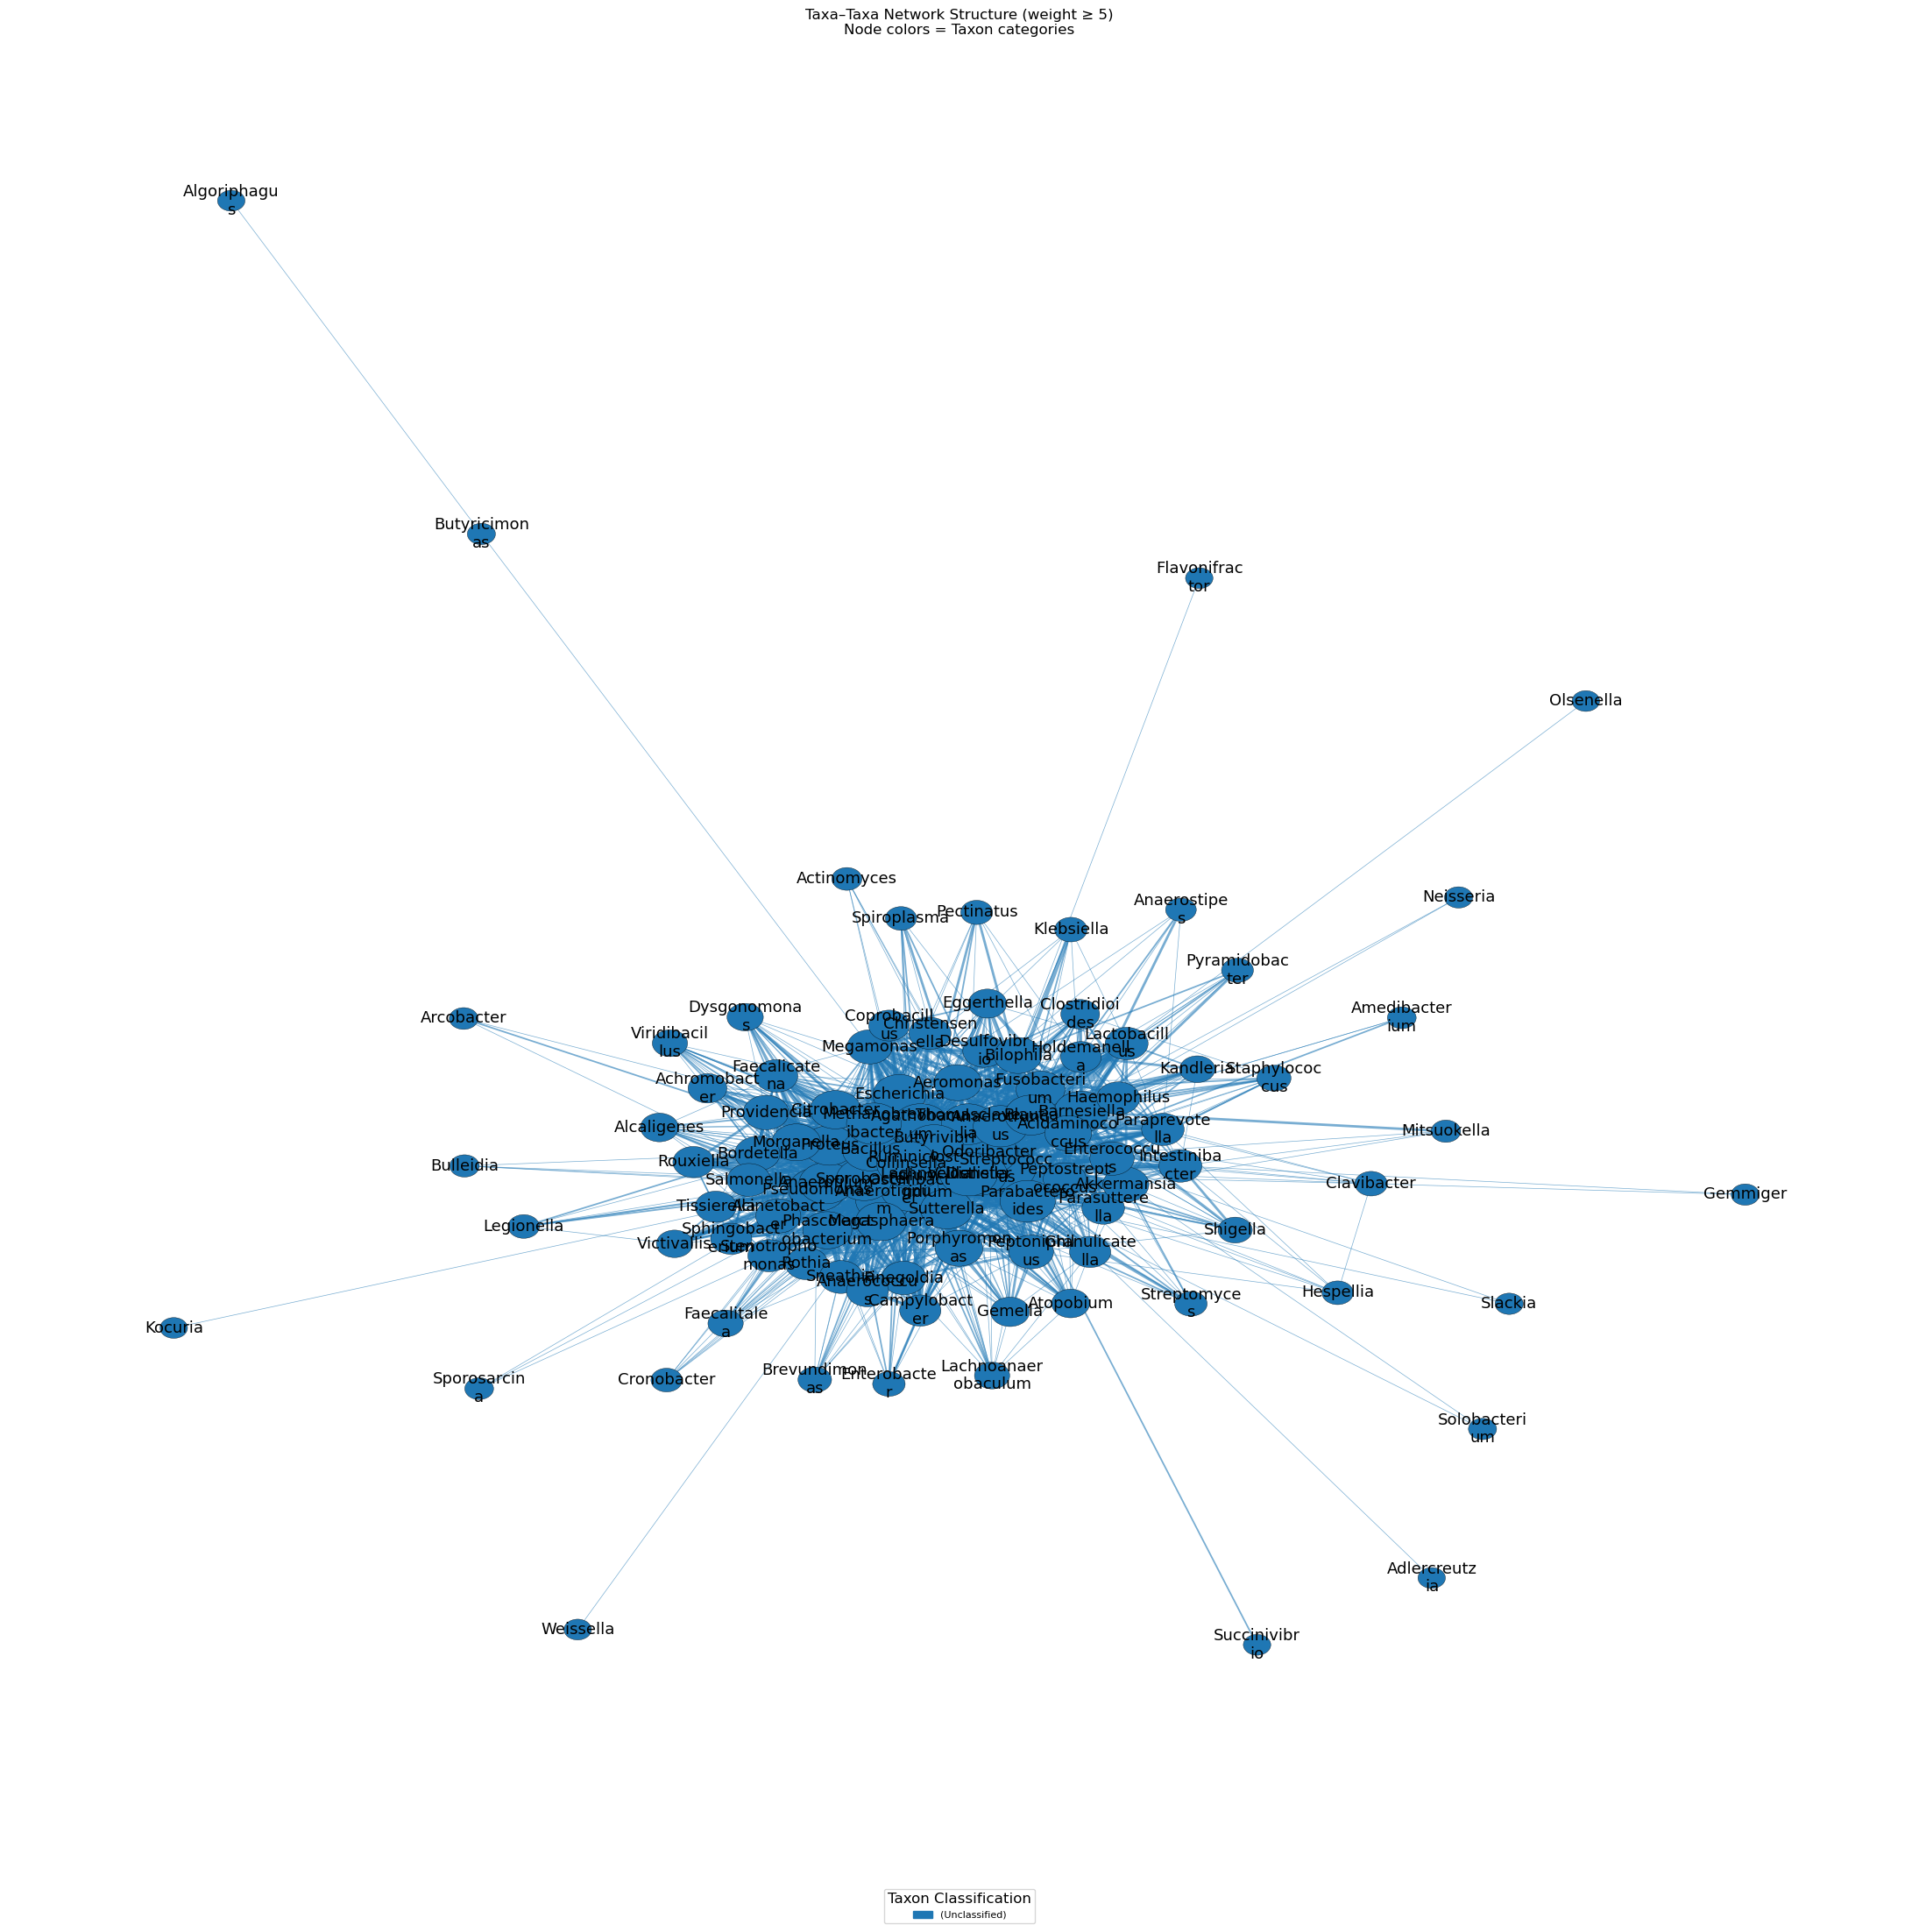

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np
import textwrap
import math

# --- Tunables ---
scale_factor = 2.0
padding_factor = 0
wrap_width = 11
font_size = 13

min_size, max_size = 200, 1000
edge_alpha = 0.6
min_w, max_w = 0.5, 8.0  # exaggerated range for edge thickness

# --- Layout ---
pos = nx.spring_layout(G_filtered, seed=42, iterations=1000)
labels = {n: taxon_dict.get(n, str(n)) for n in G_filtered.nodes()}  # <-- taxa labels
pos = {n: (x * scale_factor, y * scale_factor) for n, (x, y) in pos.items()}

# --- Node size ---
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Categories (TAXA) ---
node_cats = {}
for n in G_filtered.nodes():
    cats = taxon_category_by_id.get(n, [])  # <-- taxa categories
    if not isinstance(cats, list) or len(cats) == 0:
        cats = ["(Unclassified)"]
    node_cats[n] = cats

used_categories = sorted({c for cats in node_cats.values() for c in cats})
cmap = plt.cm.get_cmap("tab20", len(used_categories) if len(used_categories) > 0 else 1)
category_colors = {cat: cmap(i) for i, cat in enumerate(used_categories)}

# --- Edge colors & widths (log²-scaled, exaggerated range) ---
weights = [G_filtered[u][v].get("weight", 1.0) for u, v in G_filtered.edges()]
if weights:
    w_min, w_max = min(weights), max(weights)
    log_min = math.log(w_min + 1)
    log_max = math.log(w_max + 1)
    edge_widths = [
        min_w + ((math.log(w + 1)**2 - log_min**2) / (log_max**2 - log_min**2) if log_max > log_min else 0) * (max_w - min_w)
        for w in weights
    ]
else:
    edge_widths = [min_w] * len(G_filtered.edges())

edge_colors = []
for (u, v), w in zip(G_filtered.edges(), edge_widths):
    cats_u = node_cats.get(u, [])
    cats_v = node_cats.get(v, [])
    shared = set(cats_u) & set(cats_v)
    if shared:
        cat = list(shared)[0]
        edge_colors.append(category_colors.get(cat, "grey"))
    else:
        edge_colors.append("lightgrey")

# --- Plot ---
fig, ax = plt.subplots(figsize=(22, 22))

nx.draw_networkx_edges(
    G_filtered,
    pos,
    width=edge_widths,
    alpha=edge_alpha,
    edge_color=edge_colors,
    ax=ax
)

# Helper: points² → radius in data units
def points2data_radius(ax, size_pts2):
    r_pts = np.sqrt(size_pts2 / np.pi)
    r_px = r_pts * (fig.dpi / 72.0)
    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    dx_per_px = (x1 - x0) / ax.bbox.width
    dy_per_px = (y1 - y0) / ax.bbox.height
    return r_px * 0.5 * (dx_per_px + dy_per_px)

# Nodes as single-color circles
for size, n in zip(node_sizes, G_filtered.nodes()):
    cats = node_cats[n]
    # just pick the first category if multiple exist
    cat = cats[0] if isinstance(cats, list) else cats
    r = points2data_radius(ax, size)
    x, y = pos[n]
    circle = mpatches.Circle(
        (x, y), r,
        facecolor=category_colors.get(cat, "lightgray"),
        edgecolor="black", lw=0.25, zorder=2
    )
    ax.add_patch(circle)

# Labels
labels_wrapped = {n: "\n".join(textwrap.wrap(lbl, wrap_width)) for n, lbl in labels.items()}
nx.draw_networkx_labels(
    G_filtered, pos,
    labels=labels_wrapped,
    font_size=font_size,
    font_color='black',
    ax=ax
)

# Legend
legend_handles = [mpatches.Patch(color=category_colors[c], label=c) for c in used_categories]
ax.legend(
    handles=legend_handles,
    title="Taxon Classification",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=min(len(used_categories), 5),
    fontsize=8,
    title_fontsize=12
)

ax.set_title(
    f"Taxa–Taxa Network Structure (weight ≥ {edge_weight_threshold})\n"
    f"Node colors = Taxon categories",
    pad=12
)
ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# !pip install ipycytoscape ipywidgets

import io, base64, math, textwrap
import ipycytoscape
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from IPython.display import display

# ===================== Tunables =====================
wrap_width          = 11
PX_MIN, PX_MAX      = 150, 450          # tiny nodes
EDGE_W_MIN, EDGE_W_MAX = 5, 30   # thin edges
LABEL_LIMIT         = 40             # only hubs get labels (others on click)
FONT_PX             = 100

# Stretch controls (center expansion)
MAX_EXTRA_SCALE     = 3.5
INFLUENCE_RAD       = 0.85
BASE_SPACING        = 6000.0

WIDGET_W, WIDGET_H  = '2000px', '1200px'

# ===================== Inputs / fallbacks =====================
# labels / pos may already exist from your previous cell
if 'labels' not in globals():
    labels = {n: (taxon_dict.get(n, str(n)) if 'taxon_dict' in globals() else str(n))
              for n in G_filtered.nodes()}
if 'pos' not in globals():
    pos = nx.spring_layout(G_filtered, seed=42, iterations=1000)

def get_cats(n):
    if 'taxon_category_by_id' in globals():
        cs = taxon_category_by_id.get(n, [])
        return cs if isinstance(cs, list) and cs else ["(Unclassified)"]
    return ["(Unclassified)"]

node_cats = {n: get_cats(n) for n in G_filtered.nodes()}

# ===================== Category palette =====================
used_categories = sorted({c for cs in node_cats.values() for c in cs})
num_cats = max(1, len(used_categories))
try:
    cmap = matplotlib.colormaps.get_cmap("tab20").resampled(num_cats)
except Exception:
    cmap = plt.cm.get_cmap("tab20", num_cats)

def rgba_to_hex(rgba):
    if isinstance(rgba, str): return rgba
    r, g, b, a = rgba[:4]
    return f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"

category_colors = {cat: rgba_to_hex(cmap(i)) for i, cat in enumerate(used_categories)}

# ===================== Tiny solid PNG per category (cached) =====================
def solid_png_b64(hexcol, size_px=8):
    fig = plt.figure(figsize=(size_px/96, size_px/96), dpi=96)
    fig.patch.set_alpha(0)
    ax = plt.axes([0, 0, 1, 1]); ax.set_axis_off(); ax.patch.set_alpha(0)
    ax.add_patch(plt.Circle((0.5, 0.5), 0.5, color=hexcol))
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=96, transparent=True)
    plt.close(fig)
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("ascii")

img_by_cat = {cat: solid_png_b64(color, size_px=8) for cat, color in category_colors.items()}

# ===================== Degree → node size =====================
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0: raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm   = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
deg_by_node = dict(zip([n for n, _ in G_filtered.degree()], deg_vals))

def size_unit_to_px(u):
    return int(PX_MIN + float(u) * (PX_MAX - PX_MIN))

# ===================== Edge width & colour =====================
def edge_color(u, v):
    cu = node_cats[u][0]; cv = node_cats[v][0]
    return category_colors.get(cu, "#bfbfbf") if cu == cv else "#cfcfcf"

weights = [G_filtered[u][v].get("weight", 1.0) for u, v in G_filtered.edges()]
if weights:
    w_min, w_max = float(min(weights)), float(max(weights))
    log_min, log_max = math.log(w_min + 1.0), math.log(w_max + 1.0)
    def edge_w_px(w):
        if log_max > log_min:
            val = (math.log(w + 1.0)**2 - log_min**2) / (log_max**2 - log_min**2)
            val = max(0.0, min(1.0, val))
        else:
            val = 0.0
        return EDGE_W_MIN + val * (EDGE_W_MAX - EDGE_W_MIN)
else:
    def edge_w_px(w): return EDGE_W_MIN

# ===================== Center-expansion (stretched preset) =====================
xs = [p[0] for p in pos.values()]; ys = [p[1] for p in pos.values()]
cx, cy = (max(xs)+min(xs))/2.0, (max(ys)+min(ys))/2.0
max_dist = max(((x-cx)**2 + (y-cy)**2)**0.5 for (x, y) in pos.values()) or 1.0

pos_adjusted = {}
for n, (x, y) in pos.items():
    dx, dy = x - cx, y - cy
    dist   = (dx*dx + dy*dy)**0.5
    nd     = dist / max_dist
    if nd < INFLUENCE_RAD:
        scale = MAX_EXTRA_SCALE - (MAX_EXTRA_SCALE - 1.0) * (nd / INFLUENCE_RAD)
    else:
        scale = 1.0
    pos_adjusted[n] = (cx + dx * scale * BASE_SPACING,
                       cy + dy * scale * BASE_SPACING)

# ===================== Labels (only hubs get text) =====================
if LABEL_LIMIT and len(G_filtered) > LABEL_LIMIT:
    hubs = {n for n, _ in sorted(deg_by_node.items(), key=lambda kv: kv[1], reverse=True)[:LABEL_LIMIT]}
else:
    hubs = set(G_filtered.nodes())

def wrap_label(n):
    s = labels.get(n, str(n))
    return "\n".join(textwrap.wrap(s, width=wrap_width, break_long_words=False, break_on_hyphens=False))

# ===================== Build ONE JSON payload =====================
nodes_json, edges_json = [], []
for n in G_filtered.nodes():
    cat  = node_cats[n][0]
    size = size_unit_to_px(deg_norm[list(G_filtered.nodes()).index(n)])
    label = wrap_label(n) if n in hubs else ""  # shrink payload
    x, y  = pos_adjusted[n]
    nodes_json.append({
        "data": {
            "id": str(n),
            "label": label,
            "category": cat,
            "w": float(size),
            "h": float(size)
        },
        "position": {"x": float(x), "y": float(y)}
    })

for u, v, d in G_filtered.edges(data=True):
    w = float(d.get("weight", 1.0))
    edges_json.append({
        "data": {
            "source": str(u),
            "target": str(v),
            "color": edge_color(u, v),
            "w": float(edge_w_px(w))
        }
    })

elements = {"nodes": nodes_json, "edges": edges_json}

# ===================== Widget (single add) =====================
cyto = ipycytoscape.CytoscapeWidget()
cyto.layout.width  = WIDGET_W
cyto.layout.height = WIDGET_H
cyto.graph.add_graph_from_json(elements)  # ONE message instead of thousands

# ===================== Styles =====================
base_styles = [
    {
        'selector': 'node',
        'style': {
            'shape': 'ellipse',
            'width':  'data(w)',
            'height': 'data(h)',
            'background-color': '#000',        # hidden by image
            'background-opacity': 0,
            'label': 'data(label)',
            'font-size': f'{FONT_PX}px',
            'color': '#000',
            'text-wrap': 'wrap',
            'text-max-width': '120px',
            'text-valign': 'bottom',
            'text-halign': 'right',
            'text-margin-x': -6,
            'text-margin-y': 5,
            'border-width': 0,
            'overlay-opacity': 0
        }
    },
    {
        'selector': 'edge',
        'style': {
            'line-color': 'data(color)',
            'width': 'data(w)',
            'opacity': 0.9,
            'curve-style': 'haystack',   # faster & less cluttered than bezier
            'haystack-radius': 0.4
        }
    },
    {
        'selector': 'node:selected',
        'style': {'font-size': f'{FONT_PX+200}px'}
    }
]

# category-specific background images (cached once)
cat_img_styles = [
    {
        'selector': f'node[category = "{cat}"]',
        'style': {
            'background-image': f'url({img_by_cat[cat]})',
            'background-image-opacity': 1,
            'background-fit': 'cover'
        }
    } for cat in used_categories
]

cyto.set_style(base_styles + cat_img_styles)

# Preset stretched layout
cyto.set_layout(name='preset')
display(cyto)


CytoscapeWidget(cytoscape_layout={'name': 'preset'}, cytoscape_style=[{'selector': 'node', 'style': {'shape': …

In [ ]:
# !pip install ipycytoscape ipywidgets

import io, base64, math, textwrap
import ipycytoscape
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from IPython.display import display

# ===================== Tunables =====================
wrap_width          = 11
PX_MIN, PX_MAX      = 150, 450          # tiny nodes
EDGE_W_MIN, EDGE_W_MAX = 5, 30   # thin edges
LABEL_LIMIT         = 120             # only hubs get labels (others on click)
FONT_PX             = 100

# Stretch controls (center expansion)
MAX_EXTRA_SCALE     = 3.5
INFLUENCE_RAD       = 0.85
BASE_SPACING        = 6000.0

WIDGET_W, WIDGET_H  = '2000px', '1200px'

# ===================== Inputs / fallbacks =====================
# labels / pos may already exist from your previous cell
if 'labels' not in globals():
    labels = {n: (taxon_dict.get(n, str(n)) if 'taxon_dict' in globals() else str(n))
              for n in G_filtered.nodes()}
if 'pos' not in globals():
    pos = nx.spring_layout(G_filtered, seed=42, iterations=1000)

def get_cats(n):
    if 'taxon_category_by_id' in globals():
        cs = taxon_category_by_id.get(n, [])
        return cs if isinstance(cs, list) and cs else ["(Unclassified)"]
    return ["(Unclassified)"]

node_cats = {n: get_cats(n) for n in G_filtered.nodes()}

# ===================== Category palette =====================
used_categories = sorted({c for cs in node_cats.values() for c in cs})
num_cats = max(1, len(used_categories))
try:
    cmap = matplotlib.colormaps.get_cmap("tab20").resampled(num_cats)
except Exception:
    cmap = plt.cm.get_cmap("tab20", num_cats)

def rgba_to_hex(rgba):
    if isinstance(rgba, str): return rgba
    r, g, b, a = rgba[:4]
    return f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"

category_colors = {cat: rgba_to_hex(cmap(i)) for i, cat in enumerate(used_categories)}

# ===================== Tiny solid PNG per category (cached) =====================
def solid_png_b64(hexcol, size_px=8):
    fig = plt.figure(figsize=(size_px/96, size_px/96), dpi=96)
    fig.patch.set_alpha(0)
    ax = plt.axes([0, 0, 1, 1]); ax.set_axis_off(); ax.patch.set_alpha(0)
    ax.add_patch(plt.Circle((0.5, 0.5), 0.5, color=hexcol))
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=96, transparent=True)
    plt.close(fig)
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("ascii")

img_by_cat = {cat: solid_png_b64(color, size_px=8) for cat, color in category_colors.items()}

# ===================== Degree → node size =====================
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0: raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm   = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
deg_by_node = dict(zip([n for n, _ in G_filtered.degree()], deg_vals))

def size_unit_to_px(u):
    return int(PX_MIN + float(u) * (PX_MAX - PX_MIN))

# ===================== Edge width & colour =====================
def edge_color(u, v):
    cu = node_cats[u][0]; cv = node_cats[v][0]
    return category_colors.get(cu, "#bfbfbf") if cu == cv else "#cfcfcf"

weights = [G_filtered[u][v].get("weight", 1.0) for u, v in G_filtered.edges()]
if weights:
    w_min, w_max = float(min(weights)), float(max(weights))
    log_min, log_max = math.log(w_min + 1.0), math.log(w_max + 1.0)
    def edge_w_px(w):
        if log_max > log_min:
            val = (math.log(w + 1.0)**2 - log_min**2) / (log_max**2 - log_min**2)
            val = max(0.0, min(1.0, val))
        else:
            val = 0.0
        return EDGE_W_MIN + val * (EDGE_W_MAX - EDGE_W_MIN)
else:
    def edge_w_px(w): return EDGE_W_MIN

# ===================== Center-expansion (stretched preset) =====================
xs = [p[0] for p in pos.values()]; ys = [p[1] for p in pos.values()]
cx, cy = (max(xs)+min(xs))/2.0, (max(ys)+min(ys))/2.0
max_dist = max(((x-cx)**2 + (y-cy)**2)**0.5 for (x, y) in pos.values()) or 1.0

pos_adjusted = {}
for n, (x, y) in pos.items():
    dx, dy = x - cx, y - cy
    dist   = (dx*dx + dy*dy)**0.5
    nd     = dist / max_dist
    if nd < INFLUENCE_RAD:
        scale = MAX_EXTRA_SCALE - (MAX_EXTRA_SCALE - 1.0) * (nd / INFLUENCE_RAD)
    else:
        scale = 1.0
    pos_adjusted[n] = (cx + dx * scale * BASE_SPACING,
                       cy + dy * scale * BASE_SPACING)

# ===================== Labels (only hubs get text) =====================
if LABEL_LIMIT and len(G_filtered) > LABEL_LIMIT:
    hubs = {n for n, _ in sorted(deg_by_node.items(), key=lambda kv: kv[1], reverse=True)[:LABEL_LIMIT]}
else:
    hubs = set(G_filtered.nodes())

def wrap_label(n):
    s = labels.get(n, str(n))
    return "\n".join(textwrap.wrap(s, width=wrap_width, break_long_words=False, break_on_hyphens=False))

# ===================== Build ONE JSON payload =====================
nodes_json, edges_json = [], []
for n in G_filtered.nodes():
    cat  = node_cats[n][0]
    size = size_unit_to_px(deg_norm[list(G_filtered.nodes()).index(n)])
    label = wrap_label(n) if n in hubs else ""  # shrink payload
    x, y  = pos_adjusted[n]
    nodes_json.append({
        "data": {
            "id": str(n),
            "label": label,
            "category": cat,
            "w": float(size),
            "h": float(size)
        },
        "position": {"x": float(x), "y": float(y)}
    })

for u, v, d in G_filtered.edges(data=True):
    w = float(d.get("weight", 1.0))
    edges_json.append({
        "data": {
            "source": str(u),
            "target": str(v),
            "color": edge_color(u, v),
            "w": float(edge_w_px(w))
        }
    })

elements = {"nodes": nodes_json, "edges": edges_json}

# ===================== Widget (single add) =====================
cyto = ipycytoscape.CytoscapeWidget()
cyto.layout.width  = WIDGET_W
cyto.layout.height = WIDGET_H
cyto.graph.add_graph_from_json(elements)  # ONE message instead of thousands

# ===================== Styles =====================
base_styles = [
    {
        'selector': 'node',
        'style': {
            'shape': 'ellipse',
            'width':  'data(w)',
            'height': 'data(h)',
            'background-color': '#000',        # hidden by image
            'background-opacity': 0,
            'label': 'data(label)',
            'font-size': f'{FONT_PX}px',
            'color': '#000',
            'text-wrap': 'wrap',
            'text-max-width': '120px',
            'text-valign': 'bottom',
            'text-halign': 'right',
            'text-margin-x': -6,
            'text-margin-y': 5,
            'border-width': 0,
            'overlay-opacity': 0
        }
    },
    {
        'selector': 'edge',
        'style': {
            'line-color': 'data(color)',
            'width': 'data(w)',
            'opacity': 0.9,
            'curve-style': 'haystack',   # faster & less cluttered than bezier
            'haystack-radius': 0.4
        }
    },
    {
        'selector': 'node:selected',
        'style': {'font-size': f'{FONT_PX+200}px'}
    }
]

# category-specific background images (cached once)
cat_img_styles = [
    {
        'selector': f'node[category = "{cat}"]',
        'style': {
            'background-image': f'url({img_by_cat[cat]})',
            'background-image-opacity': 1,
            'background-fit': 'cover'
        }
    } for cat in used_categories
]

cyto.set_style(base_styles + cat_img_styles)

# Preset stretched layout
cyto.set_layout(name='preset')
display(cyto)


CytoscapeWidget(cytoscape_layout={'name': 'preset'}, cytoscape_style=[{'selector': 'node', 'style': {'shape': …

In [ ]:
# !pip install ipycytoscape ipywidgets

import io, base64, math, textwrap
import ipycytoscape
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from IPython.display import display

# ===================== Tunables =====================
wrap_width          = 11
PX_MIN, PX_MAX      = 150, 450          # tiny nodes
EDGE_W_MIN, EDGE_W_MAX = 5, 30   # thin edges
LABEL_LIMIT         = 120             # only hubs get labels (others on click)
FONT_PX             = 150

# Stretch controls (center expansion)
MAX_EXTRA_SCALE     = 3.5
INFLUENCE_RAD       = 0.85
BASE_SPACING        = 6000.0

WIDGET_W, WIDGET_H  = '2000px', '1200px'

# ===================== Inputs / fallbacks =====================
# labels / pos may already exist from your previous cell
if 'labels' not in globals():
    labels = {n: (taxon_dict.get(n, str(n)) if 'taxon_dict' in globals() else str(n))
              for n in G_filtered.nodes()}
if 'pos' not in globals():
    pos = nx.spring_layout(G_filtered, seed=42, iterations=1000)

def get_cats(n):
    if 'taxon_category_by_id' in globals():
        cs = taxon_category_by_id.get(n, [])
        return cs if isinstance(cs, list) and cs else ["(Unclassified)"]
    return ["(Unclassified)"]

node_cats = {n: get_cats(n) for n in G_filtered.nodes()}

# ===================== Category palette =====================
used_categories = sorted({c for cs in node_cats.values() for c in cs})
num_cats = max(1, len(used_categories))
try:
    cmap = matplotlib.colormaps.get_cmap("tab20").resampled(num_cats)
except Exception:
    cmap = plt.cm.get_cmap("tab20", num_cats)

def rgba_to_hex(rgba):
    if isinstance(rgba, str): return rgba
    r, g, b, a = rgba[:4]
    return f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"

category_colors = {cat: rgba_to_hex(cmap(i)) for i, cat in enumerate(used_categories)}

# ===================== Tiny solid PNG per category (cached) =====================
def solid_png_b64(hexcol, size_px=8):
    fig = plt.figure(figsize=(size_px/96, size_px/96), dpi=96)
    fig.patch.set_alpha(0)
    ax = plt.axes([0, 0, 1, 1]); ax.set_axis_off(); ax.patch.set_alpha(0)
    ax.add_patch(plt.Circle((0.5, 0.5), 0.5, color=hexcol))
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=96, transparent=True)
    plt.close(fig)
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("ascii")

img_by_cat = {cat: solid_png_b64(color, size_px=8) for cat, color in category_colors.items()}

# ===================== Degree → node size =====================
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0: raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm   = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
deg_by_node = dict(zip([n for n, _ in G_filtered.degree()], deg_vals))

def size_unit_to_px(u):
    return int(PX_MIN + float(u) * (PX_MAX - PX_MIN))

# ===================== Edge width & colour =====================
def edge_color(u, v):
    cu = node_cats[u][0]; cv = node_cats[v][0]
    return category_colors.get(cu, "#bfbfbf") if cu == cv else "#cfcfcf"

weights = [G_filtered[u][v].get("weight", 1.0) for u, v in G_filtered.edges()]
if weights:
    w_min, w_max = float(min(weights)), float(max(weights))
    log_min, log_max = math.log(w_min + 1.0), math.log(w_max + 1.0)
    def edge_w_px(w):
        if log_max > log_min:
            val = (math.log(w + 1.0)**2 - log_min**2) / (log_max**2 - log_min**2)
            val = max(0.0, min(1.0, val))
        else:
            val = 0.0
        return EDGE_W_MIN + val * (EDGE_W_MAX - EDGE_W_MIN)
else:
    def edge_w_px(w): return EDGE_W_MIN

# ===================== Center-expansion (stretched preset) =====================
xs = [p[0] for p in pos.values()]; ys = [p[1] for p in pos.values()]
cx, cy = (max(xs)+min(xs))/2.0, (max(ys)+min(ys))/2.0
max_dist = max(((x-cx)**2 + (y-cy)**2)**0.5 for (x, y) in pos.values()) or 1.0

pos_adjusted = {}
for n, (x, y) in pos.items():
    dx, dy = x - cx, y - cy
    dist   = (dx*dx + dy*dy)**0.5
    nd     = dist / max_dist
    if nd < INFLUENCE_RAD:
        scale = MAX_EXTRA_SCALE - (MAX_EXTRA_SCALE - 1.0) * (nd / INFLUENCE_RAD)
    else:
        scale = 1.0
    pos_adjusted[n] = (cx + dx * scale * BASE_SPACING,
                       cy + dy * scale * BASE_SPACING)

# ===================== Labels (only hubs get text) =====================
if LABEL_LIMIT and len(G_filtered) > LABEL_LIMIT:
    hubs = {n for n, _ in sorted(deg_by_node.items(), key=lambda kv: kv[1], reverse=True)[:LABEL_LIMIT]}
else:
    hubs = set(G_filtered.nodes())

def wrap_label(n):
    s = labels.get(n, str(n))
    return "\n".join(textwrap.wrap(s, width=wrap_width, break_long_words=False, break_on_hyphens=False))

# ===================== Build ONE JSON payload =====================
nodes_json, edges_json = [], []
for n in G_filtered.nodes():
    cat  = node_cats[n][0]
    size = size_unit_to_px(deg_norm[list(G_filtered.nodes()).index(n)])
    label = wrap_label(n) if n in hubs else ""  # shrink payload
    x, y  = pos_adjusted[n]
    nodes_json.append({
        "data": {
            "id": str(n),
            "label": label,
            "category": cat,
            "w": float(size),
            "h": float(size)
        },
        "position": {"x": float(x), "y": float(y)}
    })

for u, v, d in G_filtered.edges(data=True):
    w = float(d.get("weight", 1.0))
    edges_json.append({
        "data": {
            "source": str(u),
            "target": str(v),
            "color": edge_color(u, v),
            "w": float(edge_w_px(w))
        }
    })

elements = {"nodes": nodes_json, "edges": edges_json}

# ===================== Widget (single add) =====================
cyto = ipycytoscape.CytoscapeWidget()
cyto.layout.width  = WIDGET_W
cyto.layout.height = WIDGET_H
cyto.graph.add_graph_from_json(elements)  # ONE message instead of thousands

# ===================== Styles =====================
base_styles = [
    {
        'selector': 'node',
        'style': {
            'shape': 'ellipse',
            'width':  'data(w)',
            'height': 'data(h)',
            'background-color': '#000',        # hidden by image
            'background-opacity': 0,
            'label': 'data(label)',
            'font-size': f'{FONT_PX}px',
            'color': '#000',
            'text-wrap': 'wrap',
            'text-max-width': '120px',
            'text-valign': 'bottom',
            'text-halign': 'right',
            'text-margin-x': -6,
            'text-margin-y': 5,
            'border-width': 0,
            'overlay-opacity': 0
        }
    },
    {
        'selector': 'edge',
        'style': {
            'line-color': 'data(color)',
            'width': 'data(w)',
            'opacity': 0.9,
            'curve-style': 'haystack',   # faster & less cluttered than bezier
            'haystack-radius': 0.4
        }
    },
    {
        'selector': 'node:selected',
        'style': {'font-size': f'{FONT_PX+200}px'}
    }
]

# category-specific background images (cached once)
cat_img_styles = [
    {
        'selector': f'node[category = "{cat}"]',
        'style': {
            'background-image': f'url({img_by_cat[cat]})',
            'background-image-opacity': 1,
            'background-fit': 'cover'
        }
    } for cat in used_categories
]

cyto.set_style(base_styles + cat_img_styles)

# Preset stretched layout
cyto.set_layout(name='preset')
display(cyto)


CytoscapeWidget(cytoscape_layout={'name': 'preset'}, cytoscape_style=[{'selector': 'node', 'style': {'shape': …

In [ ]:
# ===================== Legend =====================
legend_bits = []
for cat in used_categories:
    hexcol = category_colors[cat]
    legend_bits.append(
        f'<div style="display:flex;align-items:center;margin:2px 0;">'
        f'  <span style="display:inline-block;width:14px;height:14px;background:{hexcol};'
        f'         border:1px solid #000;margin-right:8px;"></span>'
        f'  <span style="font-size:14px;line-height:1.1;color:#000;">{cat}</span>'
        f'</div>'
    )

legend_html = (
    "<div style='margin-top:10px;display:inline-block;border:1px solid #ddd;"
    "padding:8px 10px;border-radius:6px;background:#fff;'>"
    "<div style='font-weight:600;margin-bottom:6px;color:#000;'>Taxon Classification</div>"
    + "".join(legend_bits) +
    "</div>"
)
display(HTML(legend_html))